In [2]:
from zipfile import ZipFile
import os
import xml.sax, xml.sax.handler
import numpy as np
import numpy.ma as ma
import pandas as pd
import pickle
import xarray as xr
from shapely.geometry import Polygon, LineString
import utm
from pyproj import Proj
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

mpl.rcParams['figure.dpi']= 300
fs = 7
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here
plt.rcParams['font.size'] = fs
plt.rcParams['figure.facecolor'] = 'white'

<ipython-input-2-79256745986e>:23: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)


In [3]:
runsmooths = False
runtimeseries = False
runprocessing = False

In [4]:
def get_impact_threshold(d,g,rho_f,rho_s,thresholdconstant): #bagnold 1941
    return thresholdconstant*((rho_s-rho_f)/rho_f*g*d)**0.5

def get_usfromqm(qm):
    return (qm*g/fluxconstant/usimth/rho_f+usimth**2)**0.5

def get_wavel(us):
    Lsat = 2.2*rho_s/rho_f*d
    return 2*np.pi*A*Lsat/(B-(us/usimth)**-2/mu)

In [5]:
def get_dfinfo(dfno):
    with open('dunefields/df%d_verts.pkl'%dfno, 'rb') as f:
        vertups = pickle.load(f) # lon,lat

    utmzone = np.empty(np.shape(vertups)[0])
    for k in np.arange(0,np.shape(vertups)[0]):
        utmzone[k] = utm.from_latlon(vertups[k][1],vertups[k][0])[2]

    lonlat2xy = Proj(proj='utm',zone=int(np.median(utmzone)),ellps='WGS84')
    x, y = lonlat2xy(vertups[:,0], vertups[:,1])
    XY = np.asarray([x,y])
    vertups[:,0] += 180
    
    return Polygon(vertups),Polygon(XY.T).area,Polygon(vertups).centroid.coords.xy[1][0],Polygon(vertups).centroid.coords.xy[0][0]
    
def dfmean(q):
    q_dfmeandims = np.asarray(np.shape(q))
    q_dfmeandims[-1] = Ndunefields
    q_dfmean = np.empty(q_dfmeandims)
    for i in range(Ndunefields):
        q_dfmean[...,i] = np.sum(np.squeeze(q[...,np.argwhere(Dunefield_num==i)])*np.squeeze(Dunefield_frac[np.argwhere(Dunefield_num==i)])[tuple([np.newaxis]*(len(np.asarray(np.shape(q)))-1))],axis=-1)/np.sum(Dunefield_frac[np.argwhere(Dunefield_num==i)])
    return q_dfmean

def dfanglemean(a):
    a_dfmeandims = np.asarray(np.shape(a))
    a_dfmeandims[-1] = Ndunefields
    a_dfmean = np.empty(a_dfmeandims)
    for i in range(Ndunefields):
        a_dfmean[...,i] = np.angle(np.sum(np.exp(1j*np.squeeze(a[...,np.argwhere(Dunefield_num==i)]))*np.squeeze(Dunefield_frac[np.argwhere(Dunefield_num==i)])[tuple([np.newaxis]*(len(np.asarray(np.shape(a)))-1))],axis=-1))
    return a_dfmean

def globmean(q_dfmean):
    return np.sum(q_dfmean*df_area[tuple([np.newaxis]*(len(np.asarray(np.shape(q_dfmean)))-1))],axis=-1)/np.sum(df_area)

def globstd(q_dfmean):
    return np.std(q_dfmean,axis=-1)

def get_smoothed_timeseries(qsplit,tsplit,tsmooth):
    qm_ens_globmeans_scenarios = [np.hstack(qsplit[i]) for i in range(len(scenarios))]
    ts_scenarios = [np.hstack(tsplit[i]) for i in range(len(scenarios))]
    tstep = np.diff(ts_scenarios[0])[0]
    boxcarwindow = np.ones(int(tsmooth/tstep))/int(tsmooth/tstep)
    qm_ens_globmeans_scenarios_smoothed = [None for i in range(len(scenarios))]
    ts_scenarios_smoothed = [None for i in range(len(scenarios))]
    for i in range(len(scenarios)):
        if i==0:
            qm_ens_globmeans_scenarios_smoothed[i] = np.convolve(qm_ens_globmeans_scenarios[i],boxcarwindow,mode='valid')
            ts_scenarios_smoothed[i] = ts_scenarios[i][int(len(boxcarwindow)/2):-int(len(boxcarwindow)/2-1)]
        else:
            tempqm = np.hstack((qm_ens_globmeans_scenarios[0][-int(len(boxcarwindow)):],qm_ens_globmeans_scenarios[i]))
            tempt = np.hstack((ts_scenarios[0][-int(len(boxcarwindow)):],ts_scenarios[i]))
            qm_ens_globmeans_scenarios_smoothed[i] = np.convolve(tempqm,boxcarwindow,mode='valid')
            ts_scenarios_smoothed[i] = tempt[int(len(boxcarwindow)/2):-int(len(boxcarwindow)/2-1)]
    return qm_ens_globmeans_scenarios_smoothed,ts_scenarios_smoothed

def get_smoothed_std(qsplit,tsplit,tsmooth):
    qm_ens_globmeans_scenarios = [np.hstack(qsplit[i]) for i in range(len(scenarios))]
    ts_scenarios = [np.hstack(tsplit[i]) for i in range(len(scenarios))]
    tstep   = np.diff(ts_scenarios[0])[0]
    boxcarwindow = np.ones(int(tsmooth/tstep))/int(tsmooth/tstep)
    qm_ens_globmeans_scenarios_smoothedstd = [None for i in range(len(scenarios))]
    for i in range(len(scenarios)):
        if i==0:
            qm_ens_globmeans_scenarios_smoothedstd[i] = np.empty(len(qm_ens_globmeans_scenarios[i])-len(boxcarwindow)+1)
            for j in range(len(qm_ens_globmeans_scenarios[i])-int(len(boxcarwindow))+1):
                qm_ens_globmeans_scenarios_smoothedstd[i][j] = np.std(qm_ens_globmeans_scenarios[i][j+int(len(boxcarwindow)/2):j+int(len(boxcarwindow)*1.5)])
        else:
            qm_ens_globmeans_scenarios_smoothedstd[i] = np.empty(len(qm_ens_globmeans_scenarios[i])+1)
            
            tempqm = np.hstack((qm_ens_globmeans_scenarios[0][-int(len(boxcarwindow)):],qm_ens_globmeans_scenarios[i]))
            for j in range(len(tempqm)-len(boxcarwindow)+1):
                qm_ens_globmeans_scenarios_smoothedstd[i][j] = np.std(tempqm[j+int(len(boxcarwindow)/2):j+int(len(boxcarwindow)*1.5)])
    return qm_ens_globmeans_scenarios_smoothedstd

def get_qm_ens_std_smoothed_timeseries(scenarioind,tsmooth,verbose=False):
    
    if scenarioind==0:
        qm_ens = [None for k in range(len(years[scenarioind]))]

        for k in range(len(years[scenarioind])):
            with open(directory+'ec-earth3-flux-processed/'+scenarios[scenarioind]+'-'+str(years[scenarioind][k])+'.pkl', 'rb') as f:
                q,t,flag = pickle.load(f)
            
            # there are two 1-year periods of single historical ensemble members that aren't well behaved... 
            # we replace them with a duplicate of another ensemble member using these hardcoded conditionals
            # ensembleind=4, yearind=0
            # ensembleind=1, yearind=153
            if k==0:
                q[4,0,:,:] = q[0,0,:,:]
            elif k==153:
                q[1,0,:,:] = q[0,0,:,:]
                
            qm_ens[k] = globmean(dfmean(q[:,0,:,:]))
            if verbose:
                print(scenarios[scenarioind]+', %d of %d years loaded'%((k+1),len(years[scenarioind])),end='\r')
                
        qm_ens = np.concatenate(qm_ens,axis=1)
        tstep = np.diff(t)[0]
        boxcarwindow = np.ones(int(tsmooth/tstep))/int(tsmooth/tstep)
        qm_ens_smoothed = np.empty((Nensmembers[scenarioind],np.shape(qm_ens)[1]-len(boxcarwindow)+1))
        for i in range(Nensmembers[scenarioind]):
            qm_ens_smoothed[i] = np.convolve(qm_ens[i],boxcarwindow,mode='valid')
            if verbose:
                print('%d of %d ensemble members smoothed'%((i+1),Nensmembers[scenarioind]),end='\r')
        qm_ens_std_smoothed = np.std(qm_ens_smoothed,axis=0)

    else:
        qm_ens = [None for k in range(len(years[scenarioind])+int(tsmooth*s2yr))]
        for k in range(int(tsmooth*s2yr)):
            with open(directory+'ec-earth3-flux-processed/'+scenarios[0]+'-'+str(years[0][len(years[0])-int(tsmooth*s2yr):][k])+'.pkl', 'rb') as f:
                q,t,flag = pickle.load(f)
            qm_ens[k] = globmean(dfmean(q[:Nensmembers[scenarioind],0,:,:]))
            if verbose:
                print(scenarios[0]+', %d of %d years loaded'%((k+1),int(tsmooth*s2yr)),end='\r')

        for k in range(len(years[scenarioind])):
            with open(directory+'ec-earth3-flux-processed/'+scenarios[scenarioind]+'-'+str(years[scenarioind][k])+'.pkl', 'rb') as f:
                q,t,flag = pickle.load(f)
            qm_ens[k+int(tsmooth*s2yr)] = globmean(dfmean(q[:,0,:,:]))
            if verbose:
                print(scenarios[scenarioind]+', %d of %d years loaded'%((k+1),len(years[scenarioind])),end='\r')

        qm_ens = np.concatenate(qm_ens,axis=1)
        tstep = np.diff(t)[0]
        boxcarwindow = np.ones(int(tsmooth/tstep))/int(tsmooth/tstep)
        qm_ens_smoothed = np.empty((Nensmembers[scenarioind],np.shape(qm_ens)[1]-len(boxcarwindow)+1))
        for i in range(Nensmembers[scenarioind]):
            qm_ens_smoothed[i] = np.convolve(qm_ens[i],boxcarwindow,mode='valid')
            if verbose:
                print('%d of %d ensemble members smoothed'%((i+1),Nensmembers[scenarioind]),end='\r')
        qm_ens_std_smoothed = np.std(qm_ens_smoothed,axis=0)
        
    return qm_ens_std_smoothed

In [6]:
directory = '/media/andle/Samsung_T5/cmip6/'
with open(directory + 'ec-earth3-firstdim-info.pkl', 'rb') as f:
    Dunefield_num,Dunefield_tileinds,Dunefield_latlon,Dunefield_frac = pickle.load(f)
    
Ndunefields = len(np.unique(Dunefield_num))
scenarios = ['historical','ssp126','ssp245','ssp370','ssp585']
years = [range(1850,2014+1),range(2015,2100+1),range(2015,2100+1),range(2015,2100+1),range(2015,2100+1)]
Nensmembers = [8,7,7,7,8]

s2yr = (60*60*24*365)**-1
s2hr = (60*60)**-1

d     = 300e-6
g     = 9.8
rho_s = 2650
rho_f = 1.2
kappa = 0.4
z0    = 1e-3
mu    = np.tan(34*np.pi/180)
A     = 3.6
B     = 1.9
fluxconstant      = 5
thresholdconstant = 0.082
usimth = get_impact_threshold(d,g,rho_f,rho_s,thresholdconstant)
U10imth = usimth/kappa*np.log(10/z0)

dfs = [None for i in range(Ndunefields)]
df_avlat = np.empty(Ndunefields)
df_avlon = np.empty(Ndunefields)
df_area  = np.empty(Ndunefields)
for i in range(Ndunefields):
    dfs[i],df_area[i],df_avlat[i],df_avlon[i] = get_dfinfo(i)
    
df_name = ['Namib Sand Sea',
           'Grand Erg Occidental',
           'Grand Erg Oriental',
           'West Erg Issaouane',
           'East Erg Issaouane',
           'Idehan Ubari',
           'Idehan Murzuk',
           'Central Great Sand Sea',
           'Dakhla Farafra',
           'Sinai Negev Erg',
           'An Nafud \& Ad Dahna',
           'Rub Al Khali',
           'Ramlat Al Sabatayn',
           'Wahiba Sands',
           'West Registan Desert',
           'Kharan Desert',
           'Karakum Desert',
           'Thar Desert',
           'Rig-e Jenn',
           'Rig-e Yalan',
           'East Registan Desert',
           'Southwest Takla Makan',
           'Northwest Takla Makan',
           'Central Takla Makan',
           'East Takla Makan',
           'Kumtag Desert',
           'Badain Jaran Desert',
           'Tengger Desert',
           'Ulan Buh Desert',
           'Hobp Desert',
           'Munga-Thirri',
           'Yamma Yamma',
           'Gran Desierto',
           'Ergs Iguidi \& Chech',
           'Aoukar',
           'El Djouf',
           'Azefal, Akchar \& Agneitir',
           'Trarza Reion Desert',
           'Skeleton Coast Dune Field',
           'Cunene Namib Desert',
           'Baia dos Tigres Namib Desert',
           'White Sands Dune Field',
           'Algodones',
           'Fachi Bilma',
           'Zaltan Sand Sea']

In [7]:
if runtimeseries:
    
    qm_ensmean_globmeans = [[None for j in range(len(years[i]))] for i in range(len(scenarios))]
    qm_ensstd_globmeans = [[None for j in range(len(years[i]))] for i in range(len(scenarios))]
    qm_ensmean_globstd = [[None for j in range(len(years[i]))] for i in range(len(scenarios))]
    ts = [[None for j in range(len(years[i]))] for i in range(len(scenarios))]

    for i in range(len(scenarios)):
        for j in range(len(years[i])):
            with open(directory+'ec-earth3-flux-processed/'+scenarios[i]+'-'+str(years[i][j])+'.pkl', 'rb') as f:
                q,ts[i][j],flag = pickle.load(f)
            qm_ensmean_globmeans[i][j] = np.nanmean(globmean(dfmean(q[:,0,:,:])),axis=0)
            qm_ensstd_globmeans[i][j] = np.nanstd(globmean(dfmean(q[:,0,:,:])),axis=0)
            qm_ensmean_globstd[i][j] = np.nanmean(globstd(dfmean(q[:,0,:,:])),axis=0)
            print(scenarios[i]+', %d of %d years loaded'%((j+1),len(years[i])),end='\r')

    with open(directory+'qm_ens_globmeans.pkl', 'wb') as f:
        pickle.dump((qm_ensmean_globmeans,qm_ensstd_globmeans,qm_ensmean_globstd,ts),f)

In [8]:
tsmooth = 5/s2yr

if runsmooths:
    
    with open(directory+'qm_ens_globmeans.pkl', 'rb') as f:
        (qm_ensmean_globmeans,qm_ensstd_globmeans,qm_ensmean_globstd,ts) = pickle.load(f)
    qm_ensmean_globmeans_scenarios_smoothed,ts_scenarios_smoothed = get_smoothed_timeseries(qm_ensmean_globmeans,ts,tsmooth)
    qm_ensstd_globmeans_scenarios_smoothed,_ = get_smoothed_timeseries(qm_ensstd_globmeans,ts,tsmooth)
    qm_ensmean_globstd_scenarios_smoothed,_ = get_smoothed_timeseries(qm_ensmean_globstd,ts,tsmooth)
    qm_ensmean_globmeans_scenarios_smoothedstd = get_smoothed_std(qm_ensmean_globmeans,ts,tsmooth)
    del qm_ensmean_globmeans,qm_ensstd_globmeans,qm_ensmean_globstd,ts

    qm_ens_globstd_scenarios_smoothed = [None for i in range(len(scenarios))]
    for i in range(len(scenarios)):
        qm_ens_globstd_scenarios_smoothed[i] = get_qm_ens_std_smoothed_timeseries(i,tsmooth)
    
    with open(directory+'qm_ens_glob_smoothed.pkl', 'wb') as f:
        pickle.dump((qm_ensmean_globmeans_scenarios_smoothed,
                     ts_scenarios_smoothed,
                     qm_ensstd_globmeans_scenarios_smoothed,
                     qm_ensmean_globstd_scenarios_smoothed,
                     qm_ensmean_globmeans_scenarios_smoothedstd,
                     qm_ens_globstd_scenarios_smoothed),f)
        
else:
    with open(directory+'qm_ens_glob_smoothed.pkl', 'rb') as f:
        (qm_ensmean_globmeans_scenarios_smoothed,
         ts_scenarios_smoothed,
         qm_ensstd_globmeans_scenarios_smoothed,
         qm_ensmean_globstd_scenarios_smoothed,
         qm_ensmean_globmeans_scenarios_smoothedstd,
         qm_ens_globstd_scenarios_smoothed) = pickle.load(f)

In [9]:
with open(directory+'qm_ens_glob_smoothed.pkl', 'rb') as f:
    (qm_ensmean_globmeans_scenarios_smoothed,
     ts_scenarios_smoothed,
     qm_ensstd_globmeans_scenarios_smoothed,
     qm_ensmean_globstd_scenarios_smoothed,
     qm_ensmean_globmeans_scenarios_smoothedstd,
     qm_ens_globstd_scenarios_smoothed) = pickle.load(f)

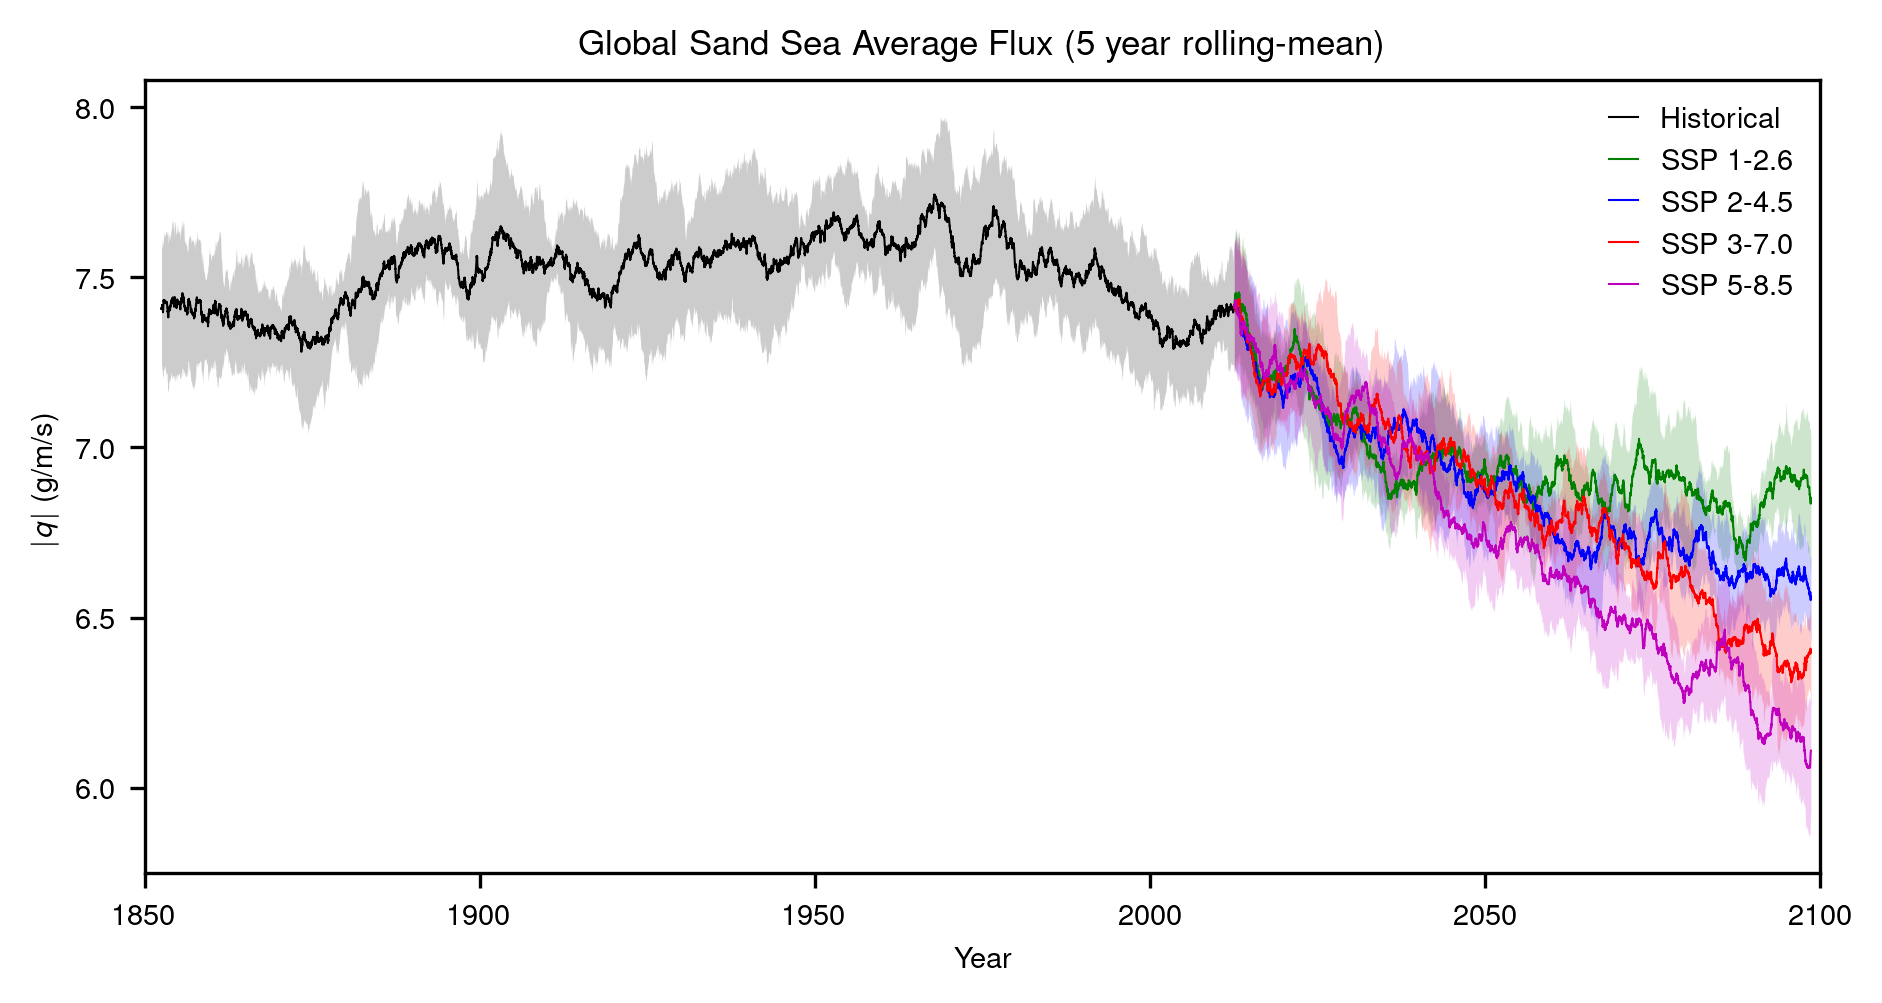

In [10]:
colors = ['k','g','b','r','m']
labels = ['Historical','SSP 1-2.6','SSP 2-4.5','SSP 3-7.0','SSP 5-8.5']
lw = 0.5
alpha = 0.2

fig = plt.gcf()

plt.subplot(111)
for i in range(len(scenarios)):
    plt.plot(ts_scenarios_smoothed[i]*s2yr+1970,qm_ensmean_globmeans_scenarios_smoothed[i]*1e+3,lw=lw,color=colors[i],label=labels[i])
#     plt.fill_between(ts_scenarios_smoothed[i]*s2yr+1970,
#                      (qm_ensmean_globmeans_scenarios_smoothed[i]-qm_ensstd_globmeans_scenarios_smoothed[i])*1e+3,
#                      (qm_ensmean_globmeans_scenarios_smoothed[i]+qm_ensstd_globmeans_scenarios_smoothed[i])*1e+3,lw=0,alpha=alpha,color=colors[i])
#     plt.fill_between(ts_scenarios_smoothed[i]*s2yr+1970,
#                      (qm_ensmean_globmeans_scenarios_smoothed[i]-qm_ensmean_globstd_scenarios_smoothed[i])*1e+3,
#                      (qm_ensmean_globmeans_scenarios_smoothed[i]+qm_ensmean_globstd_scenarios_smoothed[i])*1e+3,lw=0,alpha=alpha,color=colors[i])
#     plt.fill_between(ts_scenarios_smoothed[i]*s2yr+1970,
#                      (qm_ensmean_globmeans_scenarios_smoothed[i]-qm_ensmean_globmeans_scenarios_smoothedstd[i])*1e+3,
#                      (qm_ensmean_globmeans_scenarios_smoothed[i]+qm_ensmean_globmeans_scenarios_smoothedstd[i])*1e+3,lw=0,alpha=alpha,color=colors[i])
    plt.fill_between(ts_scenarios_smoothed[i]*s2yr+1970,
                     (qm_ensmean_globmeans_scenarios_smoothed[i]-qm_ens_globstd_scenarios_smoothed[i])*1e+3,
                     (qm_ensmean_globmeans_scenarios_smoothed[i]+qm_ens_globstd_scenarios_smoothed[i])*1e+3,lw=0,alpha=alpha,color=colors[i])
    
plt.legend(frameon=False,handlelength=1)
plt.xlim(1850,2100)
# plt.ylim(5.5,8)
plt.xlabel('Year')
plt.ylabel('$|q|$ (g/m/s)')
plt.title('Global Sand Sea Average Flux (%d year rolling-mean)'%(tsmooth*s2yr))

fig.set_size_inches(183/25.4,89/25.4, forward=True)

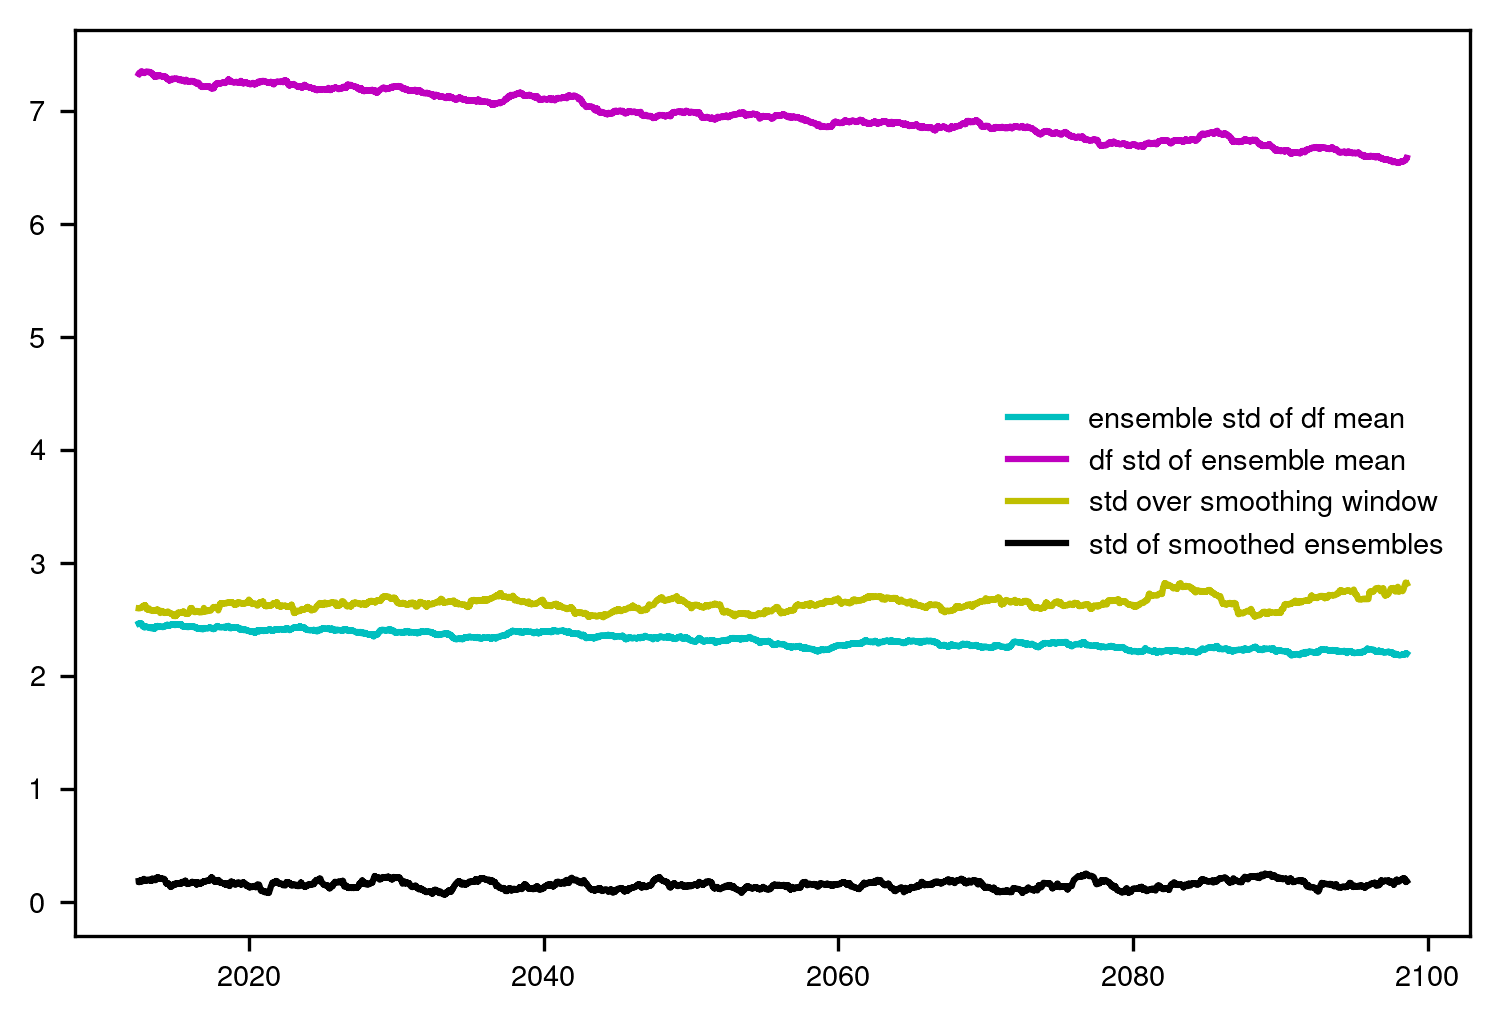

In [11]:
plt.plot(ts_scenarios_smoothed[i]*s2yr+1970,qm_ensstd_globmeans_scenarios_smoothed[i]*1e+3,c='c',label='ensemble std of df mean')
plt.plot(ts_scenarios_smoothed[i]*s2yr+1970,qm_ensmean_globstd_scenarios_smoothed[i]*1e+3,c='m',label='df std of ensemble mean')
plt.plot(ts_scenarios_smoothed[i]*s2yr+1970,qm_ensmean_globmeans_scenarios_smoothedstd[i]*1e+3,c='y',label='std over smoothing window')
plt.plot(ts_scenarios_smoothed[i]*s2yr+1970,qm_ens_globstd_scenarios_smoothed[i]*1e+3,c='k',label='std of smoothed ensembles')
plt.legend(frameon=False)

In [12]:
def angle_mean(angles,axis=0):
    return np.angle(np.mean(np.exp(1j*angles),axis=axis))

def get_summq(q):
    return np.sum(q[:,0,:,:],axis=1)/np.shape(q)[2]

def get_msumq(q):
    qnanmask = ma.masked_equal(q, np.nan)
    temp = np.nansum(qnanmask[:,0,:,:]*np.exp(1j*qnanmask[:,1,:,:]),axis=1)
    return np.abs(temp)/np.shape(q)[2],np.angle(temp)

def get_ens_sumq(q):
    summq = get_summq(q)
    msumqm,msumqa = get_msumq(q)
    return np.mean(summq,axis=0),np.std(summq,axis=0),np.mean(msumqm,axis=0),np.std(msumqm,axis=0),np.mean(msumqm/summq,axis=0),np.std(msumqm/summq,axis=0),angle_mean(msumqa,axis=0)
    
def get_eventmdt(qm,t):
    dt = np.diff(t)[0]
    nzinds = np.squeeze(np.argwhere(qm!=0))

    if len(nzinds)==0:
        qem = np.asarray([])
        qet = np.asarray([])
    else:
        event_inds = np.empty_like(nzinds)
        ind = 0
        event_inds[0] = ind
        for k in range(1,len(nzinds)):
            if nzinds[k]-nzinds[k-1]==1:
                event_inds[k] = ind
            else:
                ind += 1
                event_inds[k] = ind
        num_events = ind

        if num_events>0:
            qem = np.empty(num_events)
            qet = np.empty(num_events-1)
            for k in range(num_events):
                qem[k] = np.sum(qm[nzinds[np.where(event_inds==k)[0]]])*dt
                if k>0:
                    qet[k-1] = t[nzinds[np.where(event_inds==k)[0]][0]]-t[nzinds[np.where(event_inds==k-1)[0]][-1]]
        else:
            qem = np.asarray([np.sum(qm[nzinds])])
            qet = np.asarray([])
    return qem,qet

def get_ens_eventmdt(q,t,Nbins,globbinfactor=np.nan,mscale='lin',tscale='lin',density=False):
    Qem_ens_stack = [None for i in range(np.shape(q)[3])]
    Qet_ens_stack = [None for i in range(np.shape(q)[3])]

    for i in range(np.shape(q)[3]):
        Qem_ens = []
        Qet_ens = []
        for j in range(np.shape(q)[0]):
            temp = get_eventmdt(q[j,0,:,i],t)
            Qem_ens += [temp[0]]
            Qet_ens += [temp[1]]
        Qem_ens_stack[i] = np.hstack(Qem_ens)
        Qet_ens_stack[i] = np.hstack(Qet_ens)
        
    Qem_counts = np.empty((np.shape(q)[3],Nbins-1))
    Qem_bins = np.empty((np.shape(q)[3],Nbins))
    Qet_counts = np.empty((np.shape(q)[3],Nbins-1))
    Qet_bins = np.empty((np.shape(q)[3],Nbins))
    
    for i in range(np.shape(q)[3]):
        if mscale=='lin':
            Qem_bins[i] = np.linspace(0,np.nanmax(Qem_ens_stack[i]),Nbins)
        elif mscale=='log':
            Qem_bins[i] = np.logspace(np.log10(np.nanmin(Qem_ens_stack[i])),np.log10(np.nanmax(Qem_ens_stack[i])),Nbins)
        Qem_counts[i],_ = np.histogram(Qem_ens_stack[i][~np.isnan(Qem_ens_stack[i])],bins=Qem_bins[i],density=density)
        if tscale=='lin':
            Qet_bins[i] = np.linspace(0,np.nanmax(Qet_ens_stack[i]),Nbins)
        elif tscale=='log':
            Qet_bins[i] = np.logspace(np.log10(np.nanmin(Qet_ens_stack[i])),np.log10(np.nanmax(Qet_ens_stack[i])),Nbins)
        Qet_counts[i],_ = np.histogram(Qet_ens_stack[i],bins=Qet_bins[i],density=density)

    if np.isnan(globbinfactor):
        Qem_globcounts = np.empty(globbinfactor*Nbins-1)*np.nan
        Qem_globbins = np.empty(globbinfactor*Nbins)*np.nan
        Qet_globcounts = np.empty(globbinfactor*Nbins-1)*np.nan
        Qet_globbins = np.empty(globbinfactor*Nbins)*np.nan
    else:
        Qem_ens_globstack = np.hstack(Qem_ens_stack)
        Qet_ens_globstack = np.hstack(Qet_ens_stack)
        
        if mscale=='lin':
            Qem_globbins = np.linspace(0,np.nanmax(Qem_ens_globstack),globbinfactor*Nbins)
        elif mscale=='log':
            Qem_globbins = np.logspace(np.log10(np.nanmin(Qem_ens_globstack)),np.log10(np.nanmax(Qem_ens_globstack)),globbinfactor*Nbins)        
        Qem_globcounts,_ = np.histogram(Qem_ens_globstack[~np.isnan(Qem_ens_globstack)],bins=Qem_globbins,density=density)
        if tscale=='lin':
            Qet_globbins = np.linspace(0,np.nanmax(Qet_ens_globstack),globbinfactor*Nbins)
        elif tscale=='log':
            Qet_globbins = np.logspace(np.log10(np.nanmin(Qet_ens_globstack)),np.log10(np.nanmax(Qet_ens_globstack)),globbinfactor*Nbins)
        Qet_globcounts,_ = np.histogram(Qet_ens_globstack[~np.isnan(Qet_ens_globstack)],bins=Qet_globbins,density=density)
        
    return Qem_counts,Qem_bins,Qet_counts,Qet_bins,Qem_globcounts,Qem_globbins,Qet_globcounts,Qet_globbins

def get_ens_summq_seasonality(q,t,Nmonths):
    tann = ((t-t[0])%(1/s2yr))*s2yr
    months = np.arange(0,Nmonths+1)/Nmonths
    mean_summq_month = np.empty((len(q),Nmonths,len(Dunefield_num)))
    for i in range(Nmonths):
        mean_summq_month[:,i] = np.mean(q[:,0,(tann>months[i])&(tann<=months[i+1]),:],axis=1)
    
    trimonth_mean_summq_props = np.empty((len(q),Nmonths,len(Dunefield_num)))
    for i in range(Nmonths):
        if i==Nmonths-1:
            inds = [-2,-1,0]
        else:
            inds = [i-1,i,i+1]
        trimonth_mean_summq_props[:,i,:] = np.sum(mean_summq_month[:,inds,:],axis=1)/np.sum(mean_summq_month,axis=1)
        
    return np.mean(np.max(trimonth_mean_summq_props,axis=1),axis=0),np.std(np.max(trimonth_mean_summq_props,axis=1),axis=0)

def load_years(scenario,years):
    q_stack  = [None for j in range(len(years))]
    ts_stack = [None for j in range(len(years))]
    for j in range(len(years)):
        with open(directory+'ec-earth3-flux-processed/'+scenario+'-'+str(years[j])+'.pkl', 'rb') as f:
            q_stack[j],ts_stack[j],flag = pickle.load(f)
    return np.concatenate(q_stack,axis=2),np.concatenate(ts_stack,axis=0)

In [13]:
Nbins = 60
Nyears = 10
Nmonths = 12
globbinfactor = 10
mscale = 'lin'
tscale = 'lin'
density = True

if runprocessing:
    mean_summq_scenario_ends = np.empty((len(scenarios),len(Dunefield_num)))
    std_summq_scenario_ends = np.empty((len(scenarios),len(Dunefield_num)))
    mean_msumqm_scenario_ends = np.empty((len(scenarios),len(Dunefield_num)))
    std_msumqm_scenario_ends = np.empty((len(scenarios),len(Dunefield_num)))
    mean_fd_scenario_ends = np.empty((len(scenarios),len(Dunefield_num)))
    std_fd_scenario_ends = np.empty((len(scenarios),len(Dunefield_num)))
    mean_msumqa_scenario_ends = np.empty((len(scenarios),len(Dunefield_num)))

    qem_counts_scenario_ends = np.empty((len(scenarios),len(Dunefield_num),Nbins-1))
    qem_bins_scenario_ends = np.empty((len(scenarios),len(Dunefield_num),Nbins))
    qet_counts_scenario_ends = np.empty((len(scenarios),len(Dunefield_num),Nbins-1))
    qet_bins_scenario_ends = np.empty((len(scenarios),len(Dunefield_num),Nbins))

    qem_counts_globscenario_ends = np.empty((len(scenarios),globbinfactor*Nbins-1))
    qem_bins_globscenario_ends = np.empty((len(scenarios),globbinfactor*Nbins))
    qet_counts_globscenario_ends = np.empty((len(scenarios),globbinfactor*Nbins-1))
    qet_bins_globscenario_ends = np.empty((len(scenarios),globbinfactor*Nbins))

    mean_maxtrimonth_mean_summq_props_scenario_ends = np.empty((len(scenarios),len(Dunefield_num)))
    std_maxtrimonth_mean_summq_props_scenario_ends = np.empty((len(scenarios),len(Dunefield_num)))

    for i in range(len(scenarios)):    
        q,t = load_years(scenarios[i],years[i][-Nyears:])

        (mean_summq_scenario_ends[i],
         std_summq_scenario_ends[i],
         mean_msumqm_scenario_ends[i],
         std_msumqm_scenario_ends[i],
         mean_fd_scenario_ends[i],
         std_fd_scenario_ends[i],
         mean_msumqa_scenario_ends[i]) = get_ens_sumq(q)

        (qem_counts_scenario_ends[i],
         qem_bins_scenario_ends[i],
         qet_counts_scenario_ends[i],
         qet_bins_scenario_ends[i],
         qem_counts_globscenario_ends[i],
         qem_bins_globscenario_ends[i],
         qet_counts_globscenario_ends[i],
         qet_bins_globscenario_ends[i]) = get_ens_eventmdt(q,t,Nbins,globbinfactor,mscale,tscale,density)

        (mean_maxtrimonth_mean_summq_props_scenario_ends[i],
         std_maxtrimonth_mean_summq_props_scenario_ends[i]) = get_ens_summq_seasonality(q,t,Nmonths)

        del q,t
        print(scenarios[i]+' loaded',end='\r')

    with open(directory+'q_info_scenario_ends.pkl', 'wb') as f:
        pickle.dump((mean_summq_scenario_ends,
                     std_summq_scenario_ends,
                     mean_msumqm_scenario_ends,
                     std_msumqm_scenario_ends,
                     mean_fd_scenario_ends,
                     std_fd_scenario_ends,
                     mean_msumqa_scenario_ends,
                     qem_counts_scenario_ends,
                     qem_bins_scenario_ends,
                     qet_counts_scenario_ends,
                     qet_bins_scenario_ends,
                     qem_counts_globscenario_ends,
                     qem_bins_globscenario_ends,
                     qet_counts_globscenario_ends,
                     qet_bins_globscenario_ends,                 
                     mean_maxtrimonth_mean_summq_props_scenario_ends,
                     std_maxtrimonth_mean_summq_props_scenario_ends),f)

else:
    with open(directory+'q_info_scenario_ends.pkl', 'rb') as f:
        (mean_summq_scenario_ends,
         std_summq_scenario_ends,
         mean_msumqm_scenario_ends,
         std_msumqm_scenario_ends,
         mean_fd_scenario_ends,
         std_fd_scenario_ends,
         mean_msumqa_scenario_ends,
         qem_counts_scenario_ends,
         qem_bins_scenario_ends,
         qet_counts_scenario_ends,
         qet_bins_scenario_ends,
         qem_counts_globscenario_ends,
         qem_bins_globscenario_ends,
         qet_counts_globscenario_ends,
         qet_bins_globscenario_ends,                 
         mean_maxtrimonth_mean_summq_props_scenario_ends,
         std_maxtrimonth_mean_summq_props_scenario_ends) = pickle.load(f)
    

In [14]:
def get_qe_params(qe_counts_scenario_ends,qe_bins_scenario_ends,scale,density,cdf,func,power=np.nan,xmin=0,xmax=np.inf):
    if func=='exp':
        params = np.empty((len(scenarios),len(Dunefield_num),2))
    else:
        params = np.empty((len(scenarios),len(Dunefield_num)))
    
    for i in range(len(scenarios)):
        for j in range(len(Dunefield_num)):
            if density:
                if cdf:
                    tempy = 1-np.cumsum(qe_counts_scenario_ends[i,j]*np.diff(qe_bins_scenario_ends[i,j]))
                else:
                    tempy = qe_counts_scenario_ends[i,j]
            else:
                tempy = qe_counts_scenario_ends[i,j]/np.sum(qe_counts_scenario_ends[i,j])
            if scale=='lin':
                tempx = qe_bins_scenario_ends[i,j][1:]-np.diff(qe_bins_scenario_ends[i,j])[0]/2
            elif scale=='log':
                tempx = 10**(np.log10(qe_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qe_bins_scenario_ends[i,j]))[0]/2)    

            if func=='exp':
                Nbins = len(tempx)+1
                tempp = np.polyfit(tempx[-int(Nbins*3/4):-1],np.log(tempy[-int(Nbins*3/4):-1]),deg=1)
                params[i,j] = [-1/tempp[0],np.exp(tempp[1])]
            elif func=='hund':
                ftemp = interp1d(tempy, tempx)
                params[i,j] = ftemp(1e-2)
            elif func=='strexp':
                params[i,j] = np.linalg.lstsq((tempx[(tempy>0)&(tempx<xmax)&(tempx>xmin)]**power)[:-1,np.newaxis], -np.log(tempy[(tempy>0)&(tempx<xmax)&(tempx>xmin)][:-1]),rcond=None)[0]**(-1/power)
            elif func=='pwrlaw':
                params[i,j] = np.linalg.lstsq((tempx[(tempy>0)&(tempx<xmax)&(tempx>xmin)])[:-1,np.newaxis], tempy[(tempy>0)&(tempx<xmax)&(tempx>xmin)][:-1]**(-1/power),rcond=None)[0]**-1

    return params

def get_qe_globparams(qe_counts_globscenario_ends,qe_bins_globscenario_ends,scale,density,cdf,func,power=np.nan,xmin=0,xmax=np.inf):
    if func=='exp':
        params = np.empty((len(scenarios),2))
    else:
        params = np.empty((len(scenarios)))
    
    for i in range(len(scenarios)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qe_counts_globscenario_ends[i]*np.diff(qe_bins_globscenario_ends[i]))
            else:
                tempy = qe_counts_globscenario_ends[i]
        else:
            tempy = qe_counts_globscenario_ends[i]/np.sum(qe_counts_globscenario_ends[i])
        if scale=='lin':
            tempx = qe_bins_globscenario_ends[i][1:]-np.diff(qe_bins_globscenario_ends[i])[0]/2
        elif scale=='log':
            tempx = 10**(np.log10(qe_bins_globscenario_ends[i])[1:]-np.diff(np.log10(qe_bins_globscenario_ends[i]))[0]/2)    

        if func=='exp':
            Nbins = len(tempx)+1
            tempp = np.polyfit(tempx[-int(Nbins*3/4):-1],np.log(tempy[-int(Nbins*3/4):-1]),deg=1)
            params[i] = [-1/tempp[0],np.exp(tempp[1])]
        elif func=='hund':
            ftemp = interp1d(tempy, tempx)
            params[i] = ftemp(1e-2)
        elif func=='strexp':
            params[i] = np.linalg.lstsq((tempx[(tempy>0)&(tempx<xmax)&(tempx>xmin)]**power)[:-1,np.newaxis], -np.log(tempy[(tempy>0)&(tempx<xmax)&(tempx>xmin)][:-1]),rcond=None)[0]**(-1/power)
        elif func=='pwrlaw':
            params[i] = np.linalg.lstsq((tempx[(tempy>0)&(tempx<xmax)&(tempx>xmin)])[:-1,np.newaxis], tempy[(tempy>0)&(tempx<xmax)&(tempx>xmin)][:-1]**(-1/power),rcond=None)[0]**-1

    return params

In [15]:
cdf = True

qetfunc  = 'hund'
qetpower = np.nan
qetxmin = 0
qetxmax = np.inf
qet_params_scenario_ends = get_qe_params(qet_counts_scenario_ends,qet_bins_scenario_ends,scale=tscale,density=density,cdf=cdf,func=qetfunc,power=qetpower,xmin=qetxmin,xmax=qetxmax)
qet_params_globscenario_ends = get_qe_globparams(qet_counts_globscenario_ends,qet_bins_globscenario_ends,scale=tscale,density=density,cdf=cdf,func=qetfunc,power=qetpower,xmin=qetxmin,xmax=qetxmax)

qemfunc  = 'hund'
qempower = np.nan
qemxmin = 0
qemxmax = np.inf
qem_params_scenario_ends = get_qe_params(qem_counts_scenario_ends,qem_bins_scenario_ends,scale=mscale,density=density,cdf=cdf,func=qemfunc,power=qempower,xmin=qemxmin,xmax=qemxmax)
qem_params_globscenario_ends = get_qe_globparams(qem_counts_globscenario_ends,qem_bins_globscenario_ends,scale=mscale,density=density,cdf=cdf,func=qemfunc,power=qempower,xmin=qemxmin,xmax=qemxmax)

(1e-07, 2.0)

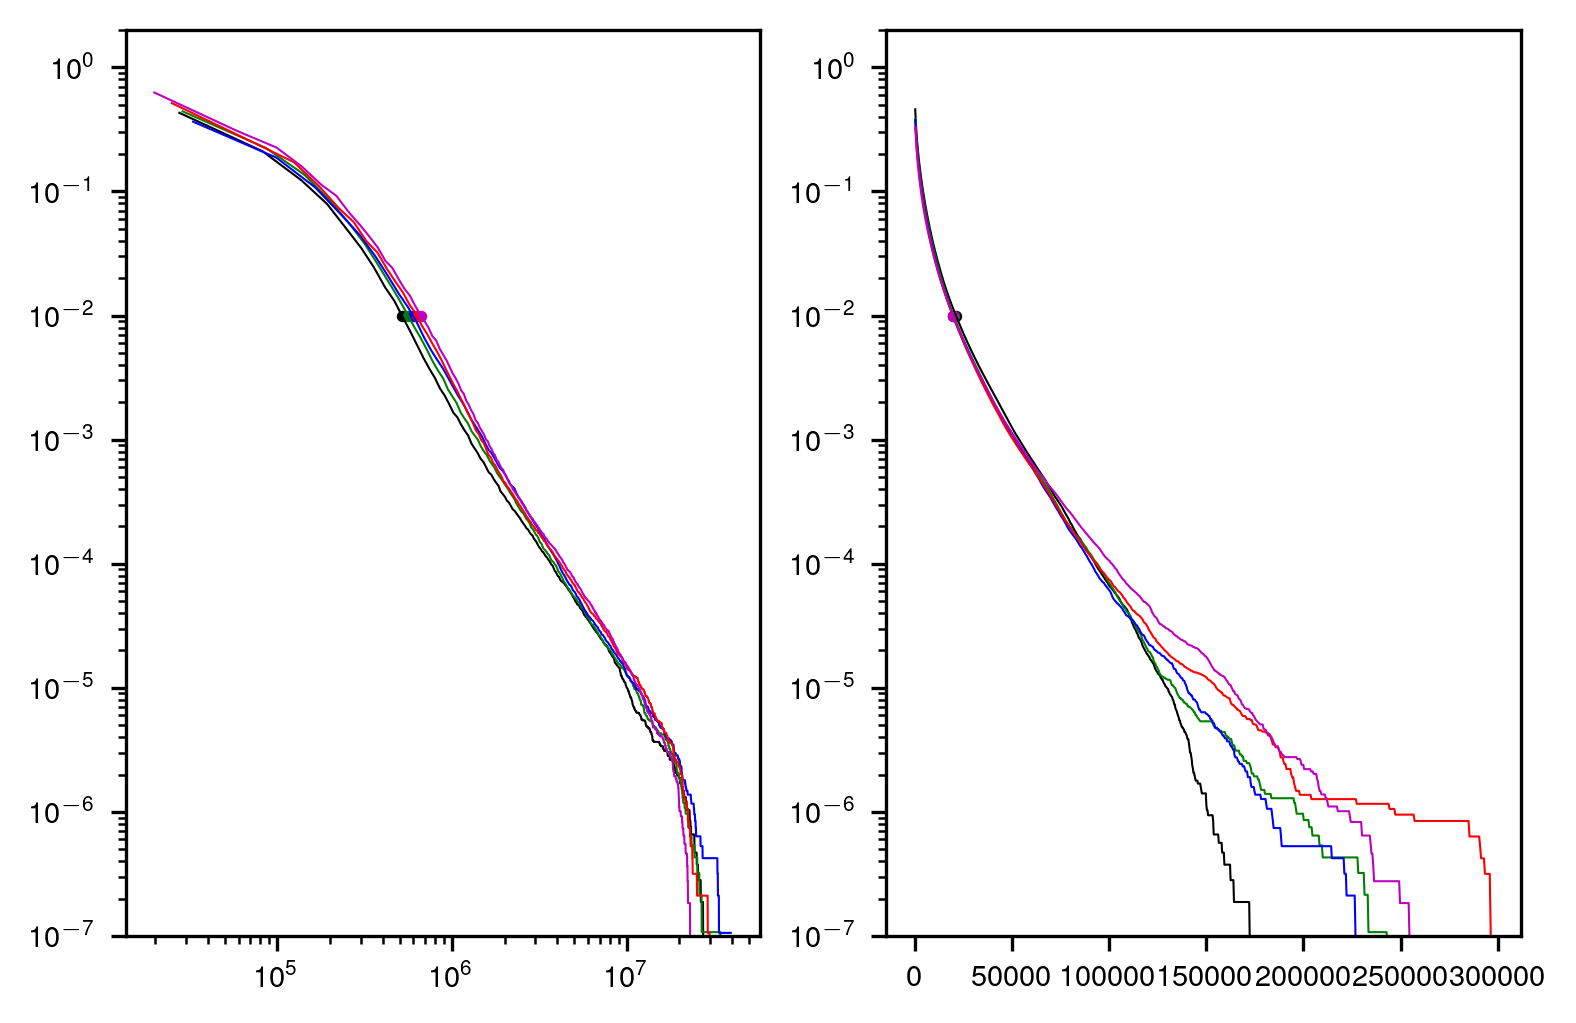

In [16]:
lw = 0.5
S = 3
colors = ['k','g','b','r','m']

plt.subplot(121)
for i in range(len(scenarios)):
    if density:
        if cdf:
            tempy = 1-np.cumsum(qet_counts_globscenario_ends[i]*np.diff(qet_bins_globscenario_ends[i]))
        else:
            tempy = qet_counts_globscenario_ends[i]
    else:
        tempy = qet_counts_globscenario_ends[i]/np.sum(qet_counts_globscenario_ends[i])
    if tscale=='lin':
        tempx = qet_bins_globscenario_ends[i][1:]-np.diff(qet_bins_globscenario_ends[i])[0]/2
    elif tscale=='log':
        tempx = 10**(np.log10(qet_bins_globscenario_ends[i])[1:]-np.diff(np.log10(qet_bins_globscenario_ends[i]))[0]/2)

    plt.plot(tempx[tempy>0],tempy[tempy>0],color=colors[i],lw=lw)

    if qetfunc=='exp':
        plt.plot(tempx[-int(Nbins*3/4):-1],qet_params_globscenario_ends[i,1]*np.exp(-tempx[-int(Nbins*3/4):-1]/qet_params_globscenario_ends[i,0]),'--',color=colors[i],lw=lw)
    elif qetfunc=='hund':
        plt.scatter(qet_params_globscenario_ends[i],1e-2,color=colors[i],s=S)
    elif qetfunc=='strexp':
        plt.plot(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)],np.exp(-(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)]/qet_params_globscenario_ends[i])**qetpower),'--',color=colors[i],lw=lw)
    elif qetfunc=='pwrlaw':
        plt.plot(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)],(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)]/qet_params_globscenario_ends[i])**-qetpower,'--',color=colors[i],lw=lw)

plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-7,2e+0)

plt.subplot(122)
for i in range(len(scenarios)):
    if density:
        if cdf:
            tempy = 1-np.cumsum(qem_counts_globscenario_ends[i]*np.diff(qem_bins_globscenario_ends[i]))
        else:
            tempy = qem_counts_globscenario_ends[i]
    else:
        tempy = qem_counts_globscenario_ends[i]/np.sum(qem_counts_globscenario_ends[i])
    if mscale=='lin':
        tempx = qem_bins_globscenario_ends[i][1:]-np.diff(qem_bins_globscenario_ends[i])[0]/2
    elif mscale=='log':
        tempx = 10**(np.log10(qem_bins_globscenario_ends[i])[1:]-np.diff(np.log10(qem_bins_globscenario_ends[i]))[0]/2)

    plt.plot(tempx[tempy>0],tempy[tempy>0],color=colors[i],lw=lw)

    if qemfunc=='exp':
        plt.plot(tempx[-int(Nbins*3/4):-1],qem_params_globscenario_ends[i,1]*np.exp(-tempx[-int(Nbins*3/4):-1]/qem_params_globscenario_ends[i,0]),'--',color=colors[i],lw=lw)
    elif qemfunc=='hund':
        plt.scatter(qem_params_globscenario_ends[i],1e-2,color=colors[i],s=S)
    elif qemfunc=='strexp':
        plt.plot(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)],np.exp(-(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)]/qem_params_globscenario_ends[i])**qempower),'--',color=colors[i],lw=lw)
    elif qemfunc=='pwrlaw':
        plt.plot(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)],(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)]/qem_params_globscenario_ends[i])**-qempower,'--',color=colors[i],lw=lw)

plt.yscale('log')
# plt.xscale('log')
plt.ylim(1e-7,2e+0)

(1e-05, 2.0)

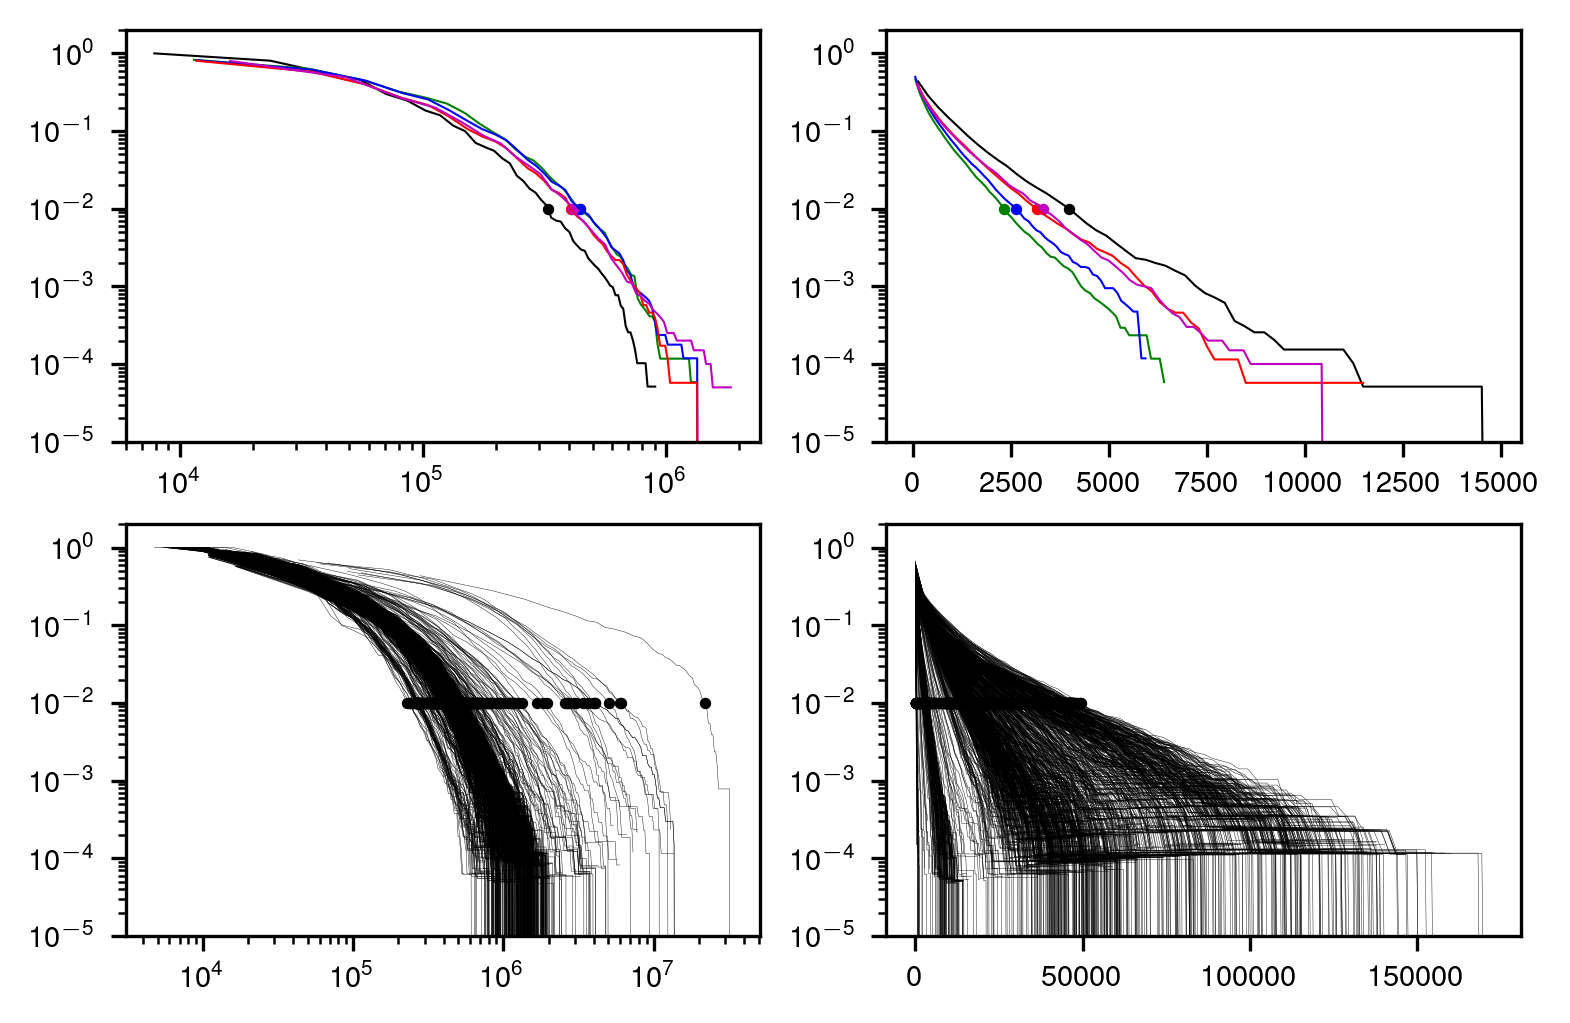

In [17]:
lw = 0.5
S = 3
colors = ['k','g','b','r','m']

tileind = 500
scenarioind = 0

plt.subplot(221)
for i in range(len(scenarios)):
    for j in [tileind]:
        if density:
            if cdf:
                tempy = 1-np.cumsum(qet_counts_scenario_ends[i,j]*np.diff(qet_bins_scenario_ends[i,j]))
            else:
                tempy = qet_counts_scenario_ends[i,j]
        else:
            tempy = qet_counts_scenario_ends[i,j]/np.sum(qet_counts_scenario_ends[i,j])
        if tscale=='lin':
            tempx = qet_bins_scenario_ends[i,j][1:]-np.diff(qet_bins_scenario_ends[i,j])[0]/2
        elif tscale=='log':
            tempx = 10**(np.log10(qet_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qet_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0],tempy[tempy>0],color=colors[i],lw=lw)
        
        if qetfunc=='exp':
            plt.plot(tempx[-int(Nbins*3/4):-1],qet_params_scenario_ends[i,j,1]*np.exp(-tempx[-int(Nbins*3/4):-1]/qet_params_scenario_ends[i,j,0]),'--',color=colors[i],lw=lw)
        elif qetfunc=='hund':
            plt.scatter(qet_params_scenario_ends[i,j],1e-2,color=colors[i],s=S)
        elif qetfunc=='strexp':
            plt.plot(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)],np.exp(-(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)]/qet_params_scenario_ends[i,j])**qetpower),'--',color=colors[i],lw=lw)
        elif qetfunc=='pwrlaw':
            plt.plot(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)],(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)]/qet_params_scenario_ends[i,j])**-qetpower,'--',color=colors[i],lw=lw)

plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-5,2e+0)

plt.subplot(222)
for i in range(len(scenarios)):
    for j in [tileind]:
        if density:
            if cdf:
                tempy = 1-np.cumsum(qem_counts_scenario_ends[i,j]*np.diff(qem_bins_scenario_ends[i,j]))
            else:
                tempy = qem_counts_scenario_ends[i,j]
        else:
            tempy = qem_counts_scenario_ends[i,j]/np.sum(qem_counts_scenario_ends[i,j])
        if mscale=='lin':
            tempx = qem_bins_scenario_ends[i,j][1:]-np.diff(qem_bins_scenario_ends[i,j])[0]/2
        elif mscale=='log':
            tempx = 10**(np.log10(qem_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qem_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0],tempy[tempy>0],color=colors[i],lw=lw)
        
        if qemfunc=='exp':
            plt.plot(tempx[-int(Nbins*3/4):-1],qem_params_scenario_ends[i,j,1]*np.exp(-tempx[-int(Nbins*3/4):-1]/qem_params_scenario_ends[i,j,0]),'--',color=colors[i],lw=lw)
        elif qemfunc=='hund':
            plt.scatter(qem_params_scenario_ends[i,j],1e-2,color=colors[i],s=S)
        elif qemfunc=='strexp':
            plt.plot(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)],np.exp(-(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)]/qem_params_scenario_ends[i,j])**qempower),'--',color=colors[i],lw=lw)
        elif qemfunc=='pwrlaw':
            plt.plot(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)],(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)]/qem_params_scenario_ends[i,j])**-qempower,'--',color=colors[i],lw=lw)

plt.yscale('log')
# plt.xscale('log')
plt.ylim(1e-5,2e+0)

lw = 0.1

plt.subplot(223)
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qet_counts_scenario_ends[i,j]*np.diff(qet_bins_scenario_ends[i,j]))
            else:
                tempy = qet_counts_scenario_ends[i,j]
        else:
            tempy = qet_counts_scenario_ends[i,j]/np.sum(qet_counts_scenario_ends[i,j])
        if tscale=='lin':
            tempx = qet_bins_scenario_ends[i,j][1:]-np.diff(qet_bins_scenario_ends[i,j])[0]/2
        elif tscale=='log':
            tempx = 10**(np.log10(qet_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qet_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0],tempy[tempy>0],color=colors[i],lw=lw)
        
        if qetfunc=='exp':
            plt.plot(tempx[-int(Nbins*3/4):-1],qet_params_scenario_ends[i,j,1]*np.exp(-tempx[-int(Nbins*3/4):-1]/qet_params_scenario_ends[i,j,0]),'--',color=colors[i],lw=lw)
        elif qetfunc=='hund':
            plt.scatter(qet_params_scenario_ends[i,j],1e-2,color=colors[i],s=S)
        elif qetfunc=='strexp':
            plt.plot(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)],np.exp(-(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)]/qet_params_scenario_ends[i,j])**qetpower),'--',color=colors[i],lw=lw)
        elif qetfunc=='pwrlaw':
            plt.plot(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)],(tempx[(tempy>0)&(tempx<qetxmax)&(tempx>qetxmin)]/qet_params_scenario_ends[i,j])**-qetpower,'--',color=colors[i],lw=lw)

plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-5,2e+0)

plt.subplot(224)
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qem_counts_scenario_ends[i,j]*np.diff(qem_bins_scenario_ends[i,j]))
            else:
                tempy = qem_counts_scenario_ends[i,j]
        else:
            tempy = qem_counts_scenario_ends[i,j]/np.sum(qem_counts_scenario_ends[i,j])
        if mscale=='lin':
            tempx = qem_bins_scenario_ends[i,j][1:]-np.diff(qem_bins_scenario_ends[i,j])[0]/2
        elif mscale=='log':
            tempx = 10**(np.log10(qem_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qem_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0],tempy[tempy>0],color=colors[i],lw=lw)
        
        if qemfunc=='exp':
            plt.plot(tempx[-int(Nbins*3/4):-1],qem_params_scenario_ends[i,j,1]*np.exp(-tempx[-int(Nbins*3/4):-1]/qem_params_scenario_ends[i,j,0]),'--',color=colors[i],lw=lw)
        elif qemfunc=='hund':
            plt.scatter(qem_params_scenario_ends[i,j],1e-2,color=colors[i],s=S)
        elif qemfunc=='strexp':
            plt.plot(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)],np.exp(-(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)]/qem_params_scenario_ends[i,j])**qempower),'--',color=colors[i],lw=lw)
        elif qemfunc=='pwrlaw':
            plt.plot(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)],(tempx[(tempy>0)&(tempx<qemxmax)&(tempx>qemxmin)]/qem_params_scenario_ends[i,j])**-qempower,'--',color=colors[i],lw=lw)

plt.yscale('log')
# plt.xscale('log')
plt.ylim(1e-5,2e+0)

In [18]:
mean_summq_scenario_ends_dfmean = dfmean(mean_summq_scenario_ends)
std_summq_scenario_ends_dfmean = dfmean(std_summq_scenario_ends)
mean_msumqm_scenario_ends_dfmean = dfmean(mean_msumqm_scenario_ends)
std_msumqm_scenario_ends_dfmean = dfmean(std_msumqm_scenario_ends)
mean_fd_scenario_ends_dfmean = dfmean(mean_fd_scenario_ends)
std_fd_scenario_ends_dfmean = dfmean(std_fd_scenario_ends)
mean_msumqa_scenario_ends_dfmean = dfanglemean(mean_msumqa_scenario_ends)
qet_params_scenario_ends_dfmean = dfmean(qet_params_scenario_ends)
qem_params_scenario_ends_dfmean = dfmean(qem_params_scenario_ends)
mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean = dfmean(mean_maxtrimonth_mean_summq_props_scenario_ends)
std_maxtrimonth_mean_summq_props_scenario_ends_dfmean = dfmean(std_maxtrimonth_mean_summq_props_scenario_ends)

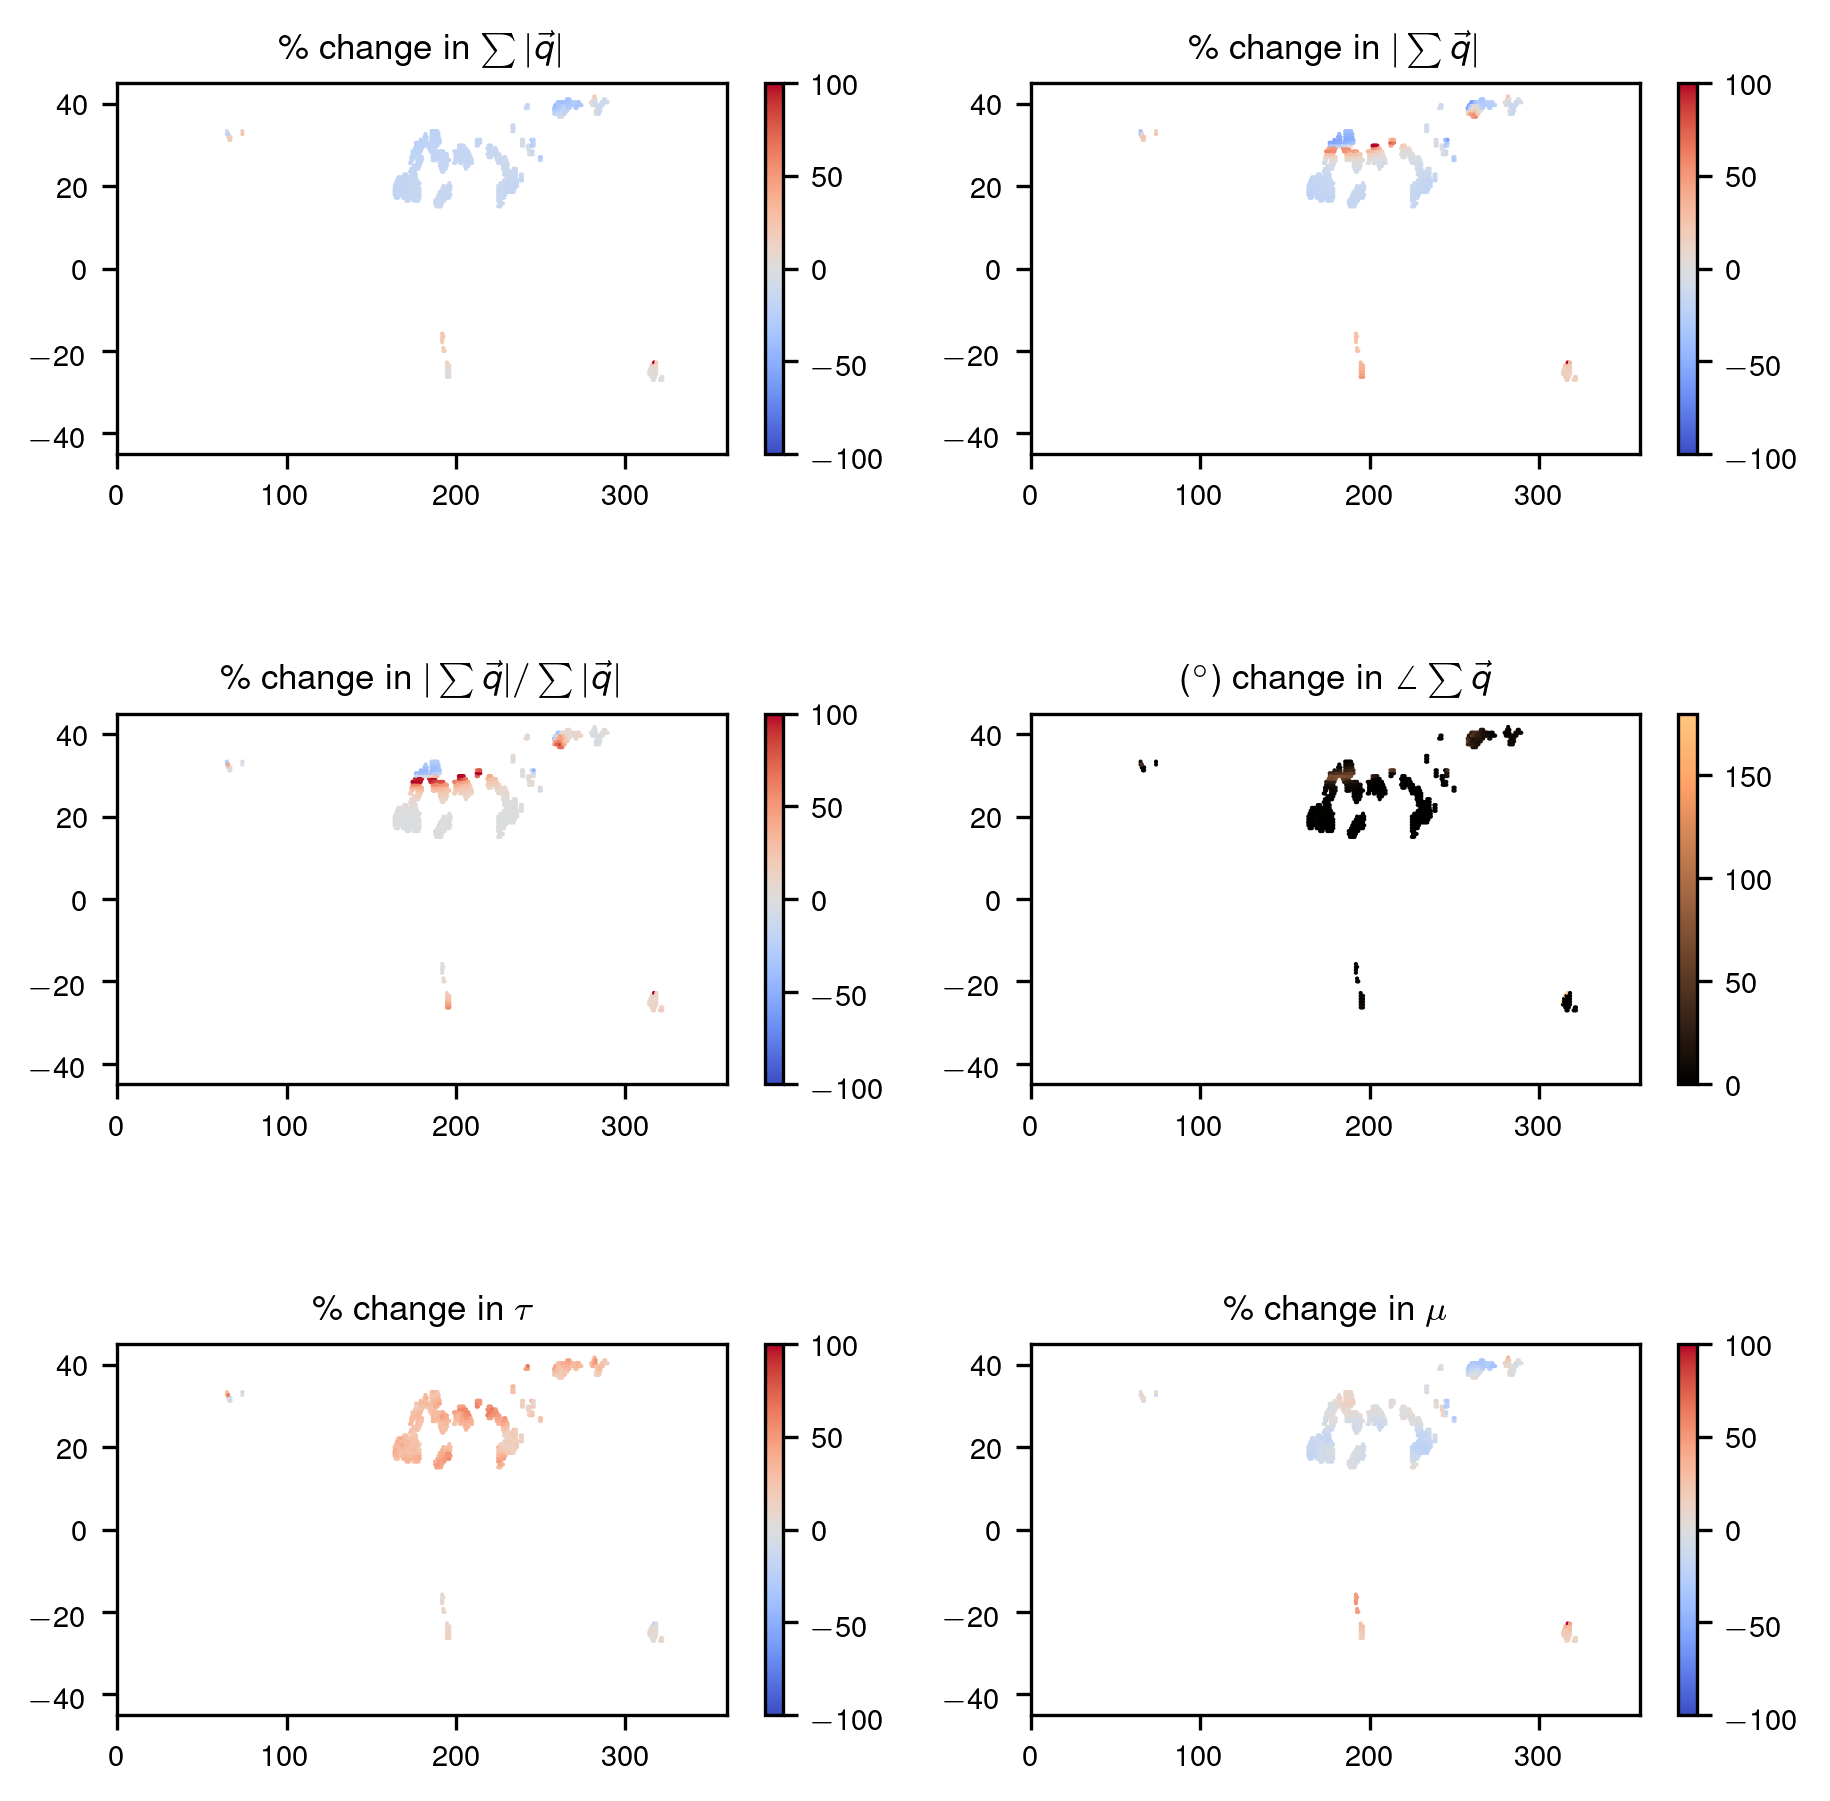

In [19]:
S = 1
i = 4

cmap = 'coolwarm'

fig = plt.gcf()

plt.subplot(321)
plt.scatter(Dunefield_latlon[:,0],Dunefield_latlon[:,1],c=100*(mean_summq_scenario_ends[i]-mean_summq_scenario_ends[0])/mean_summq_scenario_ends[0],s=S,vmin=-100,vmax=100,cmap=cmap,lw=0)
plt.colorbar()
plt.title('\% change in $\\sum|\\vec{q}|$')
plt.xlim(0,360)
plt.ylim(-45,45)

plt.subplot(322)
plt.scatter(Dunefield_latlon[:,0],Dunefield_latlon[:,1],c=100*(mean_msumqm_scenario_ends[i]-mean_msumqm_scenario_ends[0])/mean_msumqm_scenario_ends[0],s=S,vmin=-100,vmax=100,cmap=cmap,lw=0)
plt.colorbar()
plt.title('\% change in $|\\sum\\vec{q}|$')
plt.xlim(0,360)
plt.ylim(-45,45)

plt.subplot(323)
plt.scatter(Dunefield_latlon[:,0],Dunefield_latlon[:,1],c=100*(mean_fd_scenario_ends[i]-mean_fd_scenario_ends[0])/mean_fd_scenario_ends[0],s=S,vmin=-100,vmax=100,cmap=cmap,lw=0)
plt.colorbar()
plt.title('\% change in $|\\sum\\vec{q}|/\\sum|\\vec{q}|$')
plt.xlim(0,360)
plt.ylim(-45,45)

plt.subplot(324)
plt.scatter(Dunefield_latlon[:,0],Dunefield_latlon[:,1],c=np.abs(mean_msumqa_scenario_ends[i]-mean_msumqa_scenario_ends[0])*180/np.pi,s=S,vmin=0,vmax=180,cmap='copper',lw=0)
plt.colorbar()
plt.title('($^\\circ$) change in $\\angle\\sum\\vec{q}$')
plt.xlim(0,360)
plt.ylim(-45,45)

plt.subplot(325)
plt.scatter(Dunefield_latlon[:,0],Dunefield_latlon[:,1],c=100*(qet_params_scenario_ends[i,:]-qet_params_scenario_ends[0,:])/qet_params_scenario_ends[0,:],s=S,vmin=-100,vmax=100,cmap=cmap,lw=0)
plt.colorbar()
plt.title('\% change in $\\tau$')
plt.xlim(0,360)
plt.ylim(-45,45)

plt.subplot(326)
plt.scatter(Dunefield_latlon[:,0],Dunefield_latlon[:,1],c=100*(qem_params_scenario_ends[i,:]-qem_params_scenario_ends[0,:])/qem_params_scenario_ends[0,:],s=S,vmin=-100,vmax=100,cmap=cmap,lw=0)
plt.colorbar()
plt.title('\% change in $\\mu$')
plt.xlim(0,360)
plt.ylim(-45,45)

fig.subplots_adjust(hspace=0.7)

fig.set_size_inches(183/25.4,183/25.4, forward=True)
# plt.savefig('figures/qm_ens_globmeans_scenarios_smoothed_timeseries.png',dpi=300)

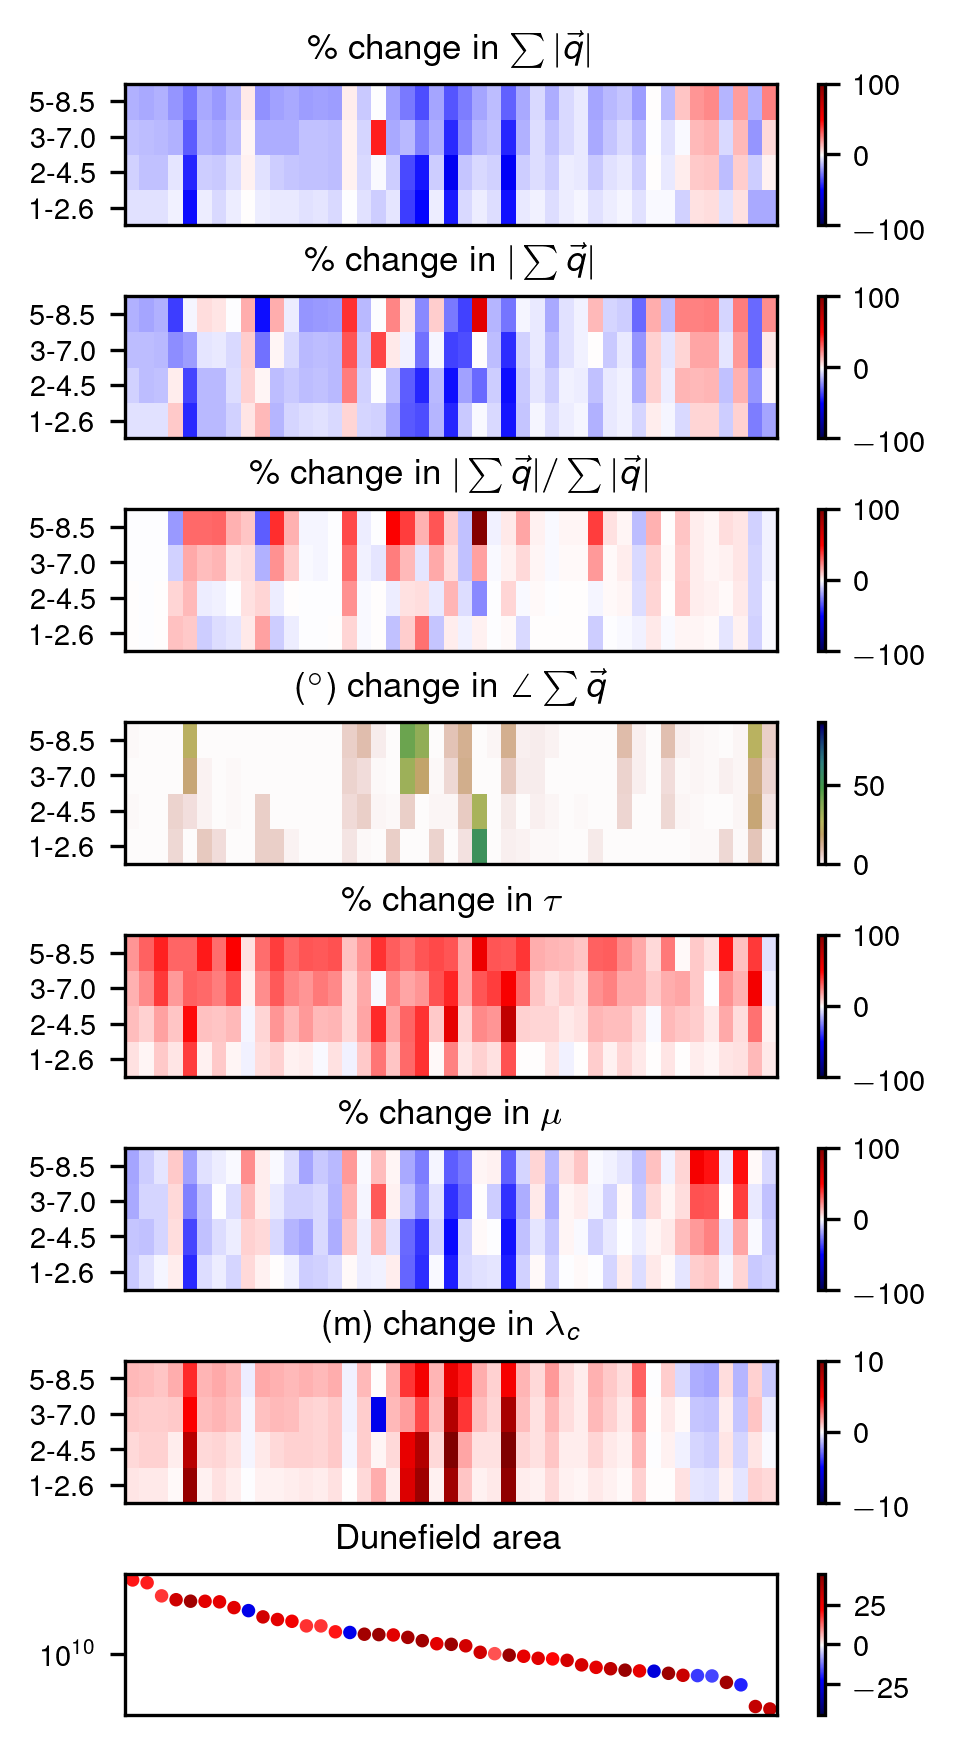

In [20]:
cmap = 'seismic'
S = 5

fig = plt.gcf()

plt.subplot(811)
temp = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100)
plt.title('\% change in $\\sum|\\vec{q}|$')
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.colorbar()

plt.subplot(812)
temp = 100*(mean_msumqm_scenario_ends_dfmean[1:]-mean_msumqm_scenario_ends_dfmean[0])/mean_msumqm_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100)
plt.title('\% change in $|\\sum\\vec{q}|$')
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.colorbar()

plt.subplot(813)
temp = 100*(mean_fd_scenario_ends_dfmean[1:]-mean_fd_scenario_ends_dfmean[0])/mean_fd_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100)
plt.title('\% change in $|\\sum\\vec{q}|/\\sum|\\vec{q}|$')
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.colorbar()

plt.subplot(814)
temp = (mean_msumqa_scenario_ends_dfmean[1:]-mean_msumqa_scenario_ends_dfmean[0])*180/np.pi
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap='gist_earth_r',vmin=0,vmax=90)
plt.title('($^\\circ$) change in $\\angle\\sum\\vec{q}$')
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.colorbar()

plt.subplot(815)
temp = 100*(qet_params_scenario_ends_dfmean[1:]-qet_params_scenario_ends_dfmean[0])/qet_params_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100)
plt.title('\% change in $\\tau$')
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.colorbar()

plt.subplot(816)
temp = 100*(qem_params_scenario_ends_dfmean[1:]-qem_params_scenario_ends_dfmean[0])/qem_params_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100)
plt.title('\% change in $\\mu$')
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.colorbar()

plt.subplot(817)
temp = get_wavel(get_usfromqm(mean_summq_scenario_ends_dfmean[1:]))-get_wavel(get_usfromqm(mean_summq_scenario_ends_dfmean[0]))
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-10,vmax=10)
plt.title('(m) change in $\lambda_{c}$')
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.colorbar()

plt.subplot(818)
plt.scatter(np.arange(Ndunefields)+0.5,df_area[np.argsort(df_area)[::-1]],c=df_avlat[np.argsort(df_area)[::-1]],s=S,cmap=cmap,vmin=-45,vmax=45)
plt.yscale('log')
plt.xlim(0,Ndunefields)
plt.title('Dunefield area')
plt.xticks([])
plt.colorbar()

fig.subplots_adjust(hspace=0.5)

fig.set_size_inches(89/25.4,183/25.4, forward=True)

In [21]:
def get_fd_season_slopes(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean,
                         std_maxtrimonth_mean_summq_props_scenario_ends_dfmean,
                         mean_fd_scenario_ends_dfmean,
                         std_fd_scenario_ends_dfmean):
    
    mean_fd_seasonscenario_ends_dfmean = np.arctan2(mean_fd_scenario_ends_dfmean-mean_fd_scenario_ends_dfmean[0],
                                                    mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean-mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0])
    
    std_fd_seasonscenario_ends_dfmean = np.mean(np.concatenate([np.abs(np.arctan2((mean_fd_scenario_ends_dfmean+std_fd_scenario_ends_dfmean)-
                                                                                  (mean_fd_scenario_ends_dfmean)[0],
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)-
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)[0])
                                                                       -mean_fd_seasonscenario_ends_dfmean)[np.newaxis,:],
                                                                np.abs(np.arctan2((mean_fd_scenario_ends_dfmean-std_fd_scenario_ends_dfmean)-
                                                                                  (mean_fd_scenario_ends_dfmean)[0],
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)-
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)[0])
                                                                       -mean_fd_seasonscenario_ends_dfmean)[np.newaxis,:],
                                                                np.abs(np.arctan2((mean_fd_scenario_ends_dfmean)-
                                                                                  (mean_fd_scenario_ends_dfmean)[0],
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean)-
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)[0])
                                                                       -mean_fd_seasonscenario_ends_dfmean)[np.newaxis,:],
                                                                np.abs(np.arctan2((mean_fd_scenario_ends_dfmean)-
                                                                                  (mean_fd_scenario_ends_dfmean)[0],
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean)-
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)[0])
                                                                       -mean_fd_seasonscenario_ends_dfmean)[np.newaxis,:],
                                                                np.abs(np.arctan2((mean_fd_scenario_ends_dfmean)-
                                                                                  (mean_fd_scenario_ends_dfmean+std_fd_scenario_ends_dfmean)[0],
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)-
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)[0])
                                                                       -mean_fd_seasonscenario_ends_dfmean)[np.newaxis,:],
                                                                np.abs(np.arctan2((mean_fd_scenario_ends_dfmean)-
                                                                                  (mean_fd_scenario_ends_dfmean-std_fd_scenario_ends_dfmean)[0],
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)-
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)[0])
                                                                       -mean_fd_seasonscenario_ends_dfmean)[np.newaxis,:],
                                                                np.abs(np.arctan2((mean_fd_scenario_ends_dfmean)-
                                                                                  (mean_fd_scenario_ends_dfmean)[0],
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)-
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean)[0])
                                                                       -mean_fd_seasonscenario_ends_dfmean)[np.newaxis,:],
                                                                np.abs(np.arctan2((mean_fd_scenario_ends_dfmean)-
                                                                                  (mean_fd_scenario_ends_dfmean)[0],
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean)-
                                                                                  (mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean)[0])
                                                                       -mean_fd_seasonscenario_ends_dfmean)[np.newaxis,:],
                                                                
                                                               ])
                                                ,axis=0)
        
    return mean_fd_seasonscenario_ends_dfmean,std_fd_seasonscenario_ends_dfmean

In [22]:
(mean_fd_seasonscenario_ends_dfmean,
 std_fd_seasonscenario_ends_dfmean) = get_fd_season_slopes(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean,
                                                           std_maxtrimonth_mean_summq_props_scenario_ends_dfmean,
                                                           mean_fd_scenario_ends_dfmean,
                                                           std_fd_scenario_ends_dfmean)

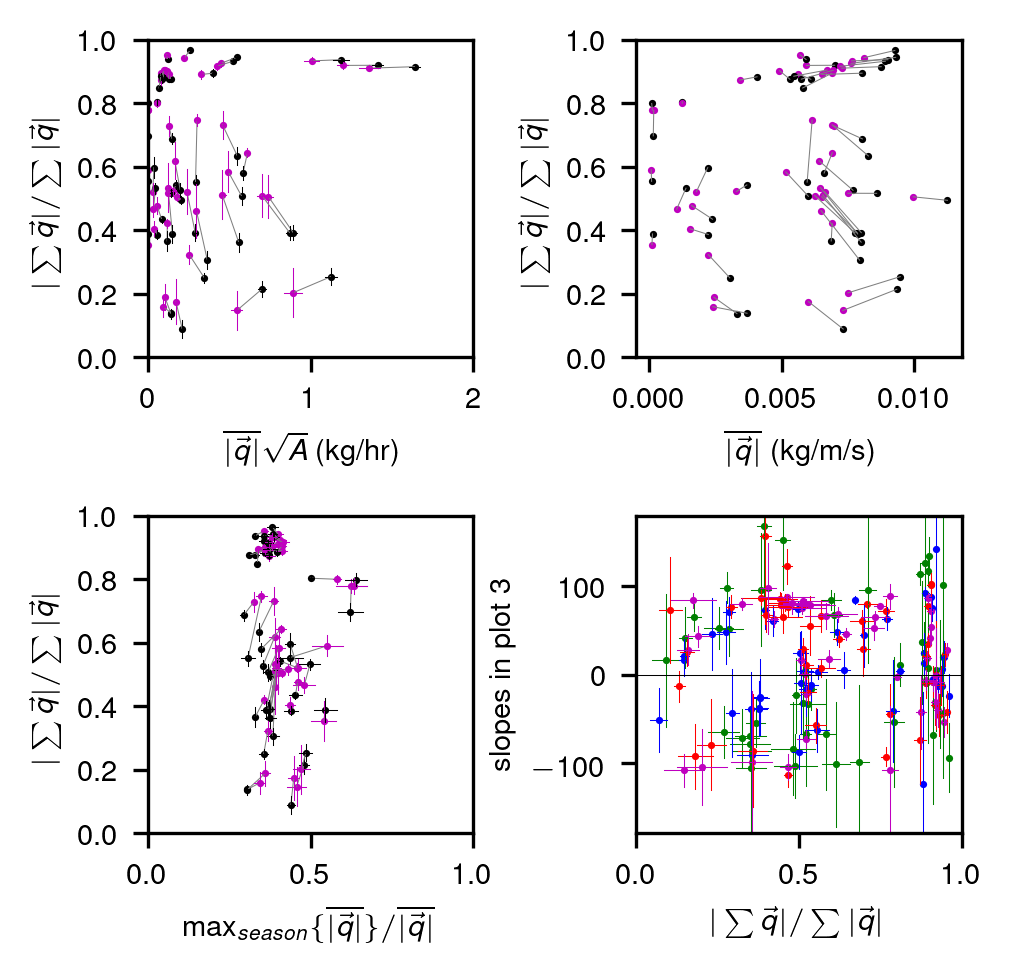

In [23]:
S = 3
lw = 0.25

fig = plt.gcf()

plt.subplot(221)

for i in range(Ndunefields):
    plt.scatter(df_area[i]**0.5*mean_summq_scenario_ends_dfmean[0,i]*s2hr,mean_fd_scenario_ends_dfmean[0,i],c=colors[0],s=S,lw=0)
    plt.scatter(df_area[i]**0.5*mean_summq_scenario_ends_dfmean[-1,i]*s2hr,mean_fd_scenario_ends_dfmean[-1,i],c=colors[-1],s=S,lw=0)
    plt.plot([df_area[i]**0.5*mean_summq_scenario_ends_dfmean[-1,i]*s2hr,df_area[i]**0.5*mean_summq_scenario_ends_dfmean[0,i]*s2hr],
             [mean_fd_scenario_ends_dfmean[-1,i],mean_fd_scenario_ends_dfmean[0,i]],c='grey',lw=lw)
    
    plt.plot([df_area[i]**0.5*(mean_summq_scenario_ends_dfmean[-1,i]-std_summq_scenario_ends_dfmean[-1,i])*s2hr,df_area[i]**0.5*(mean_summq_scenario_ends_dfmean[-1,i]+std_summq_scenario_ends_dfmean[-1,i])*s2hr],
             [mean_fd_scenario_ends_dfmean[-1,i],mean_fd_scenario_ends_dfmean[-1,i]],c=colors[-1],lw=lw)
    plt.plot([df_area[i]**0.5*mean_summq_scenario_ends_dfmean[-1,i]*s2hr,df_area[i]**0.5*mean_summq_scenario_ends_dfmean[-1,i]*s2hr],
             [mean_fd_scenario_ends_dfmean[-1,i]-std_fd_scenario_ends_dfmean[-1,i],mean_fd_scenario_ends_dfmean[-1,i]+std_fd_scenario_ends_dfmean[-1,i]],c=colors[-1],lw=lw)
    plt.plot([df_area[i]**0.5*(mean_summq_scenario_ends_dfmean[0,i]-std_summq_scenario_ends_dfmean[0,i])*s2hr,df_area[i]**0.5*(mean_summq_scenario_ends_dfmean[0,i]+std_summq_scenario_ends_dfmean[0,i])*s2hr],
             [mean_fd_scenario_ends_dfmean[0,i],mean_fd_scenario_ends_dfmean[0,i]],c=colors[0],lw=lw)
    plt.plot([df_area[i]**0.5*mean_summq_scenario_ends_dfmean[0,i]*s2hr,df_area[i]**0.5*mean_summq_scenario_ends_dfmean[0,i]*s2hr],
             [mean_fd_scenario_ends_dfmean[0,i]-std_fd_scenario_ends_dfmean[0,i],mean_fd_scenario_ends_dfmean[0,i]+std_fd_scenario_ends_dfmean[0,i]],c=colors[0],lw=lw)
    
plt.ylim(0,1)
plt.xlim(0,2)
plt.xlabel('$\\overline{|\\vec{q}|}\\sqrt{A}$ (kg/hr)')
plt.ylabel('$|\\sum\\vec{q}|/\\sum|\\vec{q}|$')

plt.subplot(222)

for i in range(Ndunefields):
    plt.scatter(mean_summq_scenario_ends_dfmean[0,i],mean_fd_scenario_ends_dfmean[0,i],c=colors[0],s=S,lw=0)
    plt.scatter(mean_summq_scenario_ends_dfmean[-1,i],mean_fd_scenario_ends_dfmean[-1,i],c=colors[-1],s=S,lw=0)
    plt.plot([mean_summq_scenario_ends_dfmean[-1,i],mean_summq_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[-1,i],mean_fd_scenario_ends_dfmean[0,i]],c='grey',lw=lw)
plt.ylim(0,1)
# plt.xlim(0,2)
plt.xlabel('$\\overline{|\\vec{q}|}$ (kg/m/s)')
plt.ylabel('$|\\sum\\vec{q}|/\\sum|\\vec{q}|$')

plt.subplot(223)

for i in range(Ndunefields):
    plt.scatter(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],mean_fd_scenario_ends_dfmean[0,i],c=colors[0],s=S,lw=0)
    plt.scatter(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[-1,i],mean_fd_scenario_ends_dfmean[-1,i],c=colors[-1],s=S,lw=0)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[-1,i],mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[-1,i],mean_fd_scenario_ends_dfmean[0,i]],c='grey',lw=lw)
    
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[-1,i]-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[-1,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[-1,i]+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[-1,i]],
             [mean_fd_scenario_ends_dfmean[-1,i],
              mean_fd_scenario_ends_dfmean[-1,i]],
             c=colors[-1],lw=lw)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[-1,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[-1,i]],
             [mean_fd_scenario_ends_dfmean[-1,i]+std_fd_scenario_ends_dfmean[-1,i],
              mean_fd_scenario_ends_dfmean[-1,i]-std_fd_scenario_ends_dfmean[-1,i]],
             c=colors[-1],lw=lw)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[0,i],
              mean_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[0,i]+std_fd_scenario_ends_dfmean[0,i],
              mean_fd_scenario_ends_dfmean[0,i]-std_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw)
    
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('$\\max_{season}\{\\overline{|\\vec{q}|}\}/\\overline{|\\vec{q}|}$')
plt.ylabel('$|\\sum\\vec{q}|/\\sum|\\vec{q}|$')

plt.subplot(224)

for i in range(1,len(scenarios)):
    plt.scatter(mean_fd_scenario_ends_dfmean[i],mean_fd_seasonscenario_ends_dfmean[i]*180/np.pi,color=colors[i],s=S,lw=0)
    
    plt.plot([mean_fd_scenario_ends_dfmean[i],
              mean_fd_scenario_ends_dfmean[i]],
             [mean_fd_seasonscenario_ends_dfmean[i]*180/np.pi-std_fd_seasonscenario_ends_dfmean[i]*180/np.pi,
              mean_fd_seasonscenario_ends_dfmean[i]*180/np.pi+std_fd_seasonscenario_ends_dfmean[i]*180/np.pi],
             c=colors[i],lw=lw)
    plt.plot([mean_fd_scenario_ends_dfmean[i]-std_fd_scenario_ends_dfmean[i],
              mean_fd_scenario_ends_dfmean[i]+std_fd_scenario_ends_dfmean[i]],
             [mean_fd_seasonscenario_ends_dfmean[i]*180/np.pi,
              mean_fd_seasonscenario_ends_dfmean[i]*180/np.pi],
             c=colors[i],lw=lw)
    
plt.plot([0,1],[0,0],'k',lw=lw)
plt.ylim(-180,180)
plt.xlim(0,1)
plt.xlabel('$|\\sum\\vec{q}|/\\sum|\\vec{q}|$')
plt.ylabel('slopes in plot 3')

fig.subplots_adjust(hspace=0.5,wspace=0.5)

fig.set_size_inches(89/25.4,89/25.4, forward=True)

In [24]:
def get_latlon():
    path = '/media/andle/Samsung_T5/cmip6/ec-earth3-mon-wspd-scenario-ends/'
    for file in os.listdir(path):
        if file.startswith('.') or file.startswith('wget'):
            continue
        else:
            dirs = file
            break
    temp = xr.open_dataset(path+dirs)
    lon = np.asarray(temp.lon)
    lat = np.asarray(temp.lat)
    return lat,lon

def get_wspd_month(scenario,year):
    path = '/media/andle/Samsung_T5/cmip6/ec-earth3-mon-wspd-scenario-ends/'
    dirs = []
    for file in os.listdir(path):
        if file.startswith('.') or file.startswith('wget'):
            continue
        else:
            if (file.split('_')[0]=='sfcWind')&(int(file.split('_')[-1][:4])==year)&(file.split('_')[3]==scenario):
                dirs.append(file)
    dirs = sorted(dirs)
    temp = xr.open_dataset(path+dirs[0])
    lon = np.asarray(temp.lon)
    lat = np.asarray(temp.lat)
    wspd = np.empty((len(dirs),Nmonths,len(lat),len(lon)))
    for k in range(len(dirs)):
        wspd[k] = np.asarray(xr.open_dataset(path+dirs[k]).sfcWind)
    return wspd

def get_pr_month(scenario,year):
    path = '/media/andle/Samsung_T5/cmip6/ec-earth3-mon-wspd-scenario-ends/'
    dirs = []
    for file in os.listdir(path):
        if file.startswith('.') or file.startswith('wget'):
            continue
        else:
            if (file.split('_')[0]=='pr')&(int(file.split('_')[-1][:4])==year)&(file.split('_')[3]==scenario):
                dirs.append(file)
    dirs = sorted(dirs)
    temp = xr.open_dataset(path+dirs[0])
    lon = np.asarray(temp.lon)
    lat = np.asarray(temp.lat)
    pr = np.empty((len(dirs),Nmonths,len(lat),len(lon)))
    for k in range(len(dirs)):
        pr[k] = np.asarray(xr.open_dataset(path+dirs[k]).pr)
    return pr

In [25]:
def get_ens_wspd_seasonality(wspd_ens_mean_scenario_ends_dfmean):
    trimonth_mean_wspd_ens_mean_scenario_ends_dfmean = np.empty_like(wspd_ens_mean_scenario_ends_dfmean)
    for i in range(Nmonths):
        if i==Nmonths-1:
            inds = [-2,-1,0]
        else:
            inds = [i-1,i,i+1]
        trimonth_mean_wspd_ens_mean_scenario_ends_dfmean[:,i,:] = np.mean(wspd_ens_mean_scenario_ends_dfmean[:,inds,:],axis=1)
    
    return np.max(trimonth_mean_wspd_ens_mean_scenario_ends_dfmean,axis=1),np.argmax(trimonth_mean_wspd_ens_mean_scenario_ends_dfmean,axis=1)

def get_pr_sum_trimonthmax_wspd(pr_ens_mean_scenario_ends_dfmean,trimonthmax_inds):
    pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean = np.empty((len(scenarios),Ndunefields))
    for i in range(len(scenarios)):
        for j in range(Ndunefields):
            if trimonthmax_inds[i,j]==Nmonths-1:
                inds = [-2,-1,0]
            else:
                inds = [trimonthmax_inds[i,j]-1,trimonthmax_inds[i,j],trimonthmax_inds[i,j]+1]
        
            pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[i,j] = np.sum(pr_ens_mean_scenario_ends_dfmean[i,inds,j])
    return pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean

In [26]:
globlat,globlon = get_latlon()

wspd_ens_mean = np.empty((len(scenarios),Nyears,Nmonths,len(globlat),len(globlon)))
pr_ens_mean = np.empty((len(scenarios),Nyears,Nmonths,len(globlat),len(globlon)))

for i in range(len(scenarios)):
    for j in range(len(years[i][-Nyears:])):
        wspd_ens_mean[i,j] = np.mean(get_wspd_month(scenarios[i],years[i][-Nyears:][j]),axis=0)
        pr_ens_mean[i,j] = np.mean(get_pr_month(scenarios[i],years[i][-Nyears:][j]),axis=0)
        print('%d of %d years loaded'%((j+1),len(years[i][-Nyears:])),end='\r')
        
wspd_ens_mean_scenario_ends_dfmean = dfmean(np.mean(wspd_ens_mean,axis=1)[:,:,Dunefield_tileinds.T[1],Dunefield_tileinds.T[0]])
pr_ens_mean_scenario_ends_dfmean = dfmean(np.mean(pr_ens_mean,axis=1)[:,:,Dunefield_tileinds.T[1],Dunefield_tileinds.T[0]])

trimonthmax_wspd_ens_mean_scenario_ends_dfmean,trimonthmax_inds = get_ens_wspd_seasonality(wspd_ens_mean_scenario_ends_dfmean)
pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean = get_pr_sum_trimonthmax_wspd(pr_ens_mean_scenario_ends_dfmean,trimonthmax_inds)

Text(0, 0.5, '\\%$\\triangle_{PD}^{SSP}$  $\\sum|\\vec{q}|$')

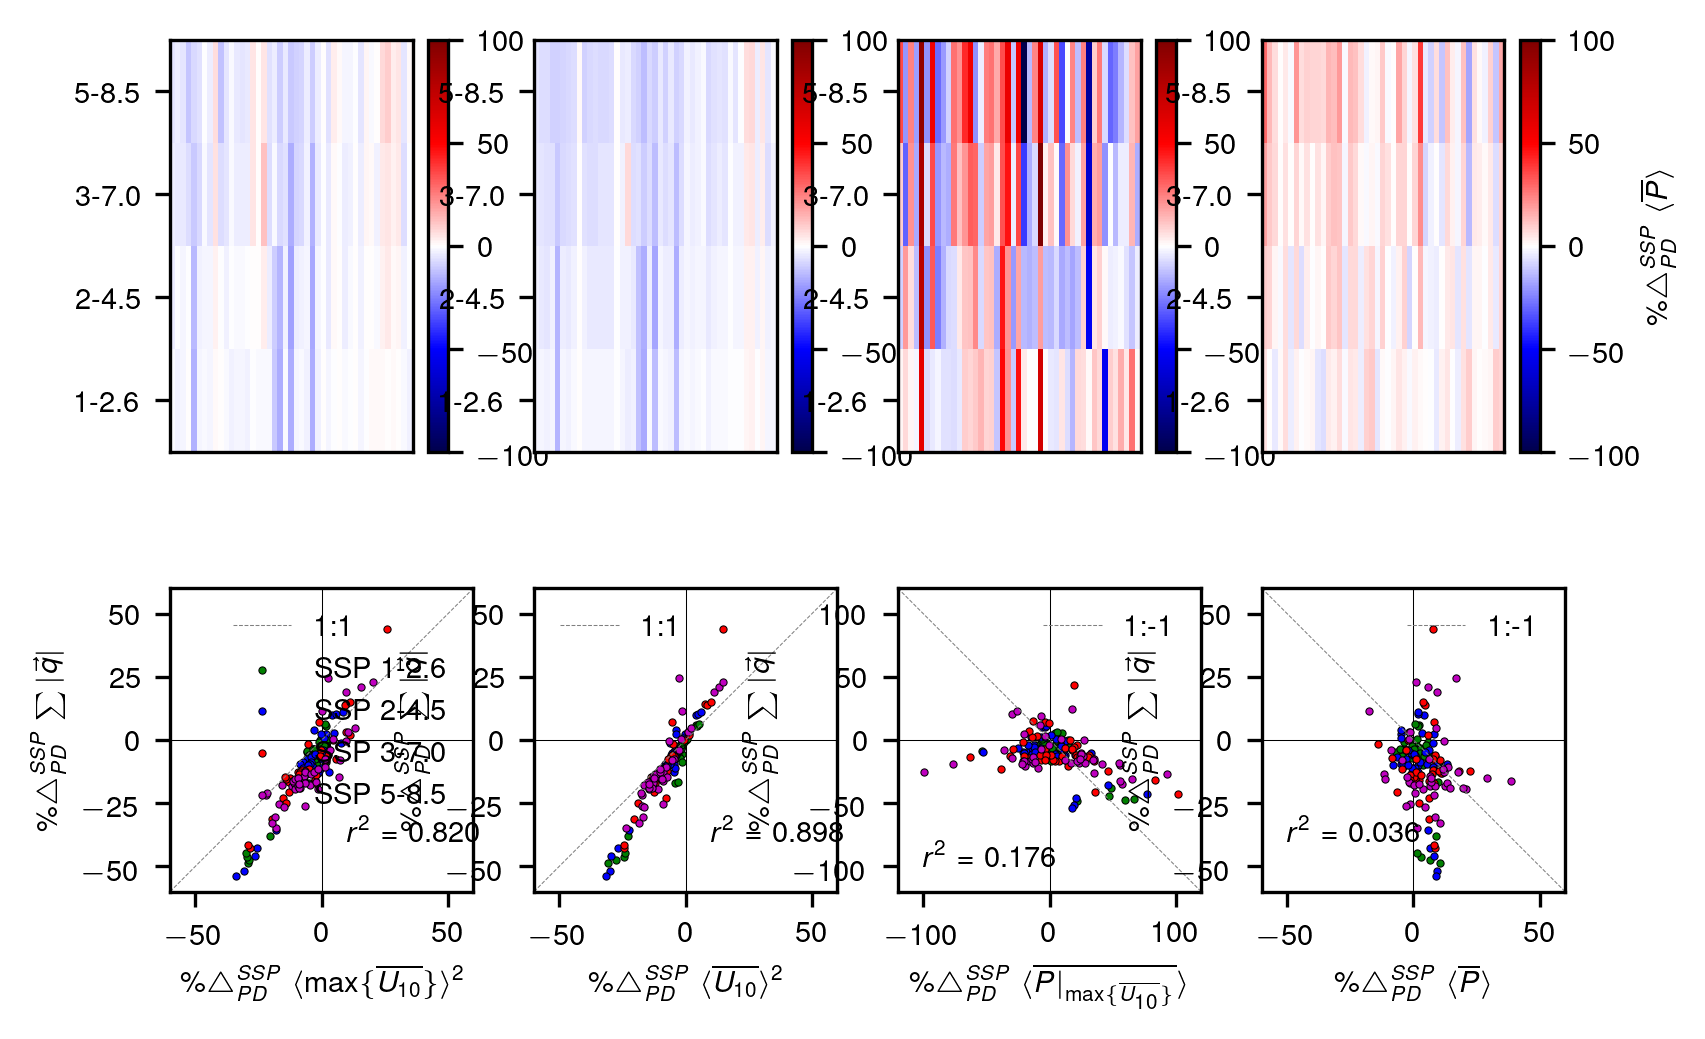

In [27]:
colors = ['k','g','b','r','m']

plt.subplot(241)
temp = 100*(trimonthmax_wspd_ens_mean_scenario_ends_dfmean[1:]-trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0])/trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
c5 = plt.colorbar()
c5.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\max\{\\overline{U_{10}}\}\\rangle$',labelpad=-1)

plt.subplot(242)
temp = 100*(np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[1:]-np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[0])/np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
c5 = plt.colorbar()
c5.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\overline{U_{10}}\\rangle$',labelpad=-1)

plt.subplot(243)
temp = 100*(pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[1:]-pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0])/pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
c5 = plt.colorbar()
c5.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle \\overline{P|_{\\max\{\\overline{U_{10}}\}}}\\rangle$',labelpad=-1)

plt.subplot(244)
temp = 100*(np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[1:]-np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[0])/np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
c5 = plt.colorbar()
c5.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle \\overline{P}\\rangle$',labelpad=-1)

plt.subplot(245)
temp0 = 100*(trimonthmax_wspd_ens_mean_scenario_ends_dfmean[1:]**2-trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0]**2)/trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0]**2
temp1 = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw,label=labels[i+1])
plt.plot([-60,60],[-60,60],'--',c='grey',lw=lw,label='1:1')
plt.plot([60,-60],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[60,-60],c='k',lw=lw,zorder=-1)
plt.text(10,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False)
plt.axis('square')
plt.xlim(-60,60)
plt.ylim(-60,60)
plt.xlabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\max\{\\overline{U_{10}}\}\\rangle^2$')
plt.ylabel('\%$\\triangle_{PD}^{SSP}$  $\\sum|\\vec{q}|$')

plt.subplot(246)
temp0 = 100*(np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[1:]**2-np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[0]**2)/np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[0]**2
temp1 = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([-60,60],[-60,60],'--',c='grey',lw=lw,label='1:1')
plt.plot([60,-60],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[60,-60],c='k',lw=lw,zorder=-1)
plt.text(10,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False)
plt.axis('square')
plt.xlim(-60,60)
plt.ylim(-60,60)
plt.xlabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\overline{U_{10}}\\rangle^2$')
plt.ylabel('\%$\\triangle_{PD}^{SSP}$  $\\sum|\\vec{q}|$')

plt.subplot(247)
temp0 = 100*(pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[1:]-pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0])/pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0]
temp1 = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([120,-120],[-120,120],'--',c='grey',lw=lw,label='1:-1')
plt.plot([120,-120],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[120,-120],c='k',lw=lw,zorder=-1)
plt.text(-100,-100,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False)
plt.axis('square')
plt.xlim(-120,120)
plt.ylim(-120,120)
plt.xlabel('\%$\\triangle_{PD}^{SSP}$  $\\langle \\overline{P|_{\\max\{\\overline{U_{10}}\}}}\\rangle$')
plt.ylabel('\%$\\triangle_{PD}^{SSP}$  $\\sum|\\vec{q}|$')

plt.subplot(248)
temp0 = 100*(np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[1:]-np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[0])/np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[0]
temp1 = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([60,-60],[-60,60],'--',c='grey',lw=lw,label='1:-1')
plt.plot([60,-60],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[60,-60],c='k',lw=lw,zorder=-1)
plt.text(-50,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False)
plt.axis('square')
plt.xlim(-60,60)
plt.ylim(-60,60)
plt.xlabel('\%$\\triangle_{PD}^{SSP}$  $\\langle \\overline{P}\\rangle$')
plt.ylabel('\%$\\triangle_{PD}^{SSP}$  $\\sum|\\vec{q}|$')

# Figure 1

In [28]:
def get_tiles(lonM,latM):
    lonD = np.diff(lonM)[0]/2
    latD = np.diff(latM)[0]/2

    tiles = [[None for _ in range(len(latM))] for _ in range(len(lonM))]

    for i in range(len(lonM)):
        for j in range(len(latM)):
            tiles[i][j] = Polygon([[lonM[i]+lonD,latM[j]+latD],
                                   [lonM[i]-lonD,latM[j]+latD],
                                   [lonM[i]-lonD,latM[j]-latD],
                                   [lonM[i]+lonD,latM[j]-latD]])

    return tiles

In [29]:
landmask  = np.asarray(xr.open_dataset(directory + 'tslsi_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-18501231.nc').tslsi)[0]
landmask  = landmask/landmask*1
oceanmask = np.copy(landmask)
oceanmask[np.isnan(oceanmask)] = 2

globlat,globlon = get_latlon()

mapvar = np.mean(wspd_ens_mean[-1],axis=tuple((0,1)))-np.mean(wspd_ens_mean[0],axis=tuple((0,1)))
mapvar = np.hstack((mapvar[:,(globlon>180)],mapvar[:,(globlon<=180)]))

mapocean = oceanmask
mapocean = np.hstack((mapocean[:,(globlon>180)],mapocean[:,(globlon<=180)]))

maplon = np.hstack((globlon[(globlon>180)]-360,globlon[(globlon<=180)]))
maplat = globlat

scenarioind = 0
Nyears = 10
dfind = 1
tileind = 20

q,_ = load_years(scenarios[scenarioind],years[scenarioind][-Nyears:])
tileq = q[0,:,:,np.argwhere(Dunefield_num==dfind)[tileind][0]]
del q

tiles = get_tiles(globlon,globlat)

temptiles = Dunefield_tileinds[Dunefield_num==dfind]

tilecolor = mean_summq_scenario_ends[scenarioind,Dunefield_num==dfind]

tempqm = tileq[0]
tempqa = tileq[1]
tempqm = tempqm[~np.isnan(tempqa)]
tempqa = tempqa[~np.isnan(tempqa)]

msqE_mean = np.sum(tempqm*np.exp(1j*tempqa).real)/len(tileq[0])
msqN_mean = np.sum(tempqm*np.exp(1j*tempqa).imag)/len(tileq[0])

smqE_mean = np.hstack([0,np.cumsum(tempqm*np.exp(1j*tempqa).real)])/len(tileq[0])
smqN_mean = np.hstack([0,np.cumsum(tempqm*np.exp(1j*tempqa).imag)])/len(tileq[0])

<ipython-input-30-3861f4f32523>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc0 = plt.pcolor(maplon,maplat,mapvar,vmin=-2,vmax=2,cmap=cmap,zorder=-1,rasterized=True)
<ipython-input-30-3861f4f32523>:8: UserWarning: No contour levels were found within the data range.
  plt.contour(maplon,maplat,mapocean,[1],linewidths=lw,colors='k')


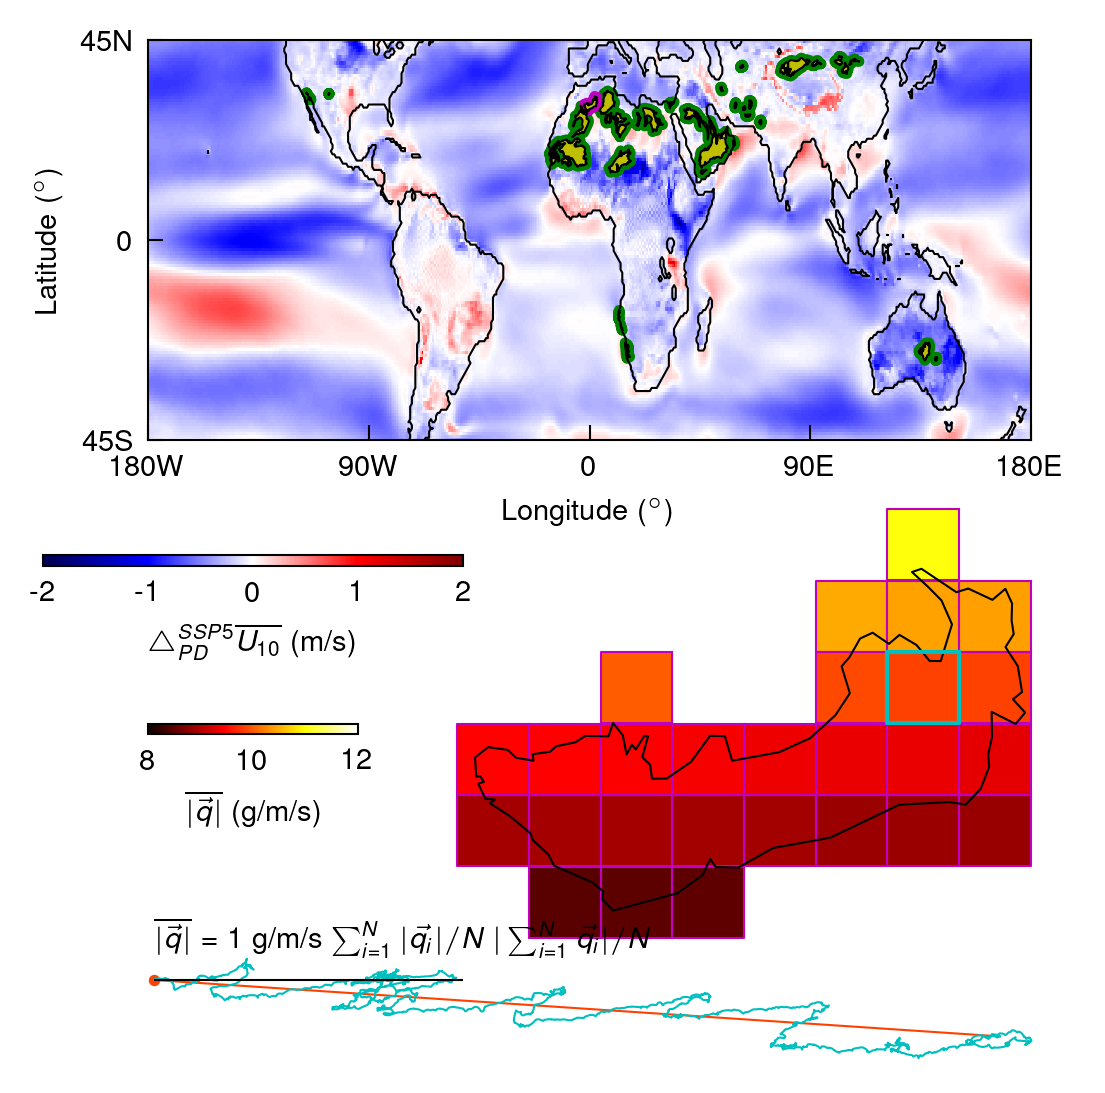

In [30]:
lw = 0.5

fig = plt.gcf()

ax0 = fig.add_axes([0.12,0.6,0.84,0.38])

pc0 = plt.pcolor(maplon,maplat,mapvar,vmin=-2,vmax=2,cmap=cmap,zorder=-1,rasterized=True)
plt.contour(maplon,maplat,mapocean,[1],linewidths=lw,colors='k')

scale = 2
for i in range(len(dfs)):
    x,y = dfs[i].exterior.xy
    plt.plot(np.asarray(x)-180,y, color='k', lw=lw)
    plt.fill(np.asarray(x)-180,y, color='y', lw=0,zorder=1)
    if i==dfind:
        plt.plot(np.asarray(x)-180,y, color='m', lw=lw*5,zorder=0,solid_capstyle='round')
    else:
        plt.plot(np.asarray(x)-180,y, color='g', lw=lw*5,zorder=-1, solid_capstyle='round')

plt.ylim(-45,45)
plt.xlim(-180,180)
ax0.set_ylabel('Latitude ($^\\circ$)')
ax0.set_xlabel('Longitude ($^\\circ$)')
ax0.set_xticks([-180,-90,0,90,180])
ax0.set_xticklabels(['180W','90W','0','90E','180E'])
ax0.set_yticks([-45,0,45])
ax0.set_yticklabels(['45S','0','45N'])

ax1 = fig.add_axes([0.387,0.03,0.6,0.6])

vmin = 8/1e+3
vmax = 12/1e+3
colors = [cm.hot(x) for x in (tilecolor-vmin)/(vmax-vmin)]
sc1 = plt.scatter(None,None,c=0,vmin=vmin*1e+3,vmax=vmax*1e+3,cmap='hot')

for k in range(len(temptiles)):
    plt.fill(np.asarray(tiles[temptiles[k][0]][temptiles[k][1]].exterior.coords.xy[0])-180,
                    tiles[temptiles[k][0]][temptiles[k][1]].exterior.coords.xy[1],color=colors[k],lw=0,zorder=-1)
    if k==tileind:
        plt.plot(np.asarray(tiles[temptiles[k][0]][temptiles[k][1]].exterior.coords.xy[0])-180,
                tiles[temptiles[k][0]][temptiles[k][1]].exterior.coords.xy[1], color='c', lw=lw*2,zorder=2)
    else:    
        plt.plot(np.asarray(tiles[temptiles[k][0]][temptiles[k][1]].exterior.coords.xy[0])-180,
                    tiles[temptiles[k][0]][temptiles[k][1]].exterior.coords.xy[1], color='m', lw=lw,zorder=-1)
x,y = dfs[dfind].exterior.xy
plt.plot(np.asarray(x)-180,y, color='k', lw=lw,zorder=1)

ax1.axis('off')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([0.084,-0.4,0.918,0.918])

plt.scatter(0,0,color=colors[tileind],s=S)
plt.plot([0,msqE_mean*1e+3],[0,msqN_mean*1e+3],color=colors[tileind],lw=lw)
plt.plot(smqE_mean*1e+3,smqN_mean*1e+3,'c',lw=lw)
plt.plot([0,1],[0,0],'k',lw=lw, solid_capstyle='butt')
plt.text(0,0.1,'$\\overline{|\\vec{q}|}=1$ g/m/s $\\sum_{i=1}^N|\\vec{q_i}|/N$ $|\\sum_{i=1}^N\\vec{q_i}|/N$')
ax2.axis('off')
ax2.set_aspect('equal', 'box')

cbar0_ax = fig.add_axes([0.02,0.48,0.4,0.01])
c0 = fig.colorbar(pc0, orientation='horizontal',cax=cbar0_ax, ticks=[-2,-1,0,1,2])
cbar0_ax.xaxis.set_label_position('bottom')
cbar0_ax.xaxis.set_ticks_position('bottom')
c0.set_label('$\\triangle_{PD}^{SSP5} \\overline{U_{10}}$ (m/s)',fontsize=fs)
c0.ax.set_xticklabels(['-2','-1','0','1','2'],fontsize=fs)
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)

cbar1_ax = fig.add_axes([0.12,0.32,0.2,0.01])
c1 = fig.colorbar(sc1, orientation='horizontal',cax=cbar1_ax, ticks=[8,10,12])
cbar1_ax.xaxis.set_label_position('bottom')
cbar1_ax.xaxis.set_ticks_position('bottom')
c1.set_label('$\\overline{|\\vec{q}|}$ (g/m/s)',fontsize=fs)
c1.ax.set_xticklabels(['8','10','12'],fontsize=fs)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw)

fig.set_size_inches(89/25.4,89/25.4, forward=True)
plt.savefig('figures/fig1.pdf',dpi=600)
plt.savefig('figures/fig1.png',dpi=600)

# Figure 2

In [31]:
i = 0
j = -1
k = 0
l = 3
ind0 = 1296
ind1 = 21
ind2 = 33
inds = range(ind0,int(ind0+10*24/3+1))
q,t = load_years(scenarios[i],years[i][j:])

Q1 = np.sum(q[k,0,inds[ind2:],l])*np.diff(t)[0]
Q0 = np.sum(q[k,0,inds[:ind2],l])*np.diff(t)[0]
T0 = (t[inds[ind2]]-t[inds[ind1]])

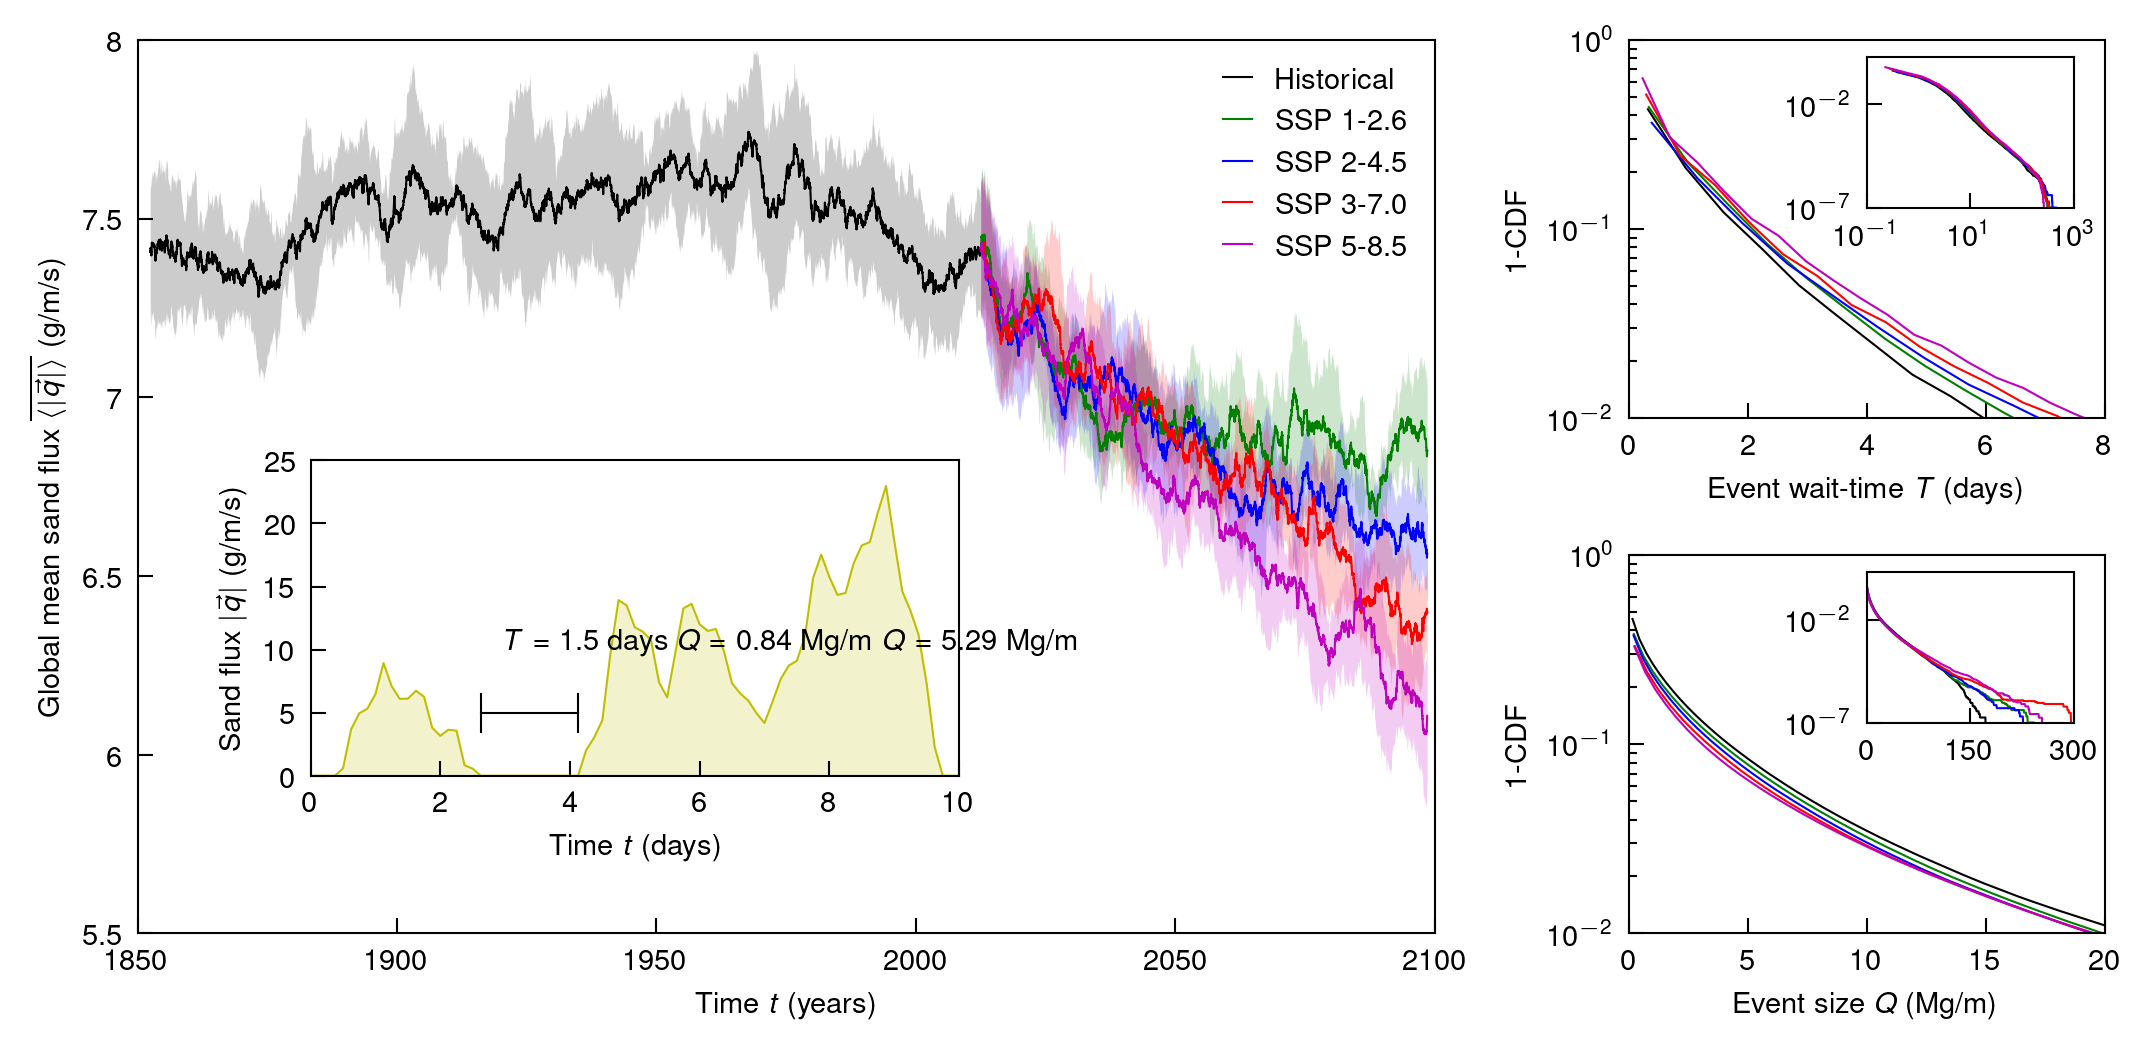

In [32]:
colors = ['k','g','b','r','m']
labels = ['Historical','SSP 1-2.6','SSP 2-4.5','SSP 3-7.0','SSP 5-8.5']
lw = 0.5
alpha = 0.2
h = 5

fig = plt.gcf()

ax0 = fig.add_axes([0.06,0.11,0.6,0.85])

for i in range(len(scenarios)):
    plt.plot(ts_scenarios_smoothed[i]*s2yr+1970,qm_ensmean_globmeans_scenarios_smoothed[i]*1e+3,lw=lw,color=colors[i],label=labels[i])
    plt.fill_between(ts_scenarios_smoothed[i]*s2yr+1970,
                     (qm_ensmean_globmeans_scenarios_smoothed[i]-qm_ens_globstd_scenarios_smoothed[i])*1e+3,
                     (qm_ensmean_globmeans_scenarios_smoothed[i]+qm_ens_globstd_scenarios_smoothed[i])*1e+3,lw=0,alpha=alpha,color=colors[i],rasterized=True)
    
plt.legend(frameon=False,handlelength=1)
plt.xlim(1850,2100)
plt.ylim(5.5,8)
plt.xlabel('Time $t$ (years)')
plt.ylabel('Global mean sand flux $\\overline{\\langle|\\vec{q}|\\rangle}$ (g/m/s)')
ax0.set_yticks([5.5,6,6.5,7,7.5,8])
ax0.set_yticklabels(['5.5','6','6.5','7','7.5','8'])

ax01 = fig.add_axes([0.14,0.26,0.3,0.3])

plt.plot((t[inds]-t[ind0])*s2yr*365,q[k,0,inds,l]*1e+3,'y',lw=lw)
plt.fill_between((t[inds]-t[ind0])*s2yr*365,q[k,0,inds,l]*1e+3,color='y',alpha=alpha,lw=0)
plt.plot((t[inds[ind1:ind2+1]]-t[ind0])*s2yr*365,t[inds[ind1:ind2+1]]/t[inds[ind1:ind2+1]]*h,'k',lw=lw)
plt.plot([(t[inds[ind1]]-t[ind0])*s2yr*365,(t[inds[ind1]]-t[ind0])*s2yr*365],[h-1.5,h+1.5],'k',lw=lw)
plt.plot([(t[inds[ind2]]-t[ind0])*s2yr*365,(t[inds[ind2]]-t[ind0])*s2yr*365],[h-1.5,h+1.5],'k',lw=lw)
plt.text(3,10,'$T = %.1f$ days $Q = %.2f$ Mg/m $Q = %.2f$ Mg/m'%((T0*s2yr*365),(Q0*1e-3),(Q1*1e-3)))
plt.xlim(0,10)
plt.ylim(0,25)
plt.xlabel('Time $t$ (days)')
plt.ylabel('Sand flux $|\\vec{q}|$ (g/m/s)')


ax1 = fig.add_axes([0.75,0.6,0.22,0.36])

for i in range(len(scenarios)):
    if density:
        if cdf:
            tempy = 1-np.cumsum(qet_counts_globscenario_ends[i]*np.diff(qet_bins_globscenario_ends[i]))
        else:
            tempy = qet_counts_globscenario_ends[i]
    else:
        tempy = qet_counts_globscenario_ends[i]/np.sum(qet_counts_globscenario_ends[i])
    if tscale=='lin':
        tempx = qet_bins_globscenario_ends[i][1:]-np.diff(qet_bins_globscenario_ends[i])[0]/2
    elif tscale=='log':
        tempx = 10**(np.log10(qet_bins_globscenario_ends[i])[1:]-np.diff(np.log10(qet_bins_globscenario_ends[i]))[0]/2)

    plt.plot(tempx[tempy>0]*s2yr*365,tempy[tempy>0],color=colors[i],lw=lw)

plt.yscale('log')
plt.ylim(1e-2,1e+0)
plt.xlim(0,8)
plt.xlabel('Event wait-time $T$ (days)')
plt.ylabel('1-CDF')

ax11 = fig.add_axes([0.75+0.11,0.6+0.2,0.22/2.3,0.36/2.5])

for i in range(len(scenarios)):
    if density:
        if cdf:
            tempy = 1-np.cumsum(qet_counts_globscenario_ends[i]*np.diff(qet_bins_globscenario_ends[i]))
        else:
            tempy = qet_counts_globscenario_ends[i]
    else:
        tempy = qet_counts_globscenario_ends[i]/np.sum(qet_counts_globscenario_ends[i])
    if tscale=='lin':
        tempx = qet_bins_globscenario_ends[i][1:]-np.diff(qet_bins_globscenario_ends[i])[0]/2
    elif tscale=='log':
        tempx = 10**(np.log10(qet_bins_globscenario_ends[i])[1:]-np.diff(np.log10(qet_bins_globscenario_ends[i]))[0]/2)

    plt.plot(tempx[tempy>0]*s2yr*365,tempy[tempy>0],color=colors[i],lw=lw)

plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-7,2e+0)
plt.xlim(1e-1,1e+3)

ax2 = fig.add_axes([0.75,0.11,0.22,0.36])

for i in range(len(scenarios)):
    if density:
        if cdf:
            tempy = 1-np.cumsum(qem_counts_globscenario_ends[i]*np.diff(qem_bins_globscenario_ends[i]))
        else:
            tempy = qem_counts_globscenario_ends[i]
    else:
        tempy = qem_counts_globscenario_ends[i]/np.sum(qem_counts_globscenario_ends[i])
    if mscale=='lin':
        tempx = qem_bins_globscenario_ends[i][1:]-np.diff(qem_bins_globscenario_ends[i])[0]/2
    elif mscale=='log':
        tempx = 10**(np.log10(qem_bins_globscenario_ends[i])[1:]-np.diff(np.log10(qem_bins_globscenario_ends[i]))[0]/2)

    plt.plot(tempx[tempy>0]*1e-3,tempy[tempy>0],color=colors[i],lw=lw)

plt.yscale('log')
plt.ylim(1e-2,1e+0)
plt.xlim(0,20)
plt.xlabel('Event size $Q$ (Mg/m)')
plt.ylabel('1-CDF')

ax21 = fig.add_axes([0.75+0.11,0.11+0.2,0.22/2.3,0.36/2.5])

for i in range(len(scenarios)):
    if density:
        if cdf:
            tempy = 1-np.cumsum(qem_counts_globscenario_ends[i]*np.diff(qem_bins_globscenario_ends[i]))
        else:
            tempy = qem_counts_globscenario_ends[i]
    else:
        tempy = qem_counts_globscenario_ends[i]/np.sum(qem_counts_globscenario_ends[i])
    if mscale=='lin':
        tempx = qem_bins_globscenario_ends[i][1:]-np.diff(qem_bins_globscenario_ends[i])[0]/2
    elif mscale=='log':
        tempx = 10**(np.log10(qem_bins_globscenario_ends[i])[1:]-np.diff(np.log10(qem_bins_globscenario_ends[i]))[0]/2)

    plt.plot(tempx[tempy>0]*1e-3,tempy[tempy>0],color=colors[i],lw=lw)

plt.yscale('log')
plt.ylim(1e-7,2e+0)
plt.xlim(0,300)
ax21.set_xticks([0,150,300])
ax21.set_xticklabels(['0','150','300'])

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax01.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax01.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax11.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax11.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax21.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax21.spines[axis].set_linewidth(lw) 
    
fig.set_size_inches(183/25.4,89/25.4, forward=True)
plt.savefig('figures/fig2.pdf',dpi=600)
plt.savefig('figures/fig2.png',dpi=600)

# Figure 3

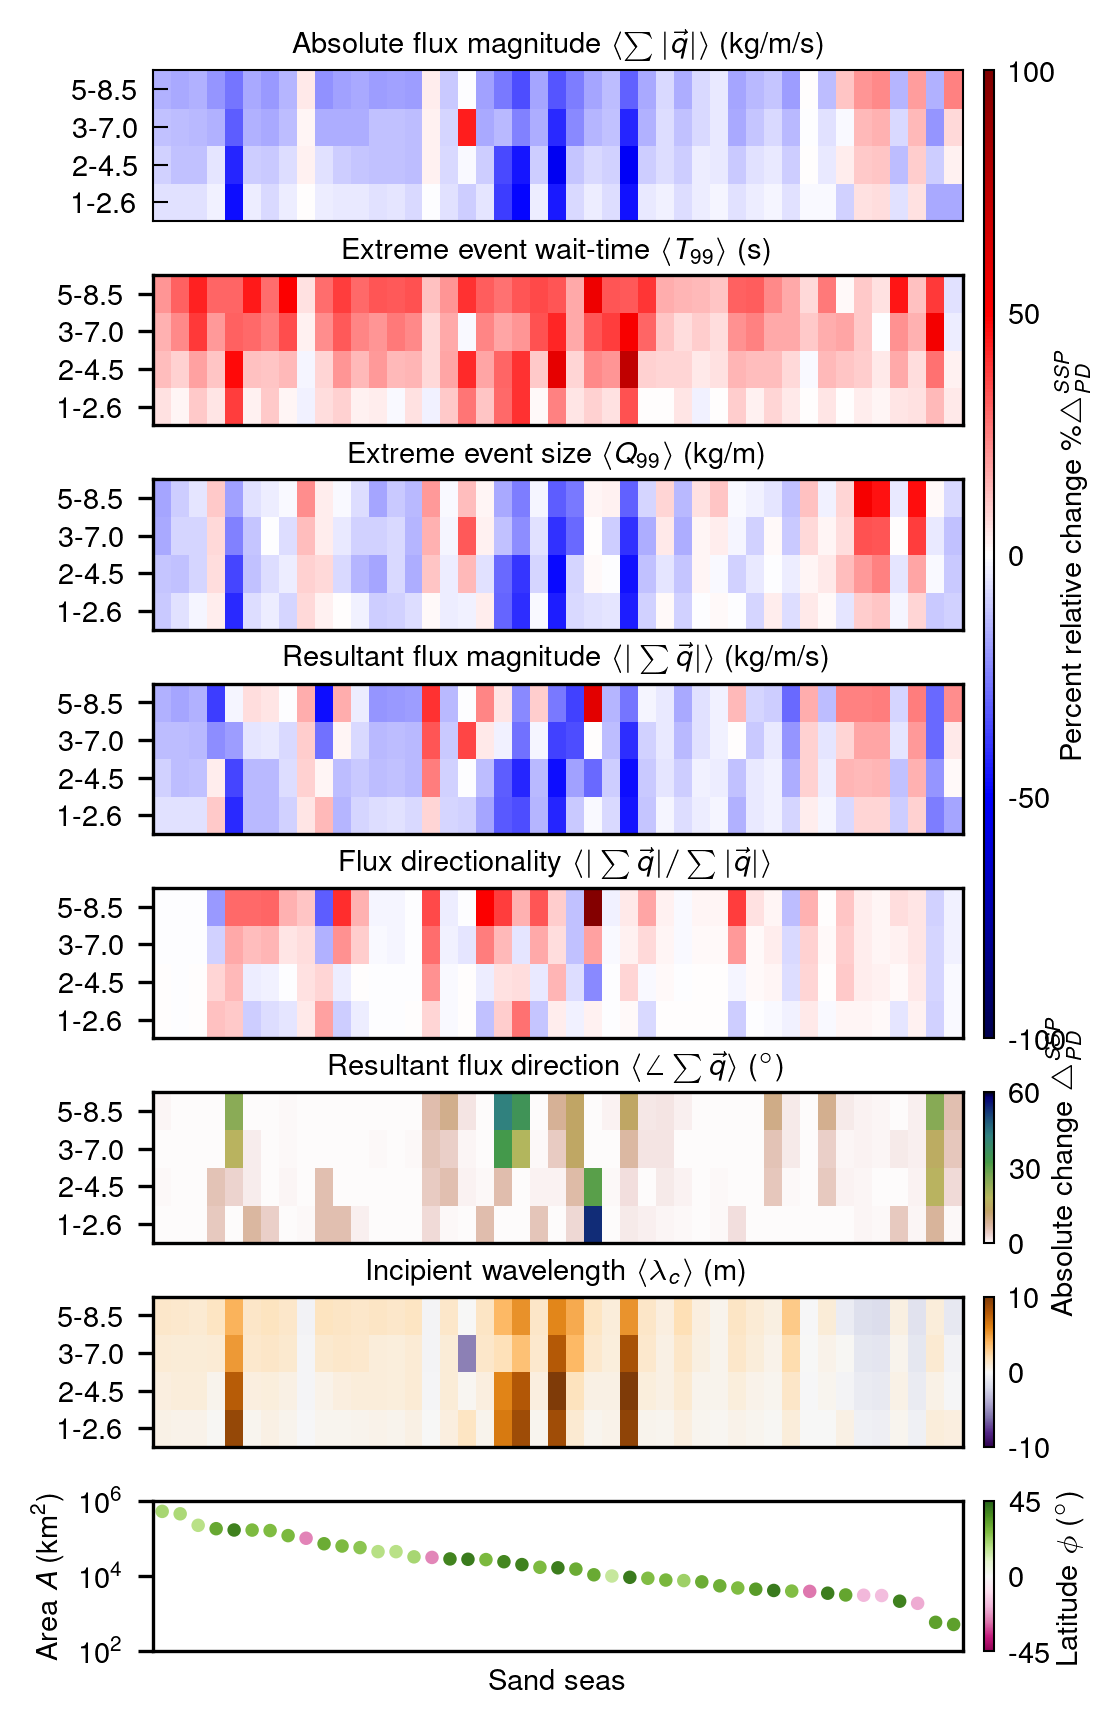

In [33]:
cmap = 'seismic'
cmap1 = 'PuOr_r'
cmap2 = 'PiYG'
S = 5

boty = 0.025
lefx = 0.105
bufy = 0.032
dely = 0.0895
delx = 0.77

fig = plt.gcf()

ax0 = fig.add_axes([lefx,boty+(bufy+dely)*7,delx,dely])

temp = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
pc0 = plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.title('Absolute flux magnitude $\\langle\\sum|\\vec{q}|\\rangle$ (kg/m/s)',fontsize=fs,pad=4)
# c0 = plt.colorbar()
# c0.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}\\langle\\sum|\\vec{q}|\\rangle$',labelpad=2)

ax1 = fig.add_axes([lefx,boty+(bufy+dely)*6,delx,dely])

temp = 100*(qet_params_scenario_ends_dfmean[1:]-qet_params_scenario_ends_dfmean[0])/qet_params_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.title('Extreme event wait-time $\\langle T_{99}\\rangle$ (s)',fontsize=fs,pad=4)
# c1 = plt.colorbar()
# c1.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}\\langle T_{99}\\rangle$',labelpad=2)

ax2 = fig.add_axes([lefx,boty+(bufy+dely)*5,delx,dely])

temp = 100*(qem_params_scenario_ends_dfmean[1:]-qem_params_scenario_ends_dfmean[0])/qem_params_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.title('Extreme event size $\\langle Q_{99}\\rangle$ (kg/m)',fontsize=fs,pad=4)
# c2 = plt.colorbar()
# c2.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}\\langle Q_{99}\\rangle$',labelpad=2)

ax3 = fig.add_axes([lefx,boty+(bufy+dely)*4,delx,dely])

temp = 100*(mean_msumqm_scenario_ends_dfmean[1:]-mean_msumqm_scenario_ends_dfmean[0])/mean_msumqm_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.title('Resultant flux magnitude $\\langle|\\sum\\vec{q}|\\rangle$ (kg/m/s)',fontsize=fs,pad=4)
# c3 = plt.colorbar()
# c3.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}\\langle|\\sum\\vec{q}|\\rangle$',labelpad=2)

ax4 = fig.add_axes([lefx,boty+(bufy+dely)*3,delx,dely])

temp = 100*(mean_fd_scenario_ends_dfmean[1:]-mean_fd_scenario_ends_dfmean[0])/mean_fd_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.title('Flux directionality $\\langle|\\sum\\vec{q}|/\\sum|\\vec{q}|\\rangle$',fontsize=fs,pad=4)
# c4 = plt.colorbar()
# c4.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}\\langle\\frac{|\\sum\\vec{q}|}{\\sum|\\vec{q}|}\\rangle$',labelpad=-1)

ax5 = fig.add_axes([lefx,boty+(bufy+dely)*2,delx,dely])

temp = (mean_msumqa_scenario_ends_dfmean[1:]-mean_msumqa_scenario_ends_dfmean[0])*180/np.pi
pc5 = plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap='gist_earth_r',vmin=0,vmax=60,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.title('Resultant flux direction $\\langle\\angle\\sum\\vec{q}\\rangle$ ($^\\circ$)',fontsize=fs,pad=4)
# c5 = plt.colorbar(ticks=[0,30,60])
# c5.ax.set_yticklabels(['$0^\\circ$','$30^\\circ$','$60^\\circ$'],fontsize=fs)
# c5.ax.set_ylabel('$\\triangle_{PD}^{SSP}\\langle\\angle\\sum\\vec{q}\\rangle$',labelpad=8.3)

ax6 = fig.add_axes([lefx,boty+(bufy+dely)*1,delx,dely])

temp = get_wavel(get_usfromqm(mean_summq_scenario_ends_dfmean[1:]))-get_wavel(get_usfromqm(mean_summq_scenario_ends_dfmean[0]))
pc6 = plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap1,vmin=-10,vmax=10,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
plt.title('Incipient wavelength $\\langle\\lambda_c\\rangle$ (m)',fontsize=fs,pad=4)
# c6 = plt.colorbar()
# c6.ax.set_ylabel('$\\triangle_{PD}^{SSP}\\langle\\lambda_c\\rangle$ (m)',labelpad=6)

ax7 = fig.add_axes([lefx,boty+(bufy+dely)*0,delx,dely])

sc7 = plt.scatter(np.arange(Ndunefields)+0.5,df_area[np.argsort(df_area)[::-1]]*1e-6,c=df_avlat[np.argsort(df_area)[::-1]],s=S,cmap=cmap2,vmin=-45,vmax=45,rasterized=True)
plt.yscale('log')
plt.xlim(0,Ndunefields)
plt.xticks([])
plt.yticks([10**2,10**4,10**6])
plt.ylabel('Area $A$ (km$^2$)')
plt.xlabel('Sand seas')

cbar8_ax = fig.add_axes([0.895,boty+(bufy+dely)*3,0.01,(bufy+dely)*4+dely])
c8 = fig.colorbar(pc0, orientation='vertical',cax=cbar8_ax, ticks=[-100,-50,0,50,100])
cbar8_ax.yaxis.set_label_position('right')
cbar8_ax.yaxis.set_ticks_position('right')
c8.set_label('Percent relative change \%$\\triangle_{PD}^{SSP}$',fontsize=fs,labelpad=-3)
c8.ax.set_yticklabels(['-100','-50','0','50','100'],fontsize=fs)
c8.ax.tick_params(width=0,which='both',direction='in')
c8.outline.set_linewidth(lw)

cbar9_ax = fig.add_axes([0.895,boty+(bufy+dely)*2,0.01,(bufy+dely)*0+dely])
c9 = fig.colorbar(pc5, orientation='vertical',cax=cbar9_ax, ticks=[0,30,60])
cbar9_ax.yaxis.set_label_position('right')
cbar9_ax.yaxis.set_ticks_position('right')
c9.set_label('Absolute change $\\triangle_{PD}^{SSP}$',fontsize=fs,labelpad=1)
c9.ax.set_yticklabels(['0','30','60'],fontsize=fs)
c9.ax.tick_params(width=0,which='both',direction='in')
c9.outline.set_linewidth(lw)

cbar10_ax = fig.add_axes([0.895,boty+(bufy+dely)*1,0.01,(bufy+dely)*0+dely])
c10 = fig.colorbar(pc6, orientation='vertical',cax=cbar10_ax, ticks=[-10,0,10])
cbar10_ax.yaxis.set_label_position('right')
cbar10_ax.yaxis.set_ticks_position('right')
c10.ax.set_yticklabels(['-10','0','10'],fontsize=fs)
c10.ax.tick_params(width=0,which='both',direction='in')
c10.outline.set_linewidth(lw)

cbar11_ax = fig.add_axes([0.895,boty+(bufy+dely)*0,0.01,(bufy+dely)*0+dely])
c11 = fig.colorbar(sc7, orientation='vertical',cax=cbar11_ax, ticks=[-45,0,45])
cbar11_ax.yaxis.set_label_position('right')
cbar11_ax.yaxis.set_ticks_position('right')
c11.set_label('Latitude $\\phi$ ($^\\circ$)',fontsize=fs,labelpad=1)
c11.ax.set_yticklabels(['-45','0','45'],fontsize=fs)
c11.ax.tick_params(width=0,which='both',direction='in')
c11.outline.set_linewidth(lw)


ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
# c0.ax.tick_params(width=0,which='both',direction='in')
# c0.outline.set_linewidth(lw)
# ax1.tick_params(width=lw,which='both',direction='in')
# for axis in ['top','bottom','left','right']:
#     ax1.spines[axis].set_linewidth(lw) 
# c1.ax.tick_params(width=0,which='both',direction='in')
# c1.outline.set_linewidth(lw)
# ax2.tick_params(width=lw,which='both',direction='in')
# for axis in ['top','bottom','left','right']:
#     ax2.spines[axis].set_linewidth(lw) 
# c2.ax.tick_params(width=0,which='both',direction='in')
# c2.outline.set_linewidth(lw)
# ax3.tick_params(width=lw,which='both',direction='in')
# for axis in ['top','bottom','left','right']:
#     ax3.spines[axis].set_linewidth(lw) 
# c3.ax.tick_params(width=0,which='both',direction='in')
# c3.outline.set_linewidth(lw)
# ax4.tick_params(width=lw,which='both',direction='in')
# for axis in ['top','bottom','left','right']:
#     ax4.spines[axis].set_linewidth(lw) 
# c4.ax.tick_params(width=0,which='both',direction='in')
# c4.outline.set_linewidth(lw)
# ax5.tick_params(width=lw,which='both',direction='in')
# for axis in ['top','bottom','left','right']:
#     ax5.spines[axis].set_linewidth(lw) 
# c5.ax.tick_params(width=0,which='both',direction='in')
# c5.outline.set_linewidth(lw)
# ax6.tick_params(width=lw,which='both',direction='in')
# for axis in ['top','bottom','left','right']:
#     ax6.spines[axis].set_linewidth(lw) 
# c6.ax.tick_params(width=0,which='both',direction='in')
# c6.outline.set_linewidth(lw)
# ax7.tick_params(width=lw,which='both',direction='in')
# for axis in ['top','bottom','left','right']:
#     ax7.spines[axis].set_linewidth(lw) 
# c7.ax.tick_params(width=0,which='both',direction='in')
# c7.outline.set_linewidth(lw)

fig.set_size_inches(89/25.4,89*1.6/25.4, forward=True)
plt.savefig('figures/fig3.pdf',dpi=600)
plt.savefig('figures/fig3.png',dpi=600)

# Figure 4

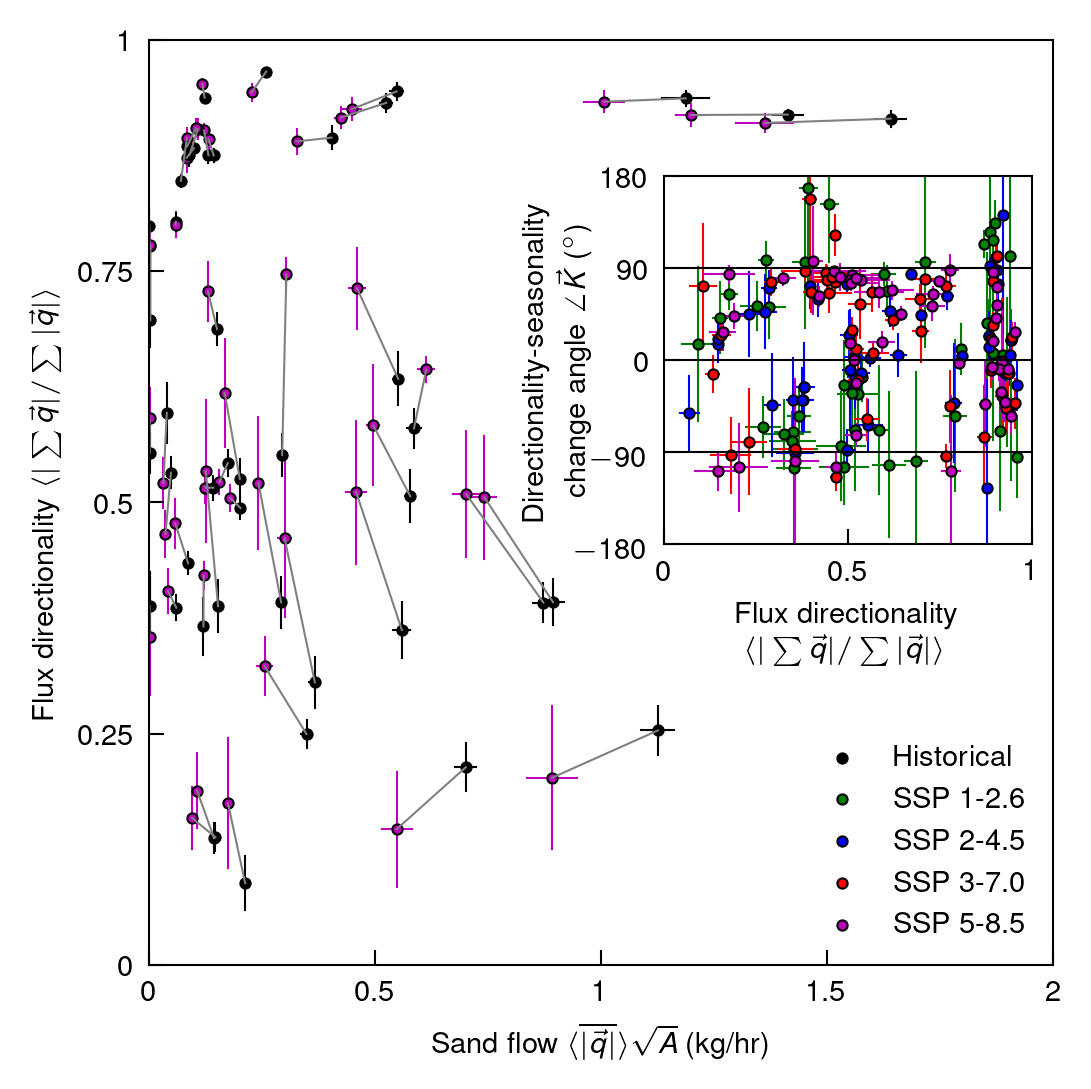

In [34]:
colors = ['k','g','b','r','m']
S = 6
lw = 0.5

fig = plt.gcf()

ax0 = fig.add_axes([0.12,0.1,0.86,0.88])

for i in range(Ndunefields):
    plt.scatter(df_area[i]**0.5*mean_summq_scenario_ends_dfmean[0,i]*s2hr,mean_fd_scenario_ends_dfmean[0,i],facecolor=colors[0],s=S,edgecolor='k',lw=lw,zorder=1)
    plt.scatter(df_area[i]**0.5*mean_summq_scenario_ends_dfmean[-1,i]*s2hr,mean_fd_scenario_ends_dfmean[-1,i],facecolor=colors[-1],s=S,edgecolor='k',lw=lw,zorder=1)
    plt.plot([df_area[i]**0.5*mean_summq_scenario_ends_dfmean[-1,i]*s2hr,df_area[i]**0.5*mean_summq_scenario_ends_dfmean[0,i]*s2hr],
             [mean_fd_scenario_ends_dfmean[-1,i],mean_fd_scenario_ends_dfmean[0,i]],c='grey',lw=lw,zorder=1)
    
    plt.plot([df_area[i]**0.5*(mean_summq_scenario_ends_dfmean[-1,i]-std_summq_scenario_ends_dfmean[-1,i])*s2hr,df_area[i]**0.5*(mean_summq_scenario_ends_dfmean[-1,i]+std_summq_scenario_ends_dfmean[-1,i])*s2hr],
             [mean_fd_scenario_ends_dfmean[-1,i],mean_fd_scenario_ends_dfmean[-1,i]],
             c=colors[-1],lw=lw,zorder=-1)
    plt.plot([df_area[i]**0.5*mean_summq_scenario_ends_dfmean[-1,i]*s2hr,df_area[i]**0.5*mean_summq_scenario_ends_dfmean[-1,i]*s2hr],
             [mean_fd_scenario_ends_dfmean[-1,i]-std_fd_scenario_ends_dfmean[-1,i],mean_fd_scenario_ends_dfmean[-1,i]+std_fd_scenario_ends_dfmean[-1,i]],
             c=colors[-1],lw=lw,zorder=-1)
    plt.plot([df_area[i]**0.5*(mean_summq_scenario_ends_dfmean[0,i]-std_summq_scenario_ends_dfmean[0,i])*s2hr,df_area[i]**0.5*(mean_summq_scenario_ends_dfmean[0,i]+std_summq_scenario_ends_dfmean[0,i])*s2hr],
             [mean_fd_scenario_ends_dfmean[0,i],mean_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw,zorder=-1)
    plt.plot([df_area[i]**0.5*mean_summq_scenario_ends_dfmean[0,i]*s2hr,df_area[i]**0.5*mean_summq_scenario_ends_dfmean[0,i]*s2hr],
             [mean_fd_scenario_ends_dfmean[0,i]-std_fd_scenario_ends_dfmean[0,i],mean_fd_scenario_ends_dfmean[0,i]+std_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw,zorder=-1)

for i in range(len(scenarios)):
    plt.scatter(-1,-1,facecolor=colors[i],s=S,edgecolor='k',lw=lw,label=labels[i])
    
plt.legend(frameon=False)
plt.ylim(0,1)
plt.xlim(0,2)
plt.xlabel('Sand flow $\\langle\\overline{|\\vec{q}|}\\rangle\\sqrt{A}$ (kg/hr)')
plt.ylabel('Flux directionality $\\langle|\\sum\\vec{q}|/\\sum|\\vec{q}|\\rangle$')
ax0.set_xticks([0,0.5,1,1.5,2])
ax0.set_xticklabels(['0','0.5','1','1.5','2'])
ax0.set_yticks([0,0.25,0.5,0.75,1])
ax0.set_yticklabels(['0','0.25','0.5','0.75','1'])

ax01 = fig.add_axes([0.61,0.5,0.35,0.35])

for i in range(1,len(scenarios)):
    
    plt.scatter(mean_fd_scenario_ends_dfmean[i],mean_fd_seasonscenario_ends_dfmean[i]*180/np.pi,facecolor=colors[i],s=S,edgecolor='k',lw=lw,zorder=1)
    
    plt.plot([mean_fd_scenario_ends_dfmean[i],
              mean_fd_scenario_ends_dfmean[i]],
             [mean_fd_seasonscenario_ends_dfmean[i]*180/np.pi-std_fd_seasonscenario_ends_dfmean[i]*180/np.pi,
              mean_fd_seasonscenario_ends_dfmean[i]*180/np.pi+std_fd_seasonscenario_ends_dfmean[i]*180/np.pi],
             c=colors[i],lw=lw,zorder=-1)
    plt.plot([mean_fd_scenario_ends_dfmean[i]-std_fd_scenario_ends_dfmean[i],
              mean_fd_scenario_ends_dfmean[i]+std_fd_scenario_ends_dfmean[i]],
             [mean_fd_seasonscenario_ends_dfmean[i]*180/np.pi,
              mean_fd_seasonscenario_ends_dfmean[i]*180/np.pi],
             c=colors[i],lw=lw,zorder=-1)
    
plt.plot([0,1],[0,0],'k',lw=lw)
plt.plot([0,1],[-90,-90],'k',lw=lw)
plt.plot([0,1],[90,90],'k',lw=lw)
plt.ylim(-180,180)
plt.xlim(0,1)
plt.xlabel('Flux directionality\n$\\langle|\\sum\\vec{q}|/\\sum|\\vec{q}|\\rangle$')
# plt.ylabel('$\\angle\\frac{\\triangle_{PD}^{SSP}\\langle|\\sum\\vec{q}|/\\sum|\\vec{q}|\\rangle}{\\triangle_{PD}^{SSP}\\max\{\\langle|\\vec{q}|\\rangle\}/\\sum\\langle|\\vec{q}|\\rangle}$',labelpad=-3)
plt.ylabel('Directionality-seasonality\n change angle $\\angle\\vec{K}$ ($^\\circ$)',labelpad=-4)

ax01.set_xticks([0,0.5,1])
ax01.set_xticklabels(['0','0.5','1'])
ax01.set_yticks([-180,-90,0,90,180])
# ax01.set_yticklabels(['$-180^\\circ$','$-90^\\circ$','$0^\\circ$','$90^\\circ$','$180^\\circ$'])
ax01.set_yticklabels(['$-180$','$-90$','0','90','180'])

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax01.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax01.spines[axis].set_linewidth(lw) 

fig.set_size_inches(89/25.4,89/25.4, forward=True)
plt.savefig('figures/fig4.pdf',dpi=600)
plt.savefig('figures/fig4.png',dpi=600)

# Extended Data Figure A

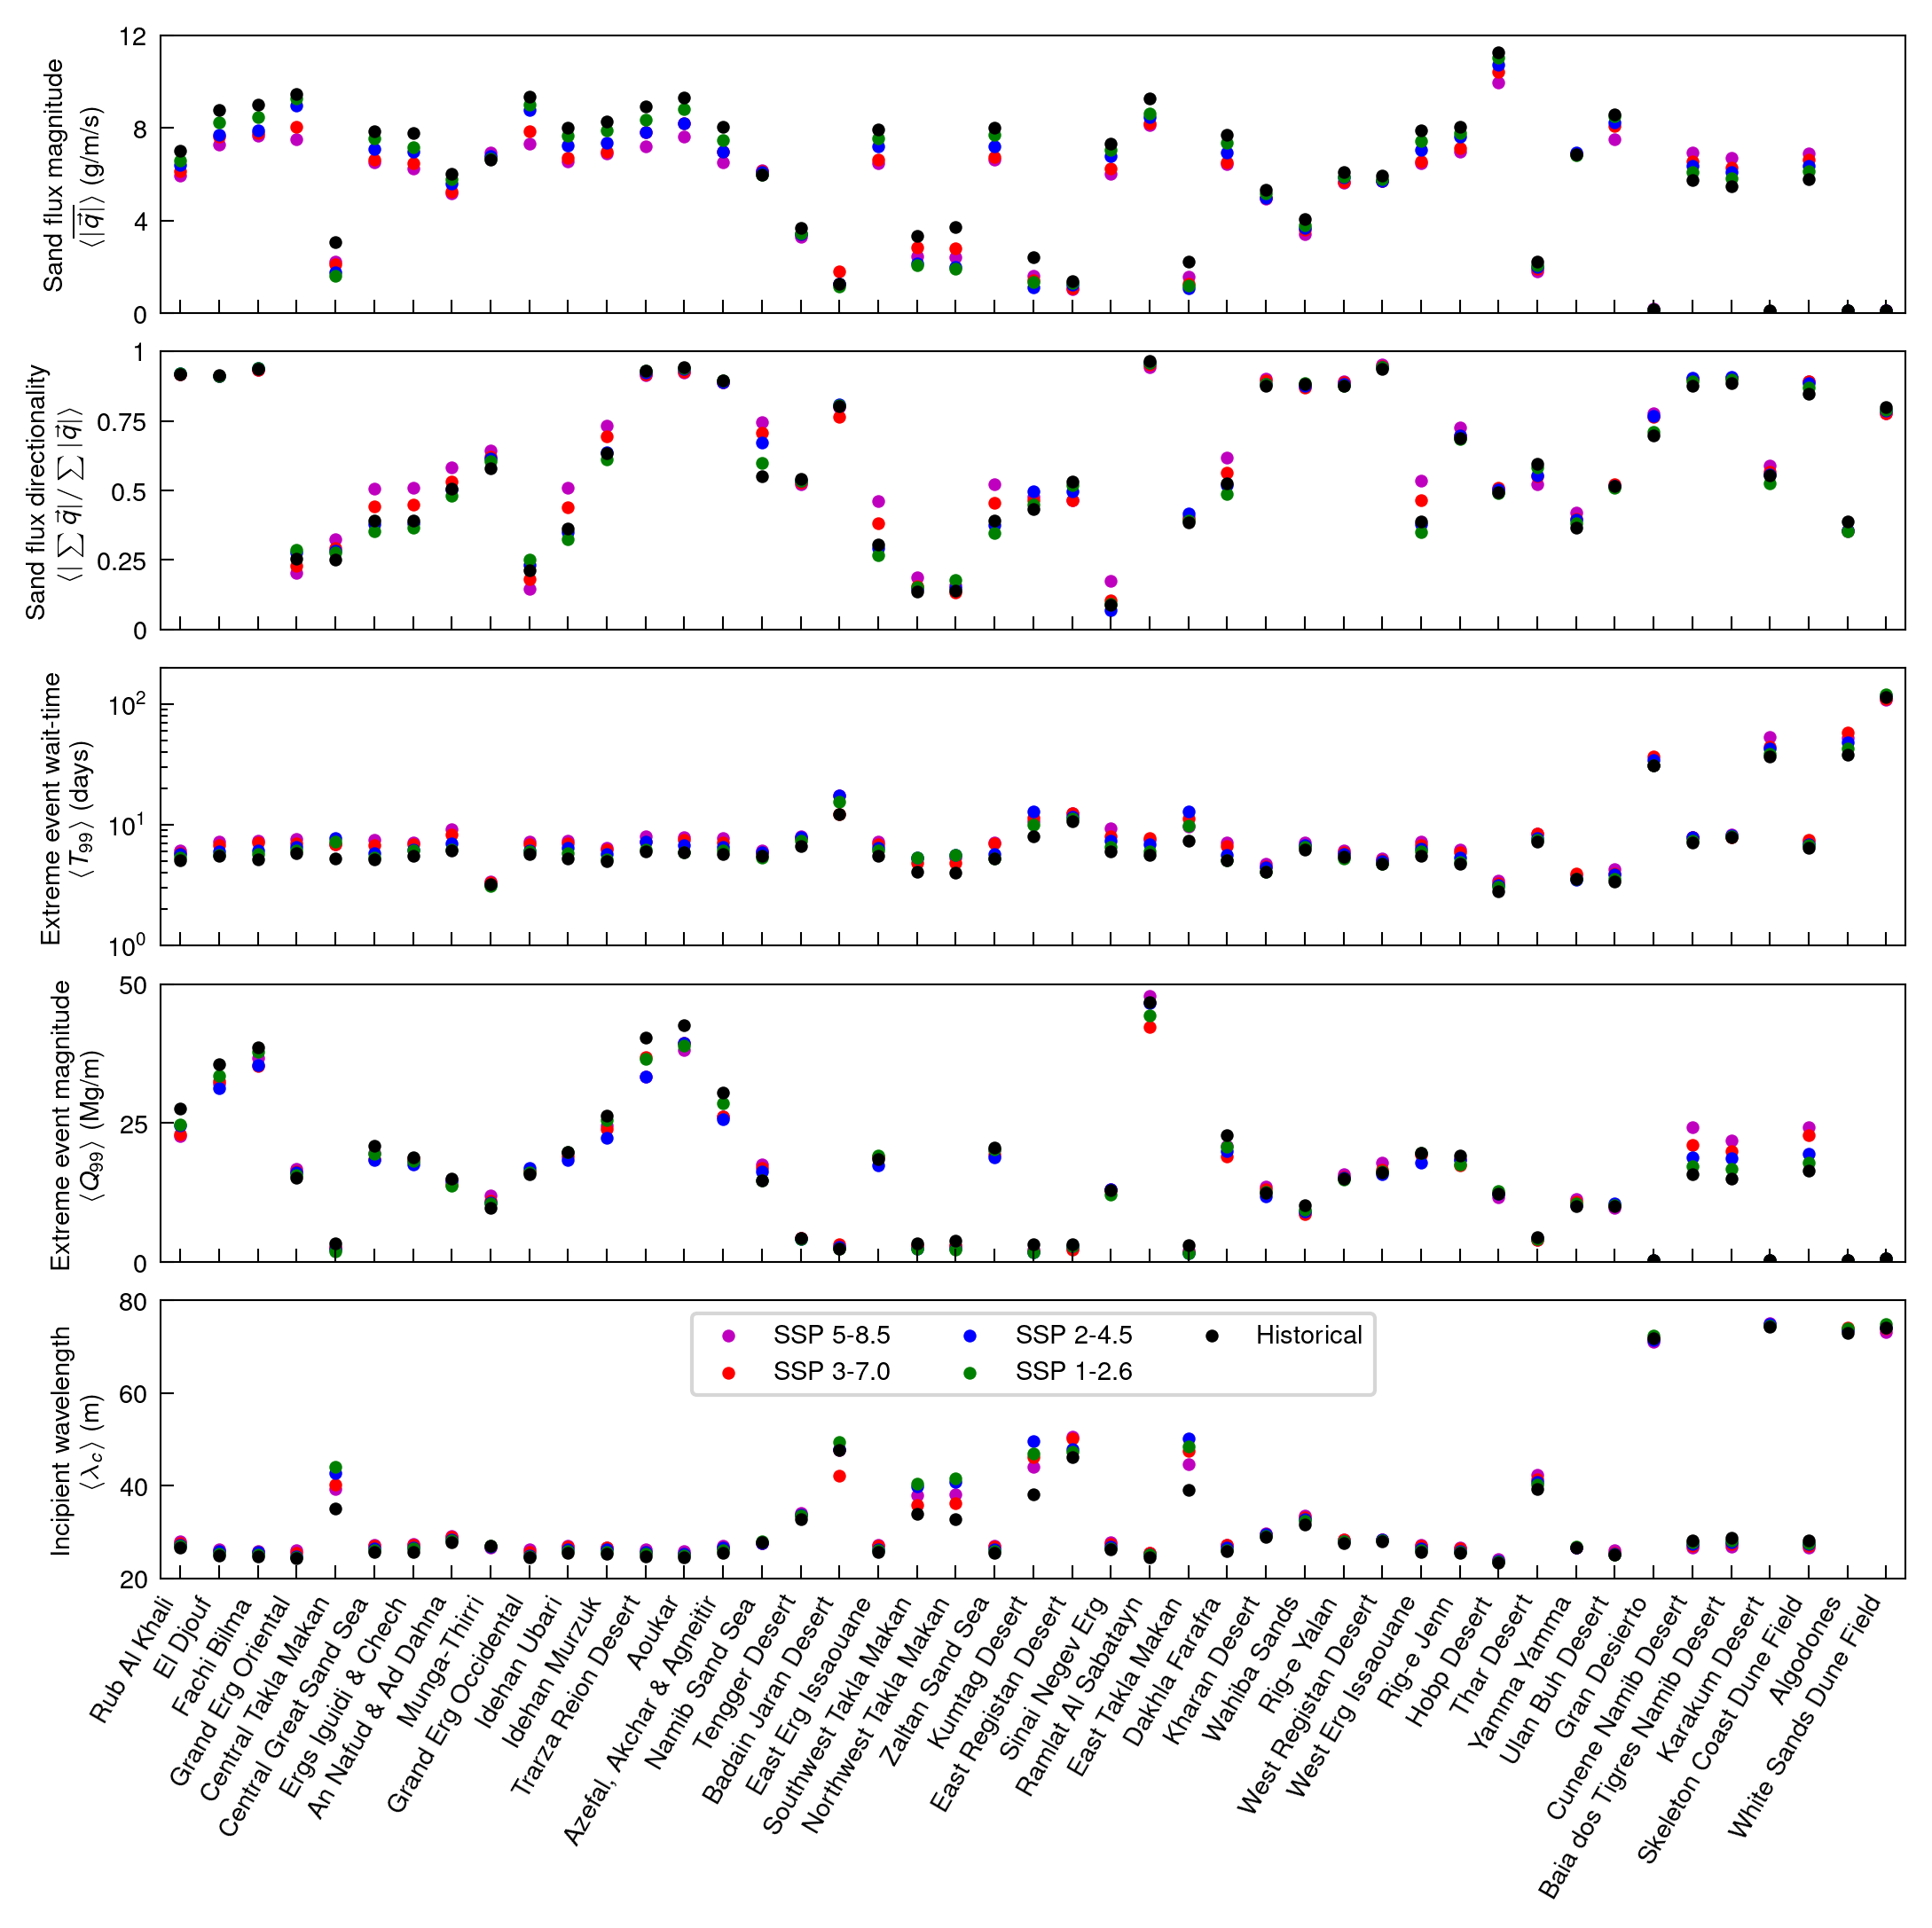

In [35]:
S = 12
lw = 0.5
mlw = 0

boty = 0.18
lefx = 0.08
bufy = 0.02
dely = 0.145
delx = 0.91

fig = plt.gcf()

ax0 = fig.add_axes([lefx,boty+(bufy+dely)*4,delx,dely])

for i in range(len(scenarios))[::-1]:
    plt.scatter(range(len(dfs)),mean_summq_scenario_ends_dfmean[i,np.argsort(df_area)[::-1]]*1e+3,facecolor=colors[i],edgecolor='k',lw=mlw,s=S)
plt.ylim(0,12)
plt.xlim(-0.5,len(dfs)-0.5)
plt.ylabel('Sand flux magnitude\n $\\langle\\overline{|\\vec{q}|}\\rangle$ (g/m/s)')
ax0.set_xticks(range(len(dfs)))
ax0.set_xticklabels(['' for i in range(len(dfs))])
ax0.set_yticks([0,4,8,12])

ax1 = fig.add_axes([lefx,boty+(bufy+dely)*3,delx,dely])

for i in range(len(scenarios))[::-1]:
    plt.scatter(range(len(dfs)),mean_fd_scenario_ends_dfmean[i,np.argsort(df_area)[::-1]],facecolor=colors[i],edgecolor='k',lw=mlw,s=S)
plt.ylim(0,1)
plt.xlim(-0.5,len(dfs)-0.5)
plt.ylabel('Sand flux directionality\n $\\langle|\\sum\\vec{q}|/\\sum|\\vec{q}|\\rangle$')
ax1.set_xticks(range(len(dfs)))
ax1.set_xticklabels(['' for i in range(len(dfs))])
ax1.set_yticks([0,0.25,0.5,0.75,1])
ax1.set_yticklabels(['0','0.25','0.5','0.75','1'])

ax2 = fig.add_axes([lefx,boty+(bufy+dely)*2,delx,dely])

for i in range(len(scenarios))[::-1]:
    plt.scatter(range(len(dfs)),qet_params_scenario_ends_dfmean[i,np.argsort(df_area)[::-1]]*s2yr*365,facecolor=colors[i],edgecolor='k',lw=mlw,s=S)
plt.yscale('log')
plt.ylim(1e+0,2e+2)
plt.xlim(-0.5,len(dfs)-0.5)
plt.ylabel('Extreme event wait-time\n $\\langle T_{99}\\rangle$ (days)')
ax2.set_xticks(range(len(dfs)))
ax2.set_xticklabels(['' for i in range(len(dfs))])

ax3 = fig.add_axes([lefx,boty+(bufy+dely)*1,delx,dely])

for i in range(len(scenarios))[::-1]:
    plt.scatter(range(len(dfs)),qem_params_scenario_ends_dfmean[i,np.argsort(df_area)[::-1]]*1e-3,facecolor=colors[i],edgecolor='k',lw=mlw,s=S)
plt.ylim(0,50)
plt.xlim(-0.5,len(dfs)-0.5)
plt.ylabel('Extreme event magnitude\n $\\langle Q_{99}\\rangle$ (Mg/m)')
ax3.set_xticks(range(len(dfs)))
ax3.set_xticklabels(['' for i in range(len(dfs))])
ax3.set_yticks([0,25,50])

ax4 = fig.add_axes([lefx,boty+(bufy+dely)*0,delx,dely])

for i in range(len(scenarios))[::-1]:
    plt.scatter(range(len(dfs)),get_wavel(get_usfromqm(mean_summq_scenario_ends_dfmean[i]))[np.argsort(df_area)[::-1]],facecolor=colors[i],edgecolor='k',lw=mlw,s=S,label=labels[i])
plt.legend(frameon=True,loc=9,ncol=3)
plt.ylim(20,80)
plt.xlim(-0.5,len(dfs)-0.5)
plt.ylabel('Incipient wavelength\n $\\langle\\lambda_c\\rangle$ (m)')
ax4.set_xticks(range(len(dfs)))
ax4.set_xticklabels([df_name[idx] for idx in np.argsort(df_area)[::-1]],rotation=60,ha='right')

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw) 
ax4.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw) 
    
fig.set_size_inches(183/25.4,183/25.4, forward=True)
plt.savefig('figures/edfigA.pdf',dpi=600)
plt.savefig('figures/edfigA.png',dpi=600)

# Extended Data Figure B

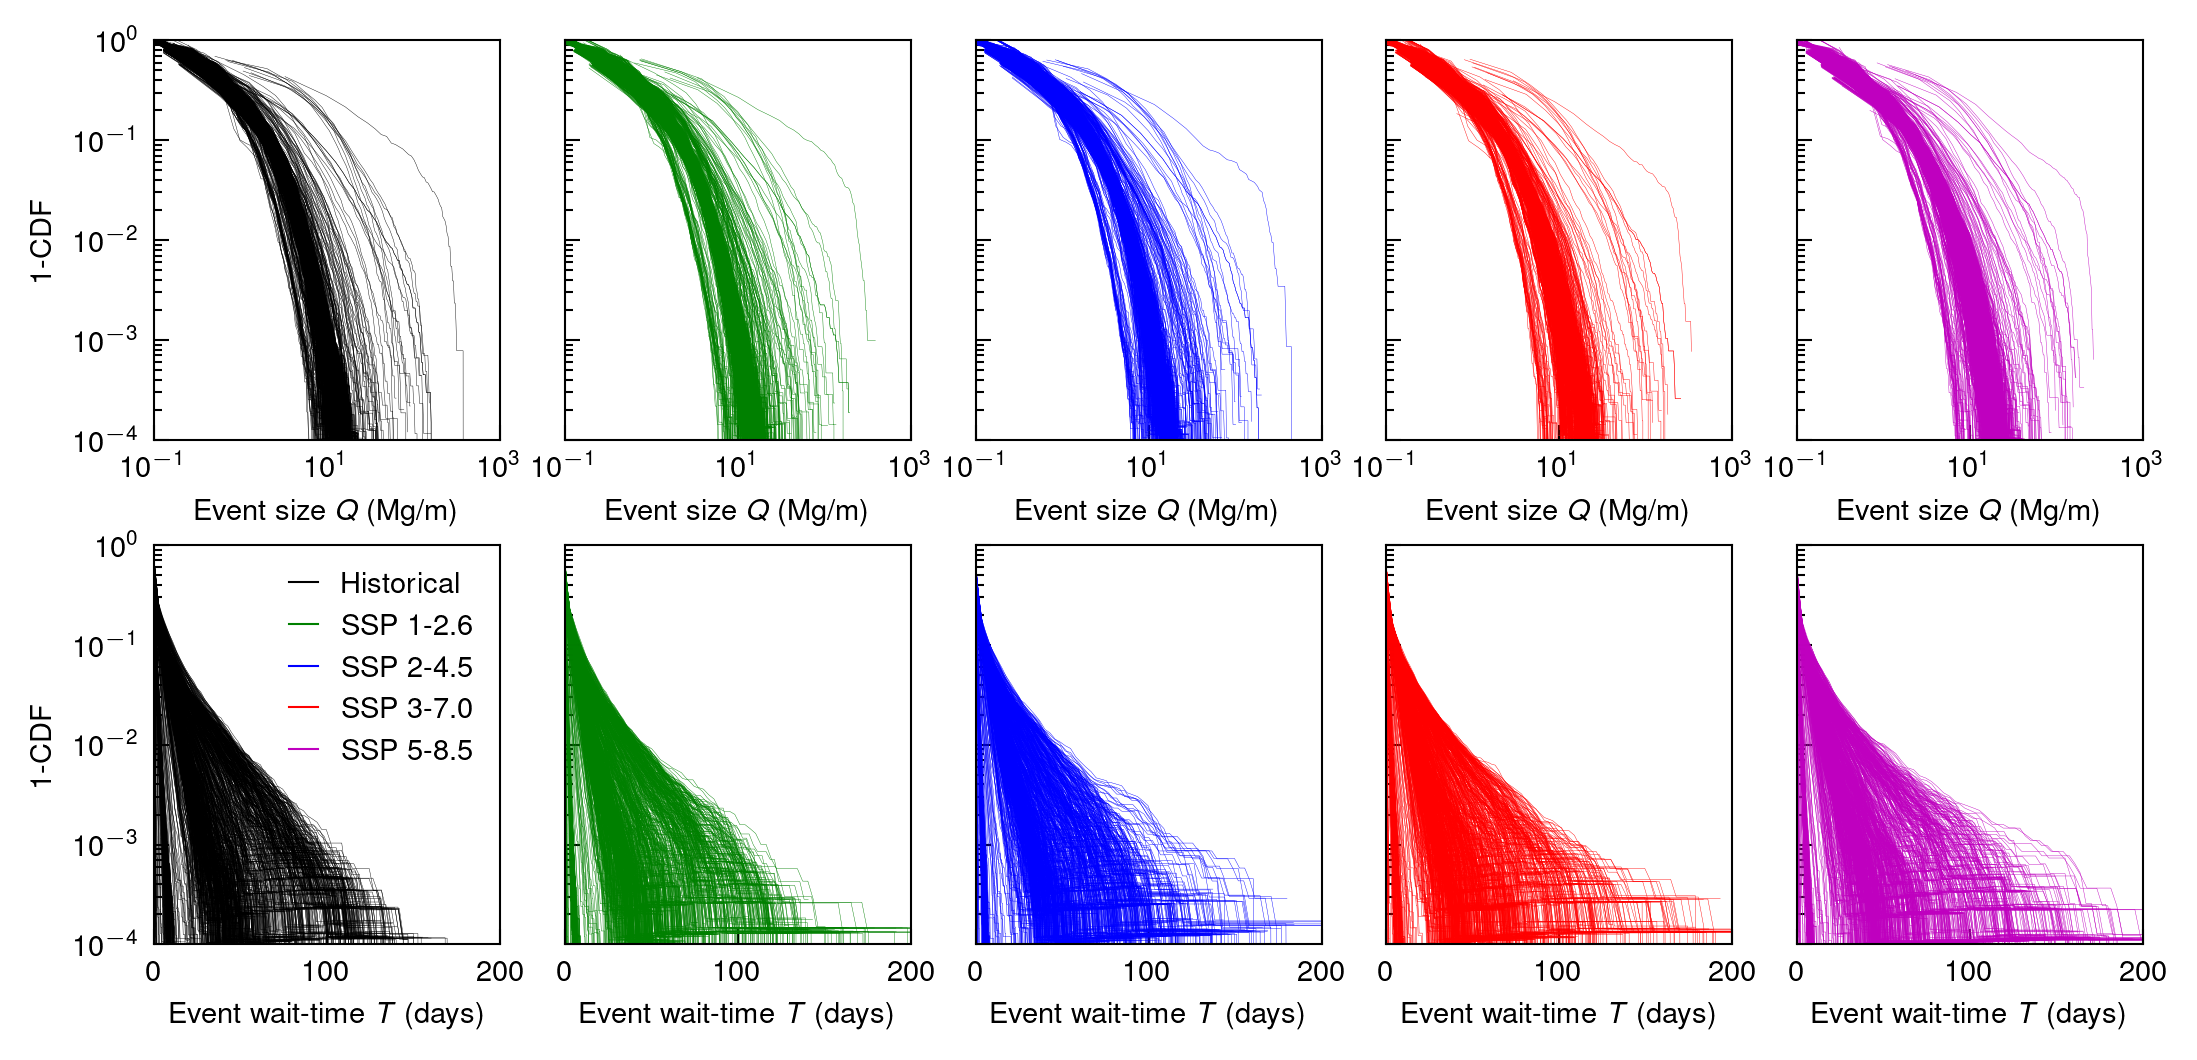

In [36]:
lw = 0.5
llw = 0.1
S = 3
colors = ['k','g','b','r','m']

boty = 0.1
lefx = 0.065
bufy = 0.1
dely = 0.38
bufx = 0.03
delx = 0.16

fig = plt.gcf()

scenarioind = 0

ax0 = fig.add_axes([lefx+(bufx+delx)*0,boty+(bufy+dely)*1,delx,dely])
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qet_counts_scenario_ends[i,j]*np.diff(qet_bins_scenario_ends[i,j]))
            else:
                tempy = qet_counts_scenario_ends[i,j]
        else:
            tempy = qet_counts_scenario_ends[i,j]/np.sum(qet_counts_scenario_ends[i,j])
        if tscale=='lin':
            tempx = qet_bins_scenario_ends[i,j][1:]-np.diff(qet_bins_scenario_ends[i,j])[0]/2
        elif tscale=='log':
            tempx = 10**(np.log10(qet_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qet_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0]*s2yr*365,tempy[tempy>0],color=colors[i],lw=llw)
        
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4,1e+0)
plt.xlim(1e-1,1e+3)
plt.ylabel('1-CDF')
plt.xlabel('Event size $Q$ (Mg/m)')

ax1 = fig.add_axes([lefx+(bufx+delx)*0,boty+(bufy+dely)*0,delx,dely])
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qem_counts_scenario_ends[i,j]*np.diff(qem_bins_scenario_ends[i,j]))
            else:
                tempy = qem_counts_scenario_ends[i,j]
        else:
            tempy = qem_counts_scenario_ends[i,j]/np.sum(qem_counts_scenario_ends[i,j])
        if mscale=='lin':
            tempx = qem_bins_scenario_ends[i,j][1:]-np.diff(qem_bins_scenario_ends[i,j])[0]/2
        elif mscale=='log':
            tempx = 10**(np.log10(qem_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qem_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0]*1e-3,tempy[tempy>0],color=colors[i],lw=llw)
        
for i in range(len(scenarios)):
    plt.plot([-1,-1],[-1,-1],lw=lw,color=colors[i],label=labels[i])
plt.legend(frameon=False,handlelength=lw*2)
plt.yscale('log')
plt.ylim(1e-4,1e+0)
plt.xlim(0,200)
plt.ylabel('1-CDF')
plt.xlabel('Event wait-time $T$ (days)')

######

scenarioind = 1

ax2 = fig.add_axes([lefx+(bufx+delx)*1,boty+(bufy+dely)*1,delx,dely])
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qet_counts_scenario_ends[i,j]*np.diff(qet_bins_scenario_ends[i,j]))
            else:
                tempy = qet_counts_scenario_ends[i,j]
        else:
            tempy = qet_counts_scenario_ends[i,j]/np.sum(qet_counts_scenario_ends[i,j])
        if tscale=='lin':
            tempx = qet_bins_scenario_ends[i,j][1:]-np.diff(qet_bins_scenario_ends[i,j])[0]/2
        elif tscale=='log':
            tempx = 10**(np.log10(qet_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qet_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0]*s2yr*365,tempy[tempy>0],color=colors[i],lw=llw)
        
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4,1e+0)
plt.xlim(1e-1,1e+3)
ax2.set_yticklabels([])
plt.xlabel('Event size $Q$ (Mg/m)')

ax3 = fig.add_axes([lefx+(bufx+delx)*1,boty+(bufy+dely)*0,delx,dely])
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qem_counts_scenario_ends[i,j]*np.diff(qem_bins_scenario_ends[i,j]))
            else:
                tempy = qem_counts_scenario_ends[i,j]
        else:
            tempy = qem_counts_scenario_ends[i,j]/np.sum(qem_counts_scenario_ends[i,j])
        if mscale=='lin':
            tempx = qem_bins_scenario_ends[i,j][1:]-np.diff(qem_bins_scenario_ends[i,j])[0]/2
        elif mscale=='log':
            tempx = 10**(np.log10(qem_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qem_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0]*1e-3,tempy[tempy>0],color=colors[i],lw=llw)
        
plt.yscale('log')
plt.ylim(1e-4,1e+0)
plt.xlim(0,200)
ax3.set_yticklabels([])
plt.xlabel('Event wait-time $T$ (days)')

######

scenarioind = 2

ax4 = fig.add_axes([lefx+(bufx+delx)*2,boty+(bufy+dely)*1,delx,dely])
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qet_counts_scenario_ends[i,j]*np.diff(qet_bins_scenario_ends[i,j]))
            else:
                tempy = qet_counts_scenario_ends[i,j]
        else:
            tempy = qet_counts_scenario_ends[i,j]/np.sum(qet_counts_scenario_ends[i,j])
        if tscale=='lin':
            tempx = qet_bins_scenario_ends[i,j][1:]-np.diff(qet_bins_scenario_ends[i,j])[0]/2
        elif tscale=='log':
            tempx = 10**(np.log10(qet_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qet_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0]*s2yr*365,tempy[tempy>0],color=colors[i],lw=llw)
        
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4,1e+0)
plt.xlim(1e-1,1e+3)
ax4.set_yticklabels([])
plt.xlabel('Event size $Q$ (Mg/m)')

ax5 = fig.add_axes([lefx+(bufx+delx)*2,boty+(bufy+dely)*0,delx,dely])
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qem_counts_scenario_ends[i,j]*np.diff(qem_bins_scenario_ends[i,j]))
            else:
                tempy = qem_counts_scenario_ends[i,j]
        else:
            tempy = qem_counts_scenario_ends[i,j]/np.sum(qem_counts_scenario_ends[i,j])
        if mscale=='lin':
            tempx = qem_bins_scenario_ends[i,j][1:]-np.diff(qem_bins_scenario_ends[i,j])[0]/2
        elif mscale=='log':
            tempx = 10**(np.log10(qem_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qem_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0]*1e-3,tempy[tempy>0],color=colors[i],lw=llw)
        
plt.yscale('log')
plt.ylim(1e-4,1e+0)
plt.xlim(0,200)
ax5.set_yticklabels([])
plt.xlabel('Event wait-time $T$ (days)')

######

scenarioind = 3

ax6 = fig.add_axes([lefx+(bufx+delx)*3,boty+(bufy+dely)*1,delx,dely])
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qet_counts_scenario_ends[i,j]*np.diff(qet_bins_scenario_ends[i,j]))
            else:
                tempy = qet_counts_scenario_ends[i,j]
        else:
            tempy = qet_counts_scenario_ends[i,j]/np.sum(qet_counts_scenario_ends[i,j])
        if tscale=='lin':
            tempx = qet_bins_scenario_ends[i,j][1:]-np.diff(qet_bins_scenario_ends[i,j])[0]/2
        elif tscale=='log':
            tempx = 10**(np.log10(qet_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qet_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0]*s2yr*365,tempy[tempy>0],color=colors[i],lw=llw)
        
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4,1e+0)
plt.xlim(1e-1,1e+3)
ax6.set_yticklabels([])
plt.xlabel('Event size $Q$ (Mg/m)')

ax7 = fig.add_axes([lefx+(bufx+delx)*3,boty+(bufy+dely)*0,delx,dely])
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qem_counts_scenario_ends[i,j]*np.diff(qem_bins_scenario_ends[i,j]))
            else:
                tempy = qem_counts_scenario_ends[i,j]
        else:
            tempy = qem_counts_scenario_ends[i,j]/np.sum(qem_counts_scenario_ends[i,j])
        if mscale=='lin':
            tempx = qem_bins_scenario_ends[i,j][1:]-np.diff(qem_bins_scenario_ends[i,j])[0]/2
        elif mscale=='log':
            tempx = 10**(np.log10(qem_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qem_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0]*1e-3,tempy[tempy>0],color=colors[i],lw=llw)
        
plt.yscale('log')
plt.ylim(1e-4,1e+0)
plt.xlim(0,200)
ax7.set_yticklabels([])
plt.xlabel('Event wait-time $T$ (days)')

######

scenarioind = 4

ax8 = fig.add_axes([lefx+(bufx+delx)*4,boty+(bufy+dely)*1,delx,dely])
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qet_counts_scenario_ends[i,j]*np.diff(qet_bins_scenario_ends[i,j]))
            else:
                tempy = qet_counts_scenario_ends[i,j]
        else:
            tempy = qet_counts_scenario_ends[i,j]/np.sum(qet_counts_scenario_ends[i,j])
        if tscale=='lin':
            tempx = qet_bins_scenario_ends[i,j][1:]-np.diff(qet_bins_scenario_ends[i,j])[0]/2
        elif tscale=='log':
            tempx = 10**(np.log10(qet_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qet_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0]*s2yr*365,tempy[tempy>0],color=colors[i],lw=llw)
        
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4,1e+0)
plt.xlim(1e-1,1e+3)
ax8.set_yticklabels([])
plt.xlabel('Event size $Q$ (Mg/m)')

ax9 = fig.add_axes([lefx+(bufx+delx)*4,boty+(bufy+dely)*0,delx,dely])
for i in [scenarioind]:
    for j in range(len(Dunefield_tileinds)):
        if density:
            if cdf:
                tempy = 1-np.cumsum(qem_counts_scenario_ends[i,j]*np.diff(qem_bins_scenario_ends[i,j]))
            else:
                tempy = qem_counts_scenario_ends[i,j]
        else:
            tempy = qem_counts_scenario_ends[i,j]/np.sum(qem_counts_scenario_ends[i,j])
        if mscale=='lin':
            tempx = qem_bins_scenario_ends[i,j][1:]-np.diff(qem_bins_scenario_ends[i,j])[0]/2
        elif mscale=='log':
            tempx = 10**(np.log10(qem_bins_scenario_ends[i,j])[1:]-np.diff(np.log10(qem_bins_scenario_ends[i,j]))[0]/2)
            
        plt.plot(tempx[tempy>0]*1e-3,tempy[tempy>0],color=colors[i],lw=llw)
        
plt.yscale('log')
plt.ylim(1e-4,1e+0)
plt.xlim(0,200)
ax9.set_yticklabels([])
plt.xlabel('Event wait-time $T$ (days)')

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw) 
ax4.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw) 
ax5.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax5.spines[axis].set_linewidth(lw) 
ax6.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax6.spines[axis].set_linewidth(lw) 
ax7.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax7.spines[axis].set_linewidth(lw) 
ax8.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax8.spines[axis].set_linewidth(lw) 
ax9.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax9.spines[axis].set_linewidth(lw) 
    
fig.set_size_inches(183/25.4,89/25.4, forward=True)
plt.savefig('figures/edfigB.pdf',dpi=600)
plt.savefig('figures/edfigB.png',dpi=600)

# Extended Data Figure C

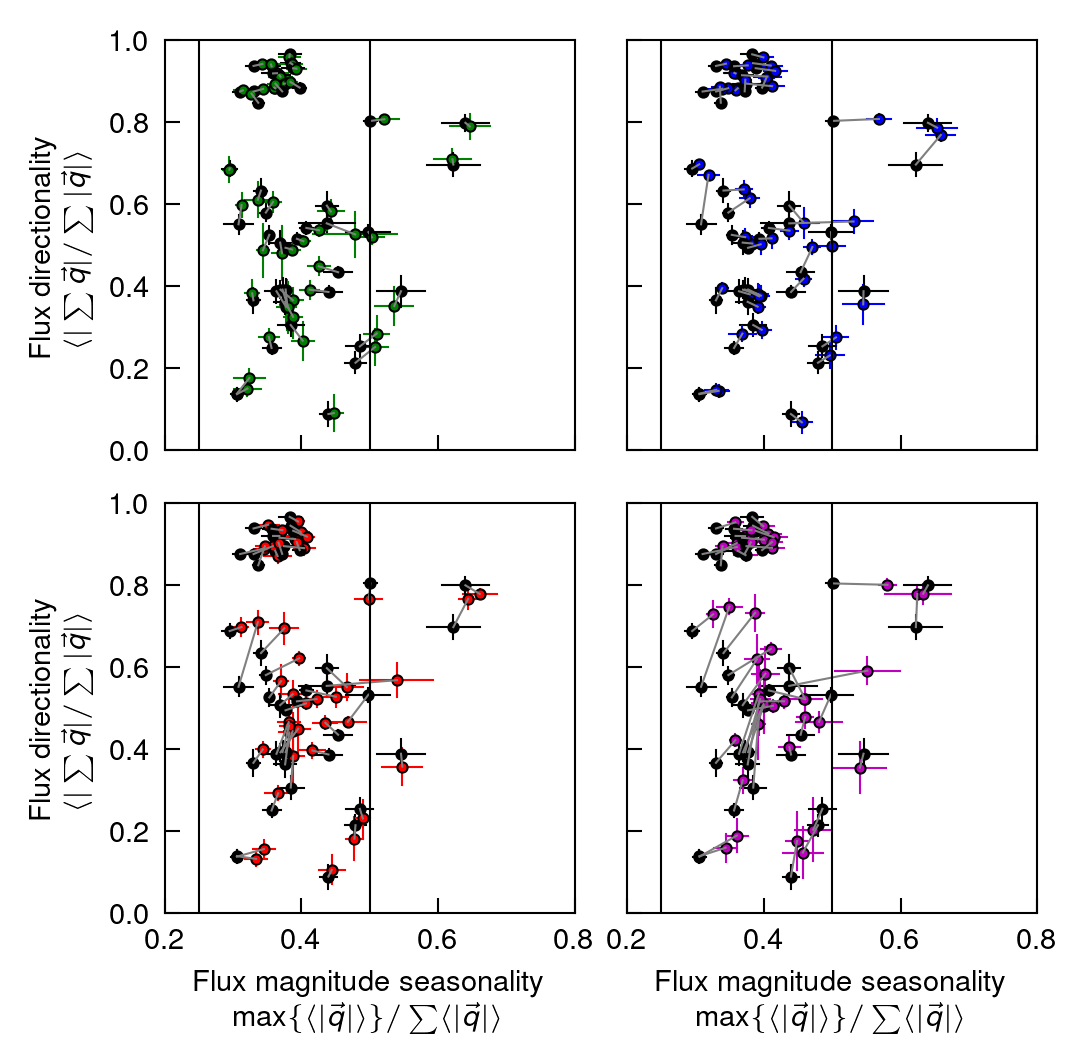

In [37]:
S = 6
lw = 0.5
mlw = 0.5

boty = 0.14
lefx = 0.14
bufy = 0.05
dely = 0.39
bufx = bufy
delx = dely

fig = plt.gcf()

ax0 = fig.add_axes([lefx+(bufx+delx)*0,boty+(bufy+dely)*1,delx,dely])

j = 1
for i in range(Ndunefields):
    
    plt.scatter(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],mean_fd_scenario_ends_dfmean[0,i],facecolor=colors[0],edgecolor='k',s=S,lw=mlw,zorder=1)
    plt.scatter(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],mean_fd_scenario_ends_dfmean[j,i],facecolor=colors[j],edgecolor='k',s=S,lw=mlw,zorder=1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[j,i],mean_fd_scenario_ends_dfmean[0,i]],c='grey',lw=lw,zorder=1)
    
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]],
             [mean_fd_scenario_ends_dfmean[j,i],
              mean_fd_scenario_ends_dfmean[j,i]],
             c=colors[j],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]],
             [mean_fd_scenario_ends_dfmean[j,i]+std_fd_scenario_ends_dfmean[j,i],
              mean_fd_scenario_ends_dfmean[j,i]-std_fd_scenario_ends_dfmean[j,i]],
             c=colors[j],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[0,i],
              mean_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[0,i]+std_fd_scenario_ends_dfmean[0,i],
              mean_fd_scenario_ends_dfmean[0,i]-std_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw,zorder=-1)
    
plt.plot([0.25,0.25],[0,1],'k',lw=lw)
plt.plot([0.5,0.5],[0,1],'k',lw=lw)
plt.ylim(0,1)
plt.xlim(0.2,0.8)
ax0.set_xticklabels([])
plt.ylabel('Flux directionality\n $\\langle|\\sum\\vec{q}|/\\sum|\\vec{q}|\\rangle$')

ax1 = fig.add_axes([lefx+(bufx+delx)*1,boty+(bufy+dely)*1,delx,dely])

j = 2
for i in range(Ndunefields):
    
    plt.scatter(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],mean_fd_scenario_ends_dfmean[0,i],facecolor=colors[0],edgecolor='k',s=S,lw=mlw,zorder=1)
    plt.scatter(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],mean_fd_scenario_ends_dfmean[j,i],facecolor=colors[j],edgecolor='k',s=S,lw=mlw,zorder=1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[j,i],mean_fd_scenario_ends_dfmean[0,i]],c='grey',lw=lw,zorder=1)
    
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]],
             [mean_fd_scenario_ends_dfmean[j,i],
              mean_fd_scenario_ends_dfmean[j,i]],
             c=colors[j],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]],
             [mean_fd_scenario_ends_dfmean[j,i]+std_fd_scenario_ends_dfmean[j,i],
              mean_fd_scenario_ends_dfmean[j,i]-std_fd_scenario_ends_dfmean[j,i]],
             c=colors[j],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[0,i],
              mean_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[0,i]+std_fd_scenario_ends_dfmean[0,i],
              mean_fd_scenario_ends_dfmean[0,i]-std_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw,zorder=-1)
    
plt.plot([0.25,0.25],[0,1],'k',lw=lw)
plt.plot([0.5,0.5],[0,1],'k',lw=lw)
plt.ylim(0,1)
plt.xlim(0.2,0.8)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax2 = fig.add_axes([lefx+(bufx+delx)*0,boty+(bufy+dely)*0,delx,dely])

j = 3
for i in range(Ndunefields):
    
    plt.scatter(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],mean_fd_scenario_ends_dfmean[0,i],facecolor=colors[0],edgecolor='k',s=S,lw=mlw,zorder=1)
    plt.scatter(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],mean_fd_scenario_ends_dfmean[j,i],facecolor=colors[j],edgecolor='k',s=S,lw=mlw,zorder=1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[j,i],mean_fd_scenario_ends_dfmean[0,i]],c='grey',lw=lw,zorder=1)
    
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]],
             [mean_fd_scenario_ends_dfmean[j,i],
              mean_fd_scenario_ends_dfmean[j,i]],
             c=colors[j],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]],
             [mean_fd_scenario_ends_dfmean[j,i]+std_fd_scenario_ends_dfmean[j,i],
              mean_fd_scenario_ends_dfmean[j,i]-std_fd_scenario_ends_dfmean[j,i]],
             c=colors[j],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[0,i],
              mean_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[0,i]+std_fd_scenario_ends_dfmean[0,i],
              mean_fd_scenario_ends_dfmean[0,i]-std_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw,zorder=-1)
    
plt.plot([0.25,0.25],[0,1],'k',lw=lw)
plt.plot([0.5,0.5],[0,1],'k',lw=lw)
plt.ylim(0,1)
plt.xlim(0.2,0.8)
plt.xlabel('Flux magnitude seasonality\n $\\max\{\\langle|\\vec{q}|\\rangle\}/\\sum\\langle|\\vec{q}|\\rangle$')
plt.ylabel('Flux directionality\n $\\langle|\\sum\\vec{q}|/\\sum|\\vec{q}|\\rangle$')

ax3 = fig.add_axes([lefx+(bufx+delx)*1,boty+(bufy+dely)*0,delx,dely])

j = 4
for i in range(Ndunefields):
    
    plt.scatter(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],mean_fd_scenario_ends_dfmean[0,i],facecolor=colors[0],edgecolor='k',s=S,lw=mlw,zorder=1)
    plt.scatter(mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],mean_fd_scenario_ends_dfmean[j,i],facecolor=colors[j],edgecolor='k',s=S,lw=mlw,zorder=1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[j,i],mean_fd_scenario_ends_dfmean[0,i]],c='grey',lw=lw,zorder=1)
    
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]],
             [mean_fd_scenario_ends_dfmean[j,i],
              mean_fd_scenario_ends_dfmean[j,i]],
             c=colors[j],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[j,i]],
             [mean_fd_scenario_ends_dfmean[j,i]+std_fd_scenario_ends_dfmean[j,i],
              mean_fd_scenario_ends_dfmean[j,i]-std_fd_scenario_ends_dfmean[j,i]],
             c=colors[j],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]-std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]+std_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[0,i],
              mean_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw,zorder=-1)
    plt.plot([mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i],
              mean_maxtrimonth_mean_summq_props_scenario_ends_dfmean[0,i]],
             [mean_fd_scenario_ends_dfmean[0,i]+std_fd_scenario_ends_dfmean[0,i],
              mean_fd_scenario_ends_dfmean[0,i]-std_fd_scenario_ends_dfmean[0,i]],
             c=colors[0],lw=lw,zorder=-1)
    
plt.plot([0.25,0.25],[0,1],'k',lw=lw)
plt.plot([0.5,0.5],[0,1],'k',lw=lw)
plt.ylim(0,1)
plt.xlim(0.2,0.8)
ax3.set_yticklabels([])
plt.xlabel('Flux magnitude seasonality\n $\\max\{\\langle|\\vec{q}|\\rangle\}/\\sum\\langle|\\vec{q}|\\rangle$')

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw) 
    
fig.set_size_inches(89/25.4,89/25.4, forward=True)
plt.savefig('figures/edfigC.pdf',dpi=600)
plt.savefig('figures/edfigC.png',dpi=600)

# Extended Data Figure D

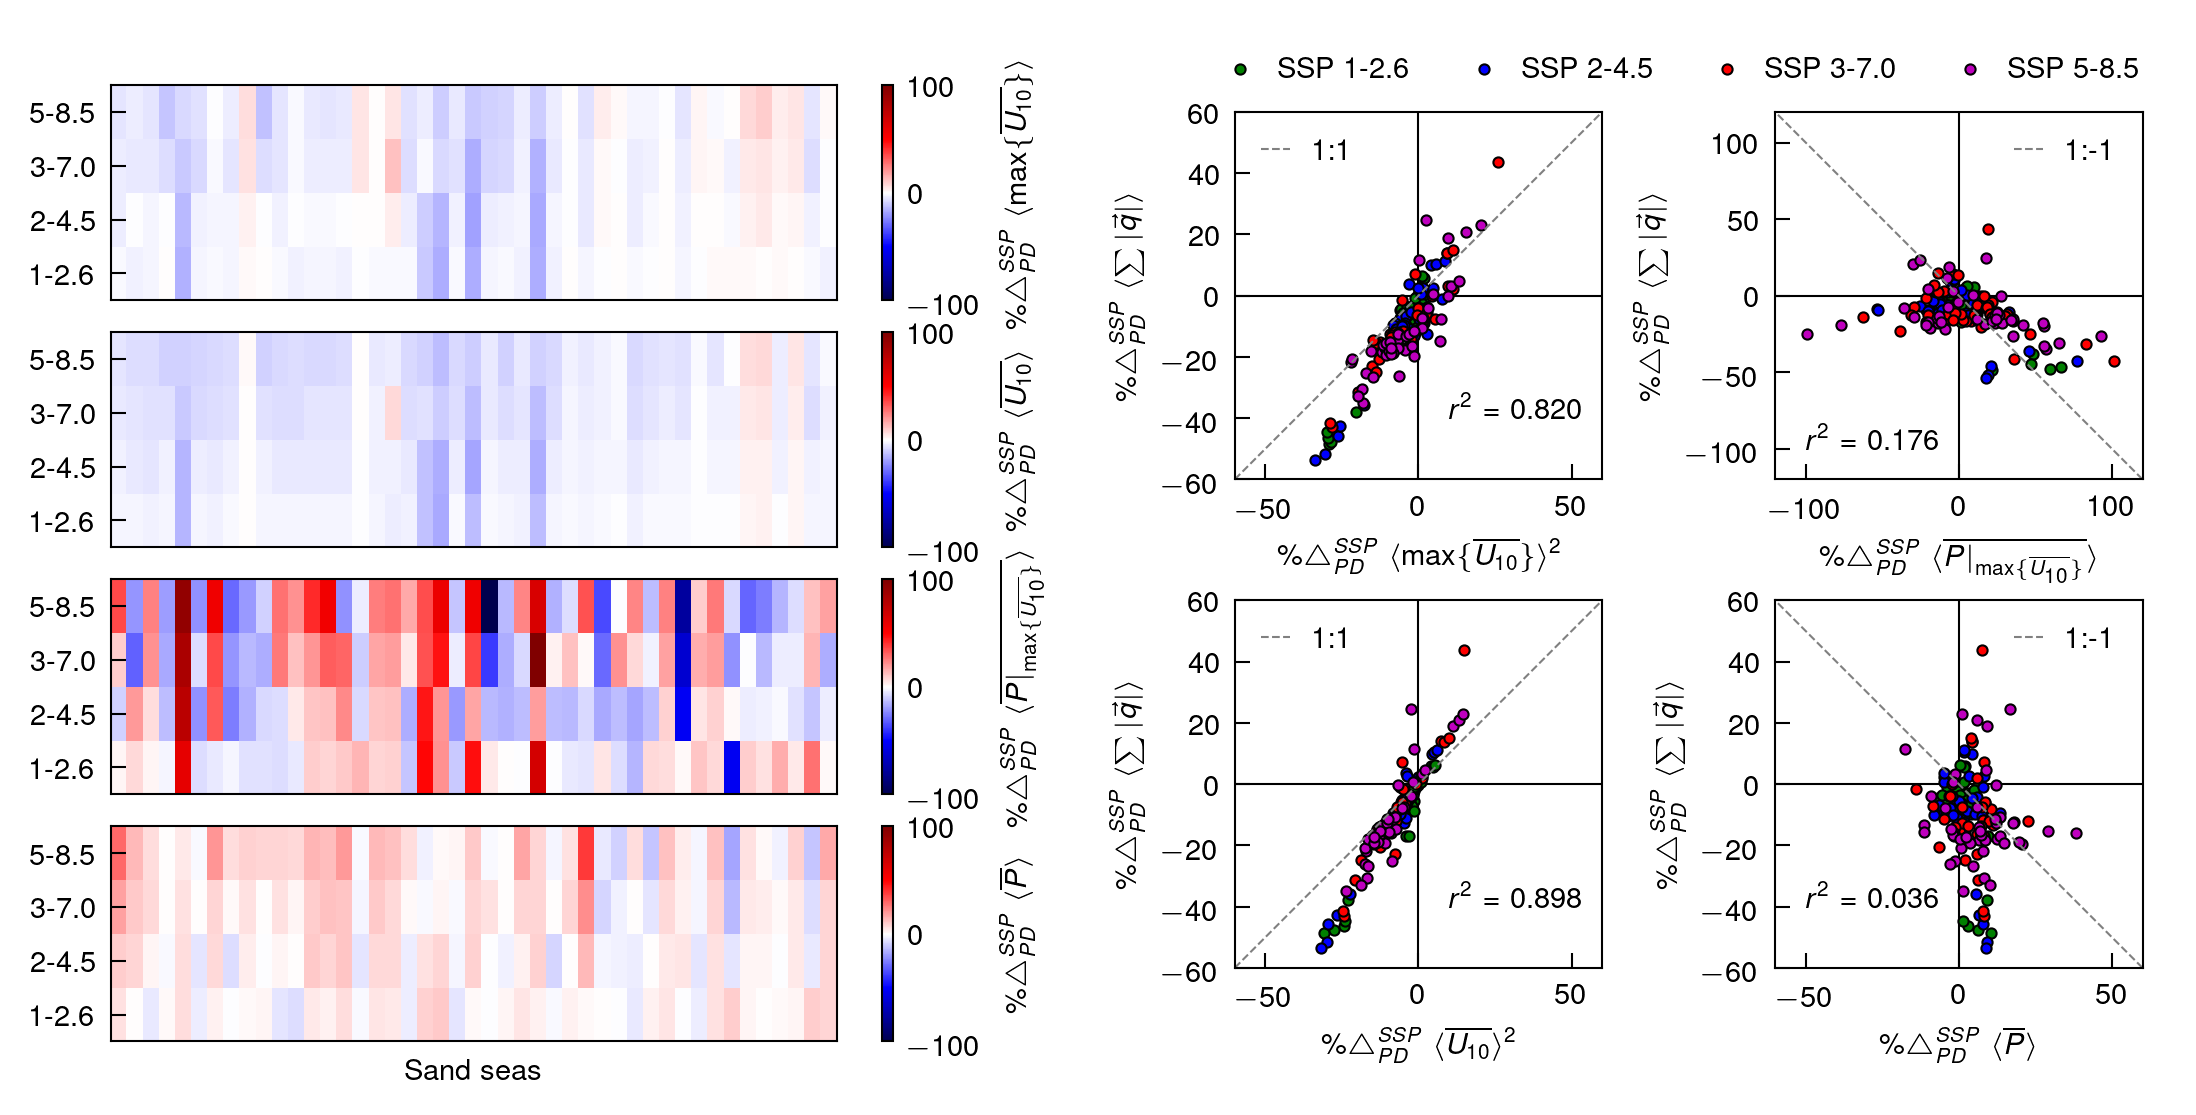

In [38]:
colors = ['k','g','b','r','m']

boty0 = 0.05
boty1 = 0.12
lefx = 0.05
bufxm = 0.1

bufy0 = 0.03
dely0 = 0.205
delx0 = 0.42

bufx1 = 0.08
bufy1 = bufx1*(183/89)*0.7
delx1 = 0.17
dely1 = delx1*(183/89)

fig = plt.gcf()

ax0 = fig.add_axes([lefx,boty0+(bufy0+dely0)*3,delx0,dely0])
temp = 100*(trimonthmax_wspd_ens_mean_scenario_ends_dfmean[1:]-trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0])/trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
c0 = plt.colorbar()
c0.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\max\{\\overline{U_{10}}\}\\rangle$')

ax1 = fig.add_axes([lefx,boty0+(bufy0+dely0)*2,delx0,dely0])
temp = 100*(np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[1:]-np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[0])/np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
c1 = plt.colorbar()
c1.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\overline{U_{10}}\\rangle$')

ax2 = fig.add_axes([lefx,boty0+(bufy0+dely0)*1,delx0,dely0])
temp = 100*(pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[1:]-pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0])/pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
c2 = plt.colorbar()
c2.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle \\overline{P|_{\\max\{\\overline{U_{10}}\}}}\\rangle$')

ax3 = fig.add_axes([lefx,boty0+(bufy0+dely0)*0,delx0,dely0])
temp = 100*(np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[1:]-np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[0])/np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[0]
plt.pcolormesh(temp[:,np.argsort(df_area)[::-1]],cmap=cmap,vmin=-100,vmax=100,rasterized=True)
plt.xticks([])
plt.yticks([0.5,1.5,2.5,3.5],['1-2.6','2-4.5','3-7.0','5-8.5'])
c3 = plt.colorbar()
c3.ax.set_ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle \\overline{P}\\rangle$')
plt.xlabel('Sand seas')

ax40 = fig.add_axes([lefx+delx0+bufxm+(bufx1+delx1)*1.045,boty1+(bufy1+dely1)*1.9,delx1,0.01])
for i in range(len(scenarios)-1):
    plt.scatter(np.nan,np.nan,facecolor=colors[i+1],edgecolor='k',s=S,lw=lw,label=labels[i+1])
plt.legend(frameon=False,handlelength=1,ncol=4)
plt.axis('off')

ax4 = fig.add_axes([lefx+delx0+bufxm+(bufx1+delx1)*0,boty1+(bufy1+dely1)*0,delx1,dely1])
temp0 = 100*(np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[1:]**2-np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[0]**2)/np.mean(wspd_ens_mean_scenario_ends_dfmean,axis=1)[0]**2
temp1 = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([-60,60],[-60,60],'--',c='grey',lw=lw,label='1:1')
plt.plot([60,-60],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[60,-60],c='k',lw=lw,zorder=-1)
plt.text(10,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False,handlelength=1)
plt.xlim(-60,60)
plt.ylim(-60,60)
plt.xlabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\overline{U_{10}}\\rangle^2$')
plt.ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\sum|\\vec{q}|\\rangle$')

ax5 = fig.add_axes([lefx+delx0+bufxm+(bufx1+delx1)*0,boty1+(bufy1+dely1)*1,delx1,dely1])
temp0 = 100*(trimonthmax_wspd_ens_mean_scenario_ends_dfmean[1:]**2-trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0]**2)/trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0]**2
temp1 = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([-60,60],[-60,60],'--',c='grey',lw=lw,label='1:1')
plt.plot([60,-60],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[60,-60],c='k',lw=lw,zorder=-1)
plt.text(10,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False,handlelength=1)
plt.xlim(-60,60)
plt.ylim(-60,60)
plt.xlabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\max\{\\overline{U_{10}}\}\\rangle^2$')
plt.ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\sum|\\vec{q}|\\rangle$')

ax6 = fig.add_axes([lefx+delx0+bufxm+(bufx1+delx1)*1,boty1+(bufy1+dely1)*0,delx1,dely1])
temp0 = 100*(np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[1:]-np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[0])/np.sum(pr_ens_mean_scenario_ends_dfmean,axis=1)[0]
temp1 = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([60,-60],[-60,60],'--',c='grey',lw=lw,label='1:-1')
plt.plot([60,-60],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[60,-60],c='k',lw=lw,zorder=-1)
plt.text(-50,-40,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False,handlelength=1)
plt.xlim(-60,60)
plt.ylim(-60,60)
plt.xlabel('\%$\\triangle_{PD}^{SSP}$  $\\langle \\overline{P}\\rangle$')
plt.ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\sum|\\vec{q}|\\rangle$')

ax7 = fig.add_axes([lefx+delx0+bufxm+(bufx1+delx1)*1,boty1+(bufy1+dely1)*1,delx1,dely1])
temp0 = 100*(pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[1:]-pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0])/pr_sum_trimonthmax_wspd_ens_mean_scenario_ends_dfmean[0]
temp1 = 100*(mean_summq_scenario_ends_dfmean[1:]-mean_summq_scenario_ends_dfmean[0])/mean_summq_scenario_ends_dfmean[0]
tempr2 = pearsonr(np.ndarray.flatten(temp0),np.ndarray.flatten(temp1))[0]**2
for i in range(len(scenarios)-1):
    plt.scatter(temp0[i],temp1[i],facecolor=colors[i+1],edgecolor='k',s=S,lw=lw)
plt.plot([120,-120],[-120,120],'--',c='grey',lw=lw,label='1:-1')
plt.plot([120,-120],[0,0],c='k',lw=lw,zorder=-1)
plt.plot([0,0],[120,-120],c='k',lw=lw,zorder=-1)
plt.text(-100,-100,'$r^2=%.3f$'%tempr2)
plt.legend(frameon=False,handlelength=1)
plt.xlim(-120,120)
plt.ylim(-120,120)
plt.xlabel('\%$\\triangle_{PD}^{SSP}$  $\\langle \\overline{P|_{\\max\{\\overline{U_{10}}\}}}\\rangle$')
plt.ylabel('\%$\\triangle_{PD}^{SSP}$  $\\langle\\sum|\\vec{q}|\\rangle$')

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
ax3.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax3.spines[axis].set_linewidth(lw) 
ax4.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax4.spines[axis].set_linewidth(lw) 
ax5.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax5.spines[axis].set_linewidth(lw) 
ax6.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax6.spines[axis].set_linewidth(lw) 
ax7.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax7.spines[axis].set_linewidth(lw) 
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)
c1.ax.tick_params(width=0,which='both',direction='in')
c1.outline.set_linewidth(lw)
c2.ax.tick_params(width=0,which='both',direction='in')
c2.outline.set_linewidth(lw)
c3.ax.tick_params(width=0,which='both',direction='in')
c3.outline.set_linewidth(lw)

fig.set_size_inches(183/25.4,89/25.4, forward=True)
plt.savefig('figures/edfigD.pdf',dpi=600)
plt.savefig('figures/edfigD.png',dpi=600)

# Extended Data Figure E

<ipython-input-39-5e1da5372b91>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc0 = plt.pcolor(maplon,maplat,mapvar,zorder=-1,vmin=0,vmax=15,cmap='afmhot',rasterized=True)
<ipython-input-39-5e1da5372b91>:28: UserWarning: No contour levels were found within the data range.
  plt.contour(maplon,maplat,mapocean,[1],linewidths=lw,colors='b',zorder=1)
<ipython-input-39-5e1da5372b91>:59: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(wspd_ens_mean[i]*landmask[np.newaxis,np.newaxis,:,:],axis=tuple((0,1,3))),globlat,color=colors[i],lw=lw*2)
<ipython-input-39-5e1da5372b91>:59: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(wspd_ens_mean[i]*landmask[np.newaxis,np.newaxis,:,:],axis=tuple((0,1,3))),globlat,c

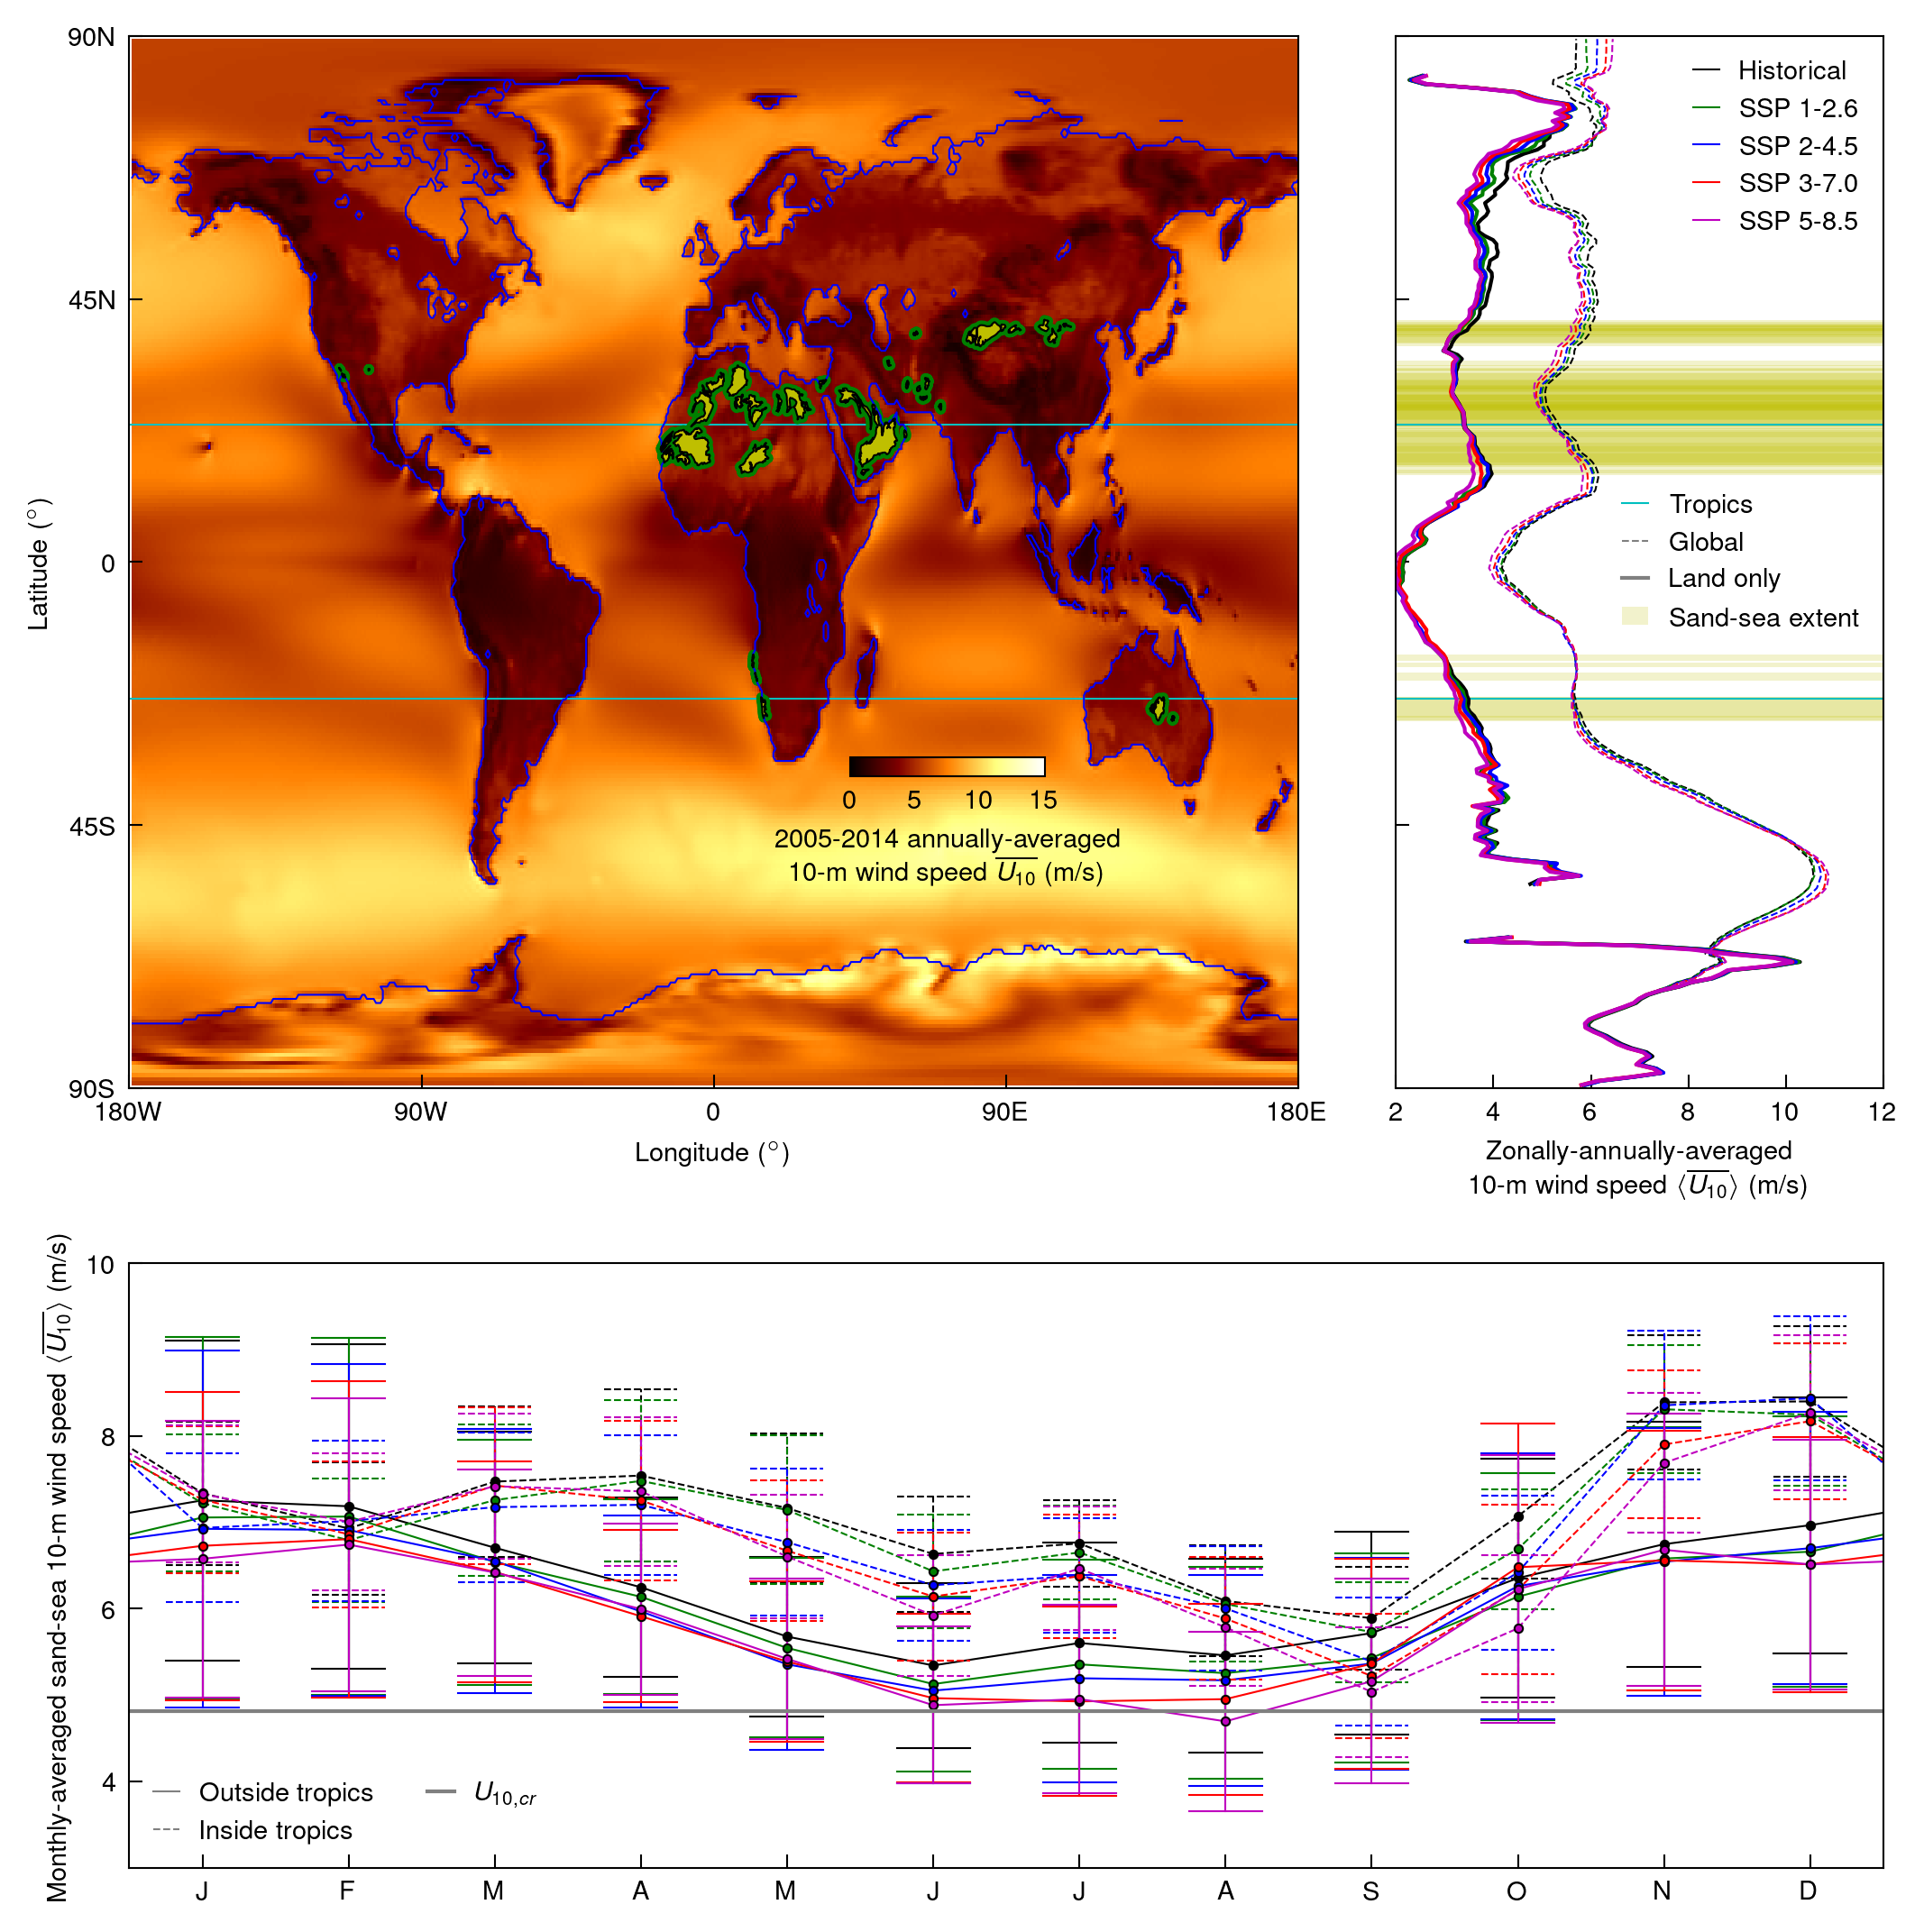

In [39]:
tropiclat = 23.43656

landmask  = np.asarray(xr.open_dataset(directory + 'tslsi_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-18501231.nc').tslsi)[0]
landmask  = landmask/landmask*1
oceanmask = np.copy(landmask)
oceanmask[np.isnan(oceanmask)] = 2

globlat,globlon = get_latlon()

scenarioind = 0

mapvar = np.mean(wspd_ens_mean[scenarioind],axis=tuple((0,1)))
mapvar = np.hstack((mapvar[:,(globlon>180)],mapvar[:,(globlon<=180)]))

mapocean = oceanmask
mapocean = np.hstack((mapocean[:,(globlon>180)],mapocean[:,(globlon<=180)]))

maplon = np.hstack((globlon[(globlon>180)]-360,globlon[(globlon<=180)]))
maplat = globlat

fig = plt.gcf()

ax0 = fig.add_axes([0.07,0.44,0.6,0.54])

pc0 = plt.pcolor(maplon,maplat,mapvar,zorder=-1,vmin=0,vmax=15,cmap='afmhot',rasterized=True)
plt.plot([-180,180],[ tropiclat, tropiclat],c='c',lw=lw,zorder=-1)
plt.plot([-180,180],[-tropiclat,-tropiclat],c='c',lw=lw,zorder=-1)
plt.contour(maplon,maplat,mapocean,[1],linewidths=lw,colors='b',zorder=1)

scale = 2
for i in range(len(dfs)):
    x,y = dfs[i].exterior.xy
    plt.plot(np.asarray(x)-180,y, color='k', lw=lw)
    plt.fill(np.asarray(x)-180,y, color='y', lw=0,zorder=1)
    plt.plot(np.asarray(x)-180,y, color='g', lw=lw*5,zorder=-1, solid_capstyle='round')

plt.xlim(-180,180)
plt.ylim(-90,90)
ax0.set_ylabel('Latitude ($^\\circ$)')
ax0.set_xlabel('Longitude ($^\\circ$)')
ax0.set_xticks([-180,-90,0,90,180])
ax0.set_xticklabels(['180W','90W','0','90E','180E'])
ax0.set_yticks([-90,-45,0,45,90])
ax0.set_yticklabels(['90S','45S','0','45N','90N'])

ax1 = fig.add_axes([0.72,0.44,0.25,0.54])

colors = ['k','g','b','r','m']

plt.plot([0,12],[ tropiclat, tropiclat],c='c',lw=lw,label='Tropics')
plt.plot([0,12],[-tropiclat,-tropiclat],c='c',lw=lw)

for j in range(len(dfs)):
    plt.fill_between([0,12],[np.min(dfs[j].exterior.xy[1]),np.min(dfs[j].exterior.xy[1])],[np.max(dfs[j].exterior.xy[1]),np.max(dfs[j].exterior.xy[1])],color='y',lw=0,alpha=0.2)
plt.fill_between([-1,0],[-100,-100],[-99,-99],color='y',lw=0,alpha=0.2,label='Sand-sea extent')    

for i in range(len(scenarios)):
    plt.plot(np.mean(wspd_ens_mean[i],axis=tuple((0,1,3))),globlat,'--',color=colors[i],lw=lw)
    plt.plot(np.nanmean(wspd_ens_mean[i]*landmask[np.newaxis,np.newaxis,:,:],axis=tuple((0,1,3))),globlat,color=colors[i],lw=lw*2)        

plt.plot([-1,0],[-100,-100],'--',color='grey',lw=lw,label='Global')
plt.plot([-1,0],[-100,-100],color='grey',lw=lw*2,label='Land only')
        
plt.xlim(2,12)
plt.ylim(-90,90)
plt.legend(frameon=False,loc=5,handlelength=lw*2)
ax1.set_xlabel('Zonally-annually-averaged\n 10-m wind speed $\\langle\\overline{U_{10}}\\rangle$ (m/s)')
ax1.set_xticks([2,4,6,8,10,12])
ax1.set_xticklabels(['2','4','6','8','10','12'])
ax1.set_yticks([-90,-45,0,45,90])
ax1.set_yticklabels(['','','','',''])

ax11 = fig.add_axes([0.73,0.14,0.24,0.84])
for i in range(len(scenarios)):
    plt.plot(0,0,color=colors[i],lw=lw,label=labels[i])
plt.legend(frameon=False,loc=1,handlelength=lw*2)
plt.xlim(1,2)
plt.ylim(1,2)
plt.axis('off')

S = 5

tempinds_introp = Dunefield_tileinds[np.abs(Dunefield_latlon[:,1])<tropiclat]
tempinds_outtrop = Dunefield_tileinds[np.abs(Dunefield_latlon[:,1])>tropiclat]

ax2 = fig.add_axes([0.07,0.04,0.9,0.31])

for i in range(len(scenarios)):
    plt.scatter(np.arange(Nmonths)+0.5,np.mean(wspd_ens_mean[i,:,:,tempinds_introp.T[1],tempinds_introp.T[0]],axis=tuple((0,1))),facecolor=colors[i],edgecolor='k',lw=lw,s=S,zorder=1)
    plt.scatter(np.arange(Nmonths)+0.5,np.mean(wspd_ens_mean[i,:,:,tempinds_outtrop.T[1],tempinds_outtrop.T[0]],axis=tuple((0,1))),facecolor=colors[i],edgecolor='k',lw=lw,s=S,zorder=1)
    
    plt.plot(np.arange(Nmonths)+0.5,np.mean(wspd_ens_mean[i,:,:,tempinds_introp.T[1],tempinds_introp.T[0]],axis=tuple((0,1))),'--',color=colors[i],lw=lw,zorder=-1)
    plt.plot(np.arange(Nmonths)+0.5,np.mean(wspd_ens_mean[i,:,:,tempinds_outtrop.T[1],tempinds_outtrop.T[0]],axis=tuple((0,1))),color=colors[i],lw=lw,zorder=-1)
    
    plt.plot([Nmonths-1+0.5,Nmonths+0.5],[np.mean(wspd_ens_mean[i,:,:,tempinds_introp.T[1],tempinds_introp.T[0]],axis=tuple((0,1)))[Nmonths-1],
                                          np.mean(wspd_ens_mean[i,:,:,tempinds_introp.T[1],tempinds_introp.T[0]],axis=tuple((0,1)))[0]],'--',color=colors[i],lw=lw,zorder=-1)
    plt.plot([0-1+0.5,0+0.5],[np.mean(wspd_ens_mean[i,:,:,tempinds_introp.T[1],tempinds_introp.T[0]],axis=tuple((0,1)))[Nmonths-1],
                                          np.mean(wspd_ens_mean[i,:,:,tempinds_introp.T[1],tempinds_introp.T[0]],axis=tuple((0,1)))[0]],'--',color=colors[i],lw=lw,zorder=-1)
    
    plt.plot([Nmonths-1+0.5,Nmonths+0.5],[np.mean(wspd_ens_mean[i,:,:,tempinds_outtrop.T[1],tempinds_outtrop.T[0]],axis=tuple((0,1)))[Nmonths-1],
                                          np.mean(wspd_ens_mean[i,:,:,tempinds_outtrop.T[1],tempinds_outtrop.T[0]],axis=tuple((0,1)))[0]],color=colors[i],lw=lw,zorder=-1)
    plt.plot([0-1+0.5,0+0.5],[np.mean(wspd_ens_mean[i,:,:,tempinds_outtrop.T[1],tempinds_outtrop.T[0]],axis=tuple((0,1)))[Nmonths-1],
                                          np.mean(wspd_ens_mean[i,:,:,tempinds_outtrop.T[1],tempinds_outtrop.T[0]],axis=tuple((0,1)))[0]],color=colors[i],lw=lw,zorder=-1)

    for j in range(Nmonths):
        plt.plot([j+0.5,j+0.5],[np.mean(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]])-
                                np.std(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]]),
                                np.mean(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]])+
                                np.std(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]])],'--',color=colors[i],lw=lw,zorder=-1)
        plt.plot([j+0.5-0.25,j+0.5+0.25],[np.mean(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]])-
                                np.std(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]]),
                                np.mean(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]])-
                                np.std(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]])],'--',color=colors[i],lw=lw,zorder=-1)        
        plt.plot([j+0.5-0.25,j+0.5+0.25],[np.mean(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]])+
                                np.std(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]]),
                                np.mean(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]])+
                                np.std(wspd_ens_mean[i,:,j,tempinds_introp.T[1],tempinds_introp.T[0]])],'--',color=colors[i],lw=lw,zorder=-1) 
        
        plt.plot([j+0.5,j+0.5],[np.mean(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]])-
                                np.std(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]]),
                                np.mean(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]])+
                                np.std(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]])],color=colors[i],lw=lw,zorder=-1)
        plt.plot([j+0.5-0.25,j+0.5+0.25],[np.mean(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]])-
                                np.std(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]]),
                                np.mean(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]])-
                                np.std(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]])],color=colors[i],lw=lw,zorder=-1)        
        plt.plot([j+0.5-0.25,j+0.5+0.25],[np.mean(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]])+
                                np.std(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]]),
                                np.mean(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]])+
                                np.std(wspd_ens_mean[i,:,j,tempinds_outtrop.T[1],tempinds_outtrop.T[0]])],color=colors[i],lw=lw,zorder=-1) 


plt.plot([-2,-1],[0,0],c='grey',lw=lw,label='Outside tropics')
plt.plot([-2,-1],[0,0],'--',c='grey',lw=lw,label='Inside tropics')

plt.plot([0,Nmonths],[U10imth,U10imth],c='grey',lw=lw*2,label='$U_{10,cr}$')
plt.xlim(0,Nmonths)
plt.ylim(3,10)
plt.legend(frameon=False,handlelength=lw*2,ncol=2)
ax2.set_ylabel('Monthly-averaged sand-sea 10-m wind speed $\\langle\\overline{U_{10}}\\rangle$ (m/s)',fontsize=fs)
ax2.set_xticks(np.arange(Nmonths)+0.5)
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'],fontsize=fs)
ax2.set_yticks([4,6,8,10])
ax2.set_yticklabels(['4','6','8','10'],fontsize=fs)

cbar0_ax = fig.add_axes([0.44,0.6,0.1,0.01])
c0 = fig.colorbar(pc0, orientation='horizontal',cax=cbar0_ax, ticks=[0,5,10,15])
cbar0_ax.xaxis.set_label_position('bottom')
cbar0_ax.xaxis.set_ticks_position('bottom')
c0.set_label('2005-2014 annually-averaged\n 10-m wind speed $\\overline{U_{10}}$ (m/s)',fontsize=fs)
c0.ax.set_xticklabels(['0','5','10','15'],fontsize=fs)
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
ax2.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(lw) 
    
fig.set_size_inches(183/25.4,183/25.4, forward=True)
plt.savefig('figures/edfigE.pdf',dpi=600)
plt.savefig('figures/edfigE.png',dpi=600)

# Extended Data Figure F

In [40]:
df_name_abb = ['Namib',
 'Occidental',
 'Oriental',
 'W Issaouane',
 'E Issaouane',
 'Ubari',
 'Murzuk',
 'Central Great',
 'Dakhla Farafra',
 'Sinai Negev',
 'An Nafud\n \\& Ad Dahna',
 'Rub Al Khali',
 'Ramlat Al\n Sabatayn',
 'Wahiba',
 'W Registan',
 'Kharan',
 'Karakum',
 'Thar',
 'Jenn',
 'Yalan',
 'E Registan',
 'SW T.M.',
 'NW T.M.',
 'C Takla Makan',
 'E T.M.',
 'Kumtag',
 'Badain Jaran',
 'Tengger',
 'Ulan Buh',
 'Hobp',
 'Munga-Thirri',
 'Yamma Yamma',
 'Gran Desierto',
 'Iguidi \\& Chech',
 'Aoukar',
 'El Djouf',
 'Azefal, Akchar\n \\& Agneitir',
 'Trarza Reion',
 'Skeleton Coast',
 'Cunene',
 'Baia dos Tigres',
 'White Sands',
 'Algodones',
 'Fachi Bilma',
 'Zaltan']

<ipython-input-41-7d740386d243>:13: UserWarning: No contour levels were found within the data range.
  plt.contour(maplon,maplat,mapocean,[1],linewidths=lw,colors='grey',zorder=1)


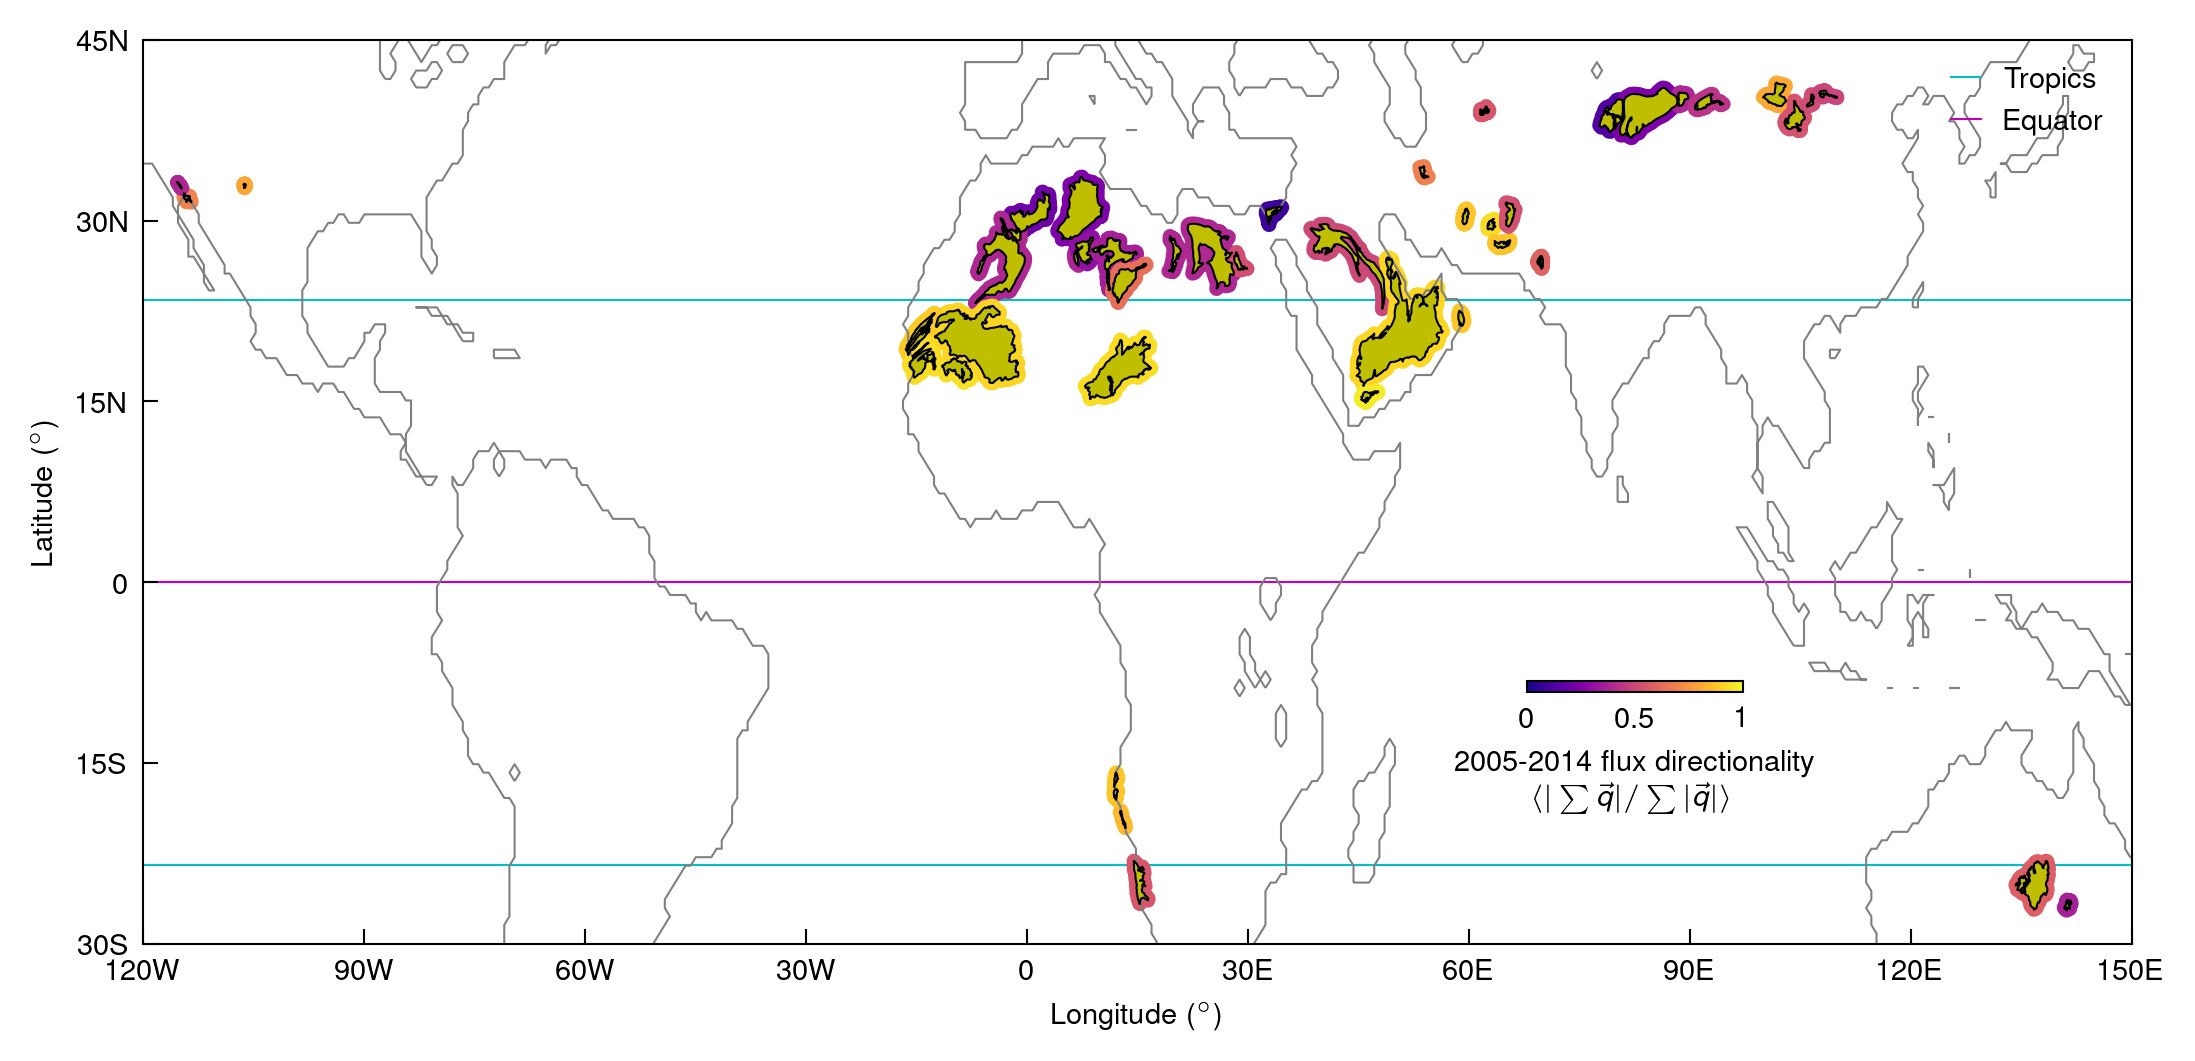

In [41]:
tropiclat = 23.43656

fig = plt.gcf()


vmin = 0
vmax = 1
colors = [cm.plasma(x) for x in mean_fd_scenario_ends_dfmean[0]]

ax0 = fig.add_axes([0.06,0.11,0.92,0.86])

# plt.contourf(maplon,maplat,mapocean,zorder=1,cmap='binary',vmin=0,vmax=10)
plt.contour(maplon,maplat,mapocean,[1],linewidths=lw,colors='grey',zorder=1)

plt.plot([-180,180],[ tropiclat, tropiclat],c='c',lw=lw,zorder=-1,label='Tropics')
plt.plot([-180,180],[-tropiclat,-tropiclat],c='c',lw=lw,zorder=-1)
plt.plot([-180,180],[0,0],c='m',lw=lw,zorder=-1,label='Equator')

for i in range(len(dfs)):
    x,y = dfs[i].exterior.xy
    plt.plot(np.asarray(x)-180,y, color='k', lw=lw)
    plt.fill(np.asarray(x)-180,y, color='y', lw=0,zorder=1)
    plt.plot(np.asarray(x)-180,y, color=colors[i], lw=lw*7,zorder=-1, solid_capstyle='round')
#     plt.text(df_avlon[i]-180,df_avlat[i],df_name_abb[i],ha='center',va='center',color=cm.tab10(i%10))

plt.xlim(-120,150)
plt.ylim(-30,45)
plt.legend(frameon=False,handlelength=lw*2)
ax0.set_ylabel('Latitude ($^\\circ$)')
ax0.set_xlabel('Longitude ($^\\circ$)')
ax0.set_xticks([-120,-90,-60,-30,0,30,60,90,120,150])
ax0.set_xticklabels(['120W','90W','60W','30W','0','30E','60E','90E','120E','150E'])
ax0.set_yticks([-30,-15,0,15,30,45])
ax0.set_yticklabels(['30S','15S','0','15N','30N','45N'])

sc0 = plt.scatter(-1000,100,c=0,vmin=0,vmax=1,cmap='plasma')
cbar0_ax = fig.add_axes([0.7,0.35,0.1,0.01])
c0 = fig.colorbar(sc0, orientation='horizontal',cax=cbar0_ax, ticks=[0,0.5,1])
cbar0_ax.xaxis.set_label_position('bottom')
cbar0_ax.xaxis.set_ticks_position('bottom')
c0.set_label('2005-2014 flux directionality\n$\\langle |\\sum\\vec{q}|/\\sum|\\vec{q}| \\rangle$',fontsize=fs)
c0.ax.set_xticklabels(['0','0.5','1'],fontsize=fs)
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
    
fig.set_size_inches(183/25.4,89/25.4, forward=True)
plt.savefig('figures/edfigF.pdf',dpi=600)
plt.savefig('figures/edfigF.png',dpi=600)

# Extended Data Table 1

In [42]:
columns = ['Name','Midpoint Latitude ($^\circ$)','Midpoint Longitude ($^\circ$)','Area (km$^2$)']
dfname_str = ['%s'%df_name[i] for i in np.argsort(df_area)[::-1]]
dflat_str = ['%.1f'%i for i in df_avlat[np.argsort(df_area)[::-1]]]
dflon_str = ['%.1f'%i for i in df_avlon[np.argsort(df_area)[::-1]]]
dfareas_str = ['%d'%(i/1e+6) for i in df_area[np.argsort(df_area)[::-1]]]

data = np.vstack((dfname_str,dflat_str,dflon_str,dfareas_str)).T
dataframe = pd.DataFrame(data=data,columns=columns)
dataframe.to_csv('figures/TableED1.csv',index=False)